# Imports

In [529]:
%run dataset_config.ipynb
%run dataset_viewer.ipynb
%run dataset_machine_learning_evaluation.ipynb
%run dataset_external_validation.ipynb

# Dataset config

## Constants

In [477]:
original_metrics = [
    # Covered method
    'Name','CountInput','CountLine','CountLineBlank','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','EdgeCoverage','PrimePathCoverage',
    
    # Test method
    'Name.1','CountInput.1','CountLine.1','CountLineBlank.1','CountLineCode.1','CountLineCodeDecl.1',
    'CountLineCodeExe.1','CountLineComment.1','CountOutput.1','CountStmt.1',
    'CountStmtDecl.1','CountPath.1','CountPathLog.1','CountStmtExe.1',
    'Cyclomatic.1','CyclomaticModified.1','CyclomaticStrict.1','Essential.1',
    'Knots.1','MaxEssentialKnots.1','MaxNesting.1','MinEssentialKnots.1',
]

metrics = [
    # Covered method
    'Name', 'CountInput','CountLineCode',
    'CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticStrict',
    'Knots','MaxNesting','EdgeCoverage','PrimePathCoverage',
    
    # Test method
    'CountLineCode.1',
    'CountOutput.1','CountStmt.1',
    'CountStmtDecl.1','CountPath.1','CountPathLog.1','CountStmtExe.1',
    'Cyclomatic.1','CyclomaticStrict.1'
]

## Loading

In [464]:
dataset = CoverageDataset('dataset-unificado.csv')

## Preprocessing

In [465]:
dataset.remove_last_column()
dataset.remove_nan()
dataset.convert_coverage_metrics_to_float()
dataset.under_sampling({1:1200, 2:840, 3:680})
dataset.select_metrics(metrics)
dataset.remove_ppc_greater_than_ec()
dataset.remove_ppc_between(0.90, 0.99)

# Dataset features

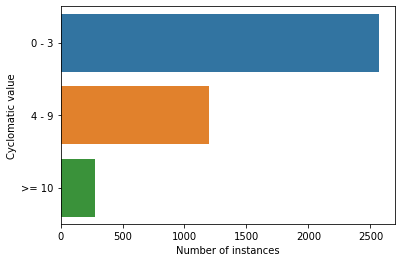

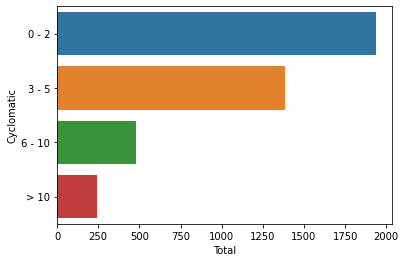

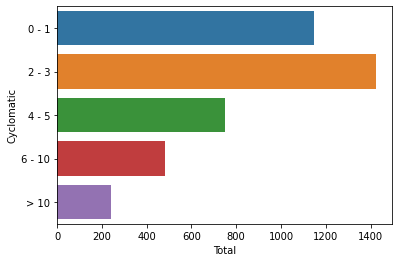

Dataset size: 4046
Average complexity: 3.7669303015323776


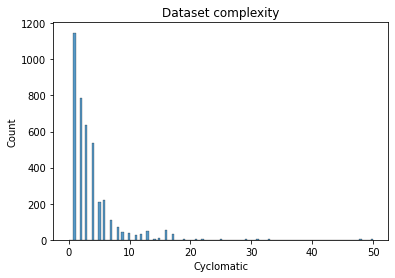

,Metrics,Correlation
12,EdgeCoverage,0.825134
19,CountStmtExe.1,0.146625
15,CountStmt.1,0.130735
13,CountLineCode.1,0.125402
14,CountOutput.1,0.096731
18,CountPathLog.1,-0.004081
21,CyclomaticStrict.1,-0.025631
20,Cyclomatic.1,-0.028980
17,CountPath.1,-0.033298
0,CountInput,-0.081333


,CountInput,CountLineCode,CountOutput,CountStmt,CountStmtDecl,CountPath,CountPathLog,CountStmtExe,Cyclomatic,CyclomaticStrict,...,PrimePathCoverage,CountLineCode.1,CountOutput.1,CountStmt.1,CountStmtDecl.1,CountPath.1,CountPathLog.1,CountStmtExe.1,Cyclomatic.1,CyclomaticStrict.1
count,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,...,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000
mean,22.466387,15.351211,5.390262,10.877410,2.961691,65.404103,0.473554,7.915719,3.766930,4.265447,...,0.619916,23.134207,9.707118,18.627533,4.422392,396.766930,0.083786,14.205141,1.404597,1.421898
std,39.676463,16.906695,4.965761,11.620441,3.618694,623.212835,0.675305,9.159057,4.196567,5.094919,...,0.362580,32.446400,8.965253,28.251063,3.230461,14275.007009,0.372277,27.780028,1.226880,1.281881
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,5.000000,6.000000,3.000000,4.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,...,0.333300,9.000000,5.000000,7.000000,3.000000,1.000000,0.000000,3.000000,1.000000,1.000000
50%,9.000000,11.000000,4.000000,7.000000,2.000000,3.000000,0.000000,5.000000,3.000000,3.000000,...,0.636400,14.000000,7.000000,11.000000,3.000000,1.000000,0.000000,6.000000,1.000000,1.000000
75%,20.000000,17.000000,7.000000,13.000000,3.000000,6.000000,1.000000,10.000000,4.000000,5.000000,...,1.000000,23.000000,11.000000,19.000000,5.000000,1.000000,0.000000,13.000000,1.000000,1.000000
max,201.000000,225.000000,58.000000,144.000000,49.000000,12240.000000,4.000000,99.000000,50.000000,72.000000,...,1.000000,273.000000,70.000000,230.000000,32.000000,524288.000000,6.000000,226.000000,20.000000,20.000000


,count,mean,std,min,25%,50%,75%,max
Project,,,,,,,,
Apache Commons Lang,174.0,2.551724,2.094632,1.0,1.0,1.0,3.0,12.0
Apache Commons Math,945.0,3.523810,3.349316,1.0,2.0,3.0,4.0,48.0
Apache Commons Text,278.0,3.582734,2.909959,0.0,2.0,3.0,5.0,19.0
Apache Dubbo,155.0,3.135484,2.984978,1.0,2.0,2.0,3.0,16.0
Biojava,157.0,2.363057,1.772847,1.0,1.0,2.0,3.0,13.0
Checkstyle,227.0,3.176211,1.771145,1.0,2.0,3.0,4.0,8.0
Exp4j,304.0,5.253289,4.839843,1.0,1.0,4.0,4.0,17.0
Jfreechart,1684.0,4.130048,5.204922,1.0,1.0,2.0,5.0,50.0
Urban Airship Java Library,122.0,2.795082,2.028469,1.0,1.0,2.0,4.0,8.0


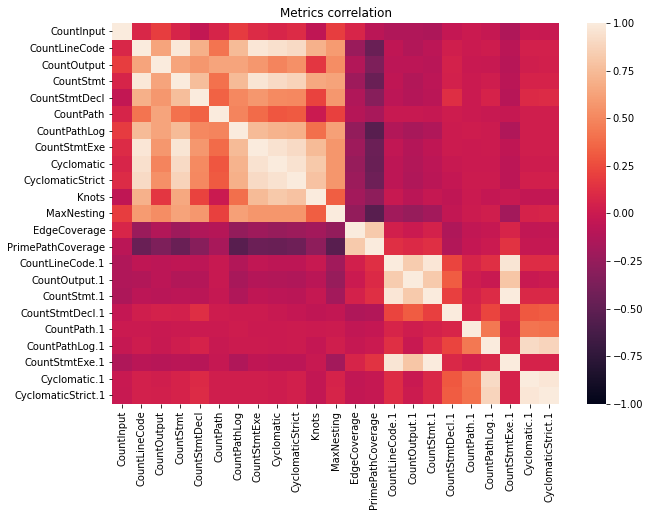

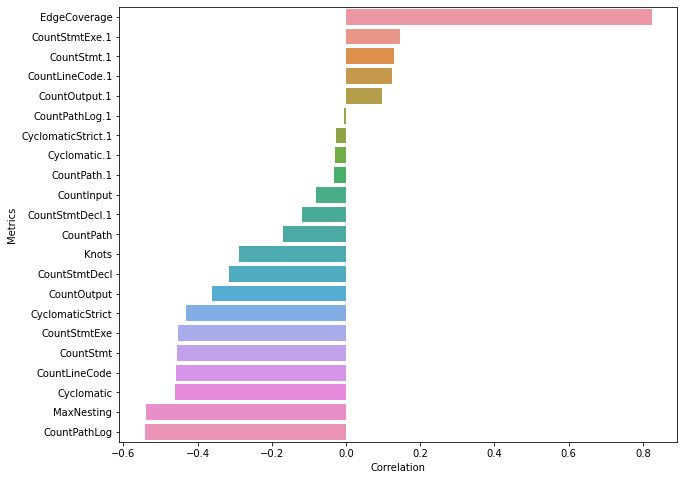

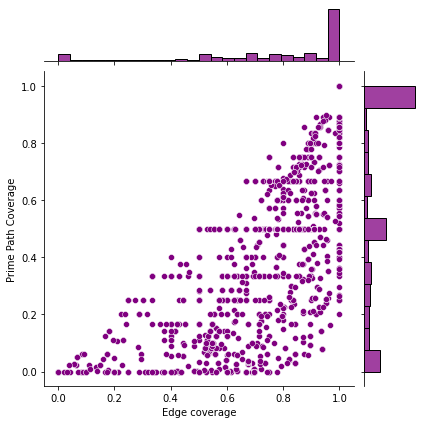

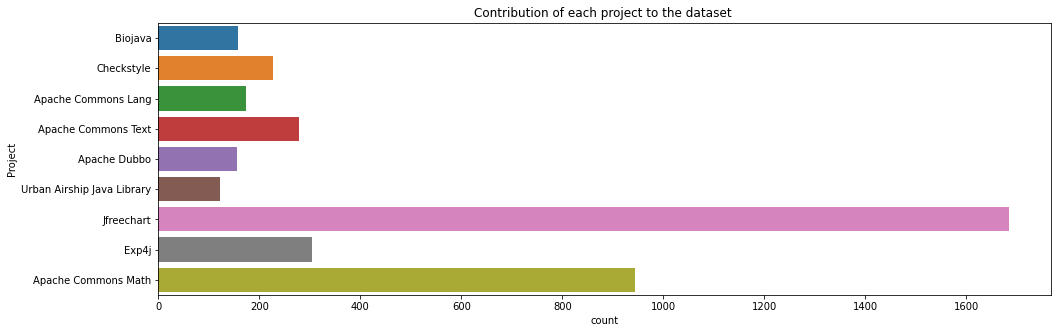

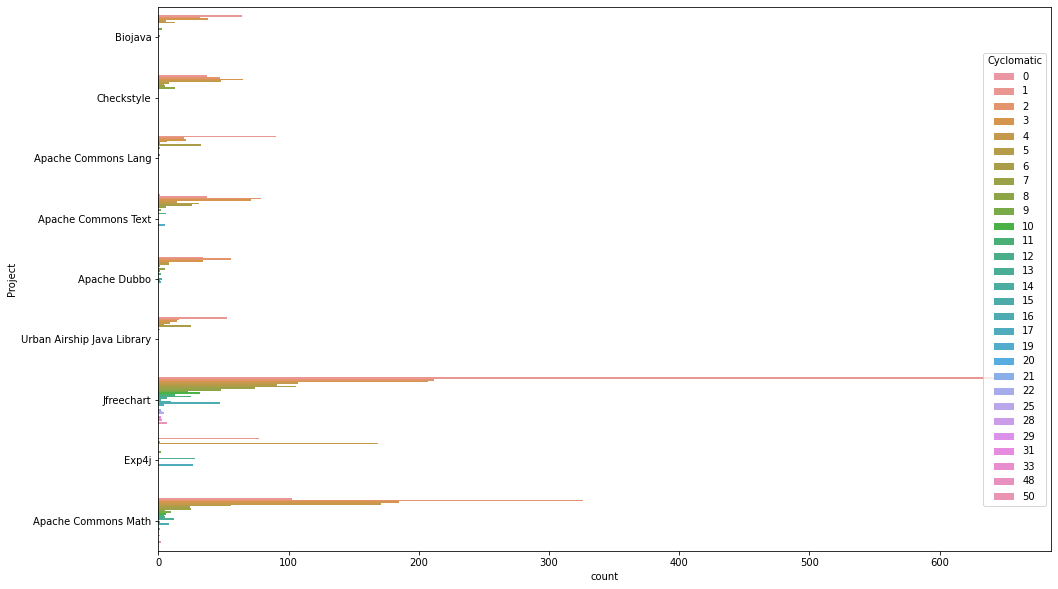

In [1195]:
dataset_view = CoverageDatasetViewer(dataset)

dataset_view.display_cyclomatic_overview
dataset_view.display_cyclomatic_groupby_3()
dataset_view.display_cyclomatic_groupby_4()
dataset_view.display_cyclomatic_groupby_5()
dataset_view.display_cyclomatic_overview()
dataset_view.display_correlation_heatmap()
dataset_view.display_correlation_table()
dataset_view.display_dataset_overview_table()
dataset_view.display_dataset_overview_table_groupby_project()
dataset_view.display_ppc_ec_chart()
dataset_view.display_project_contributions()
dataset_view.display_project_contributions_by_cyclomatic()

# Evaluation of machine learning algorithms 

## Metric selection

In [466]:
selected_metrics = [
    # Covered method
    'CountInput','CountLineCode',
    'CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticStrict',
    'Knots','MaxNesting','EdgeCoverage',
    
    # Test method
    'CountLineCode.1',
    'CountOutput.1','CountStmt.1',
    'CountStmtDecl.1','CountPath.1','CountPathLog.1','CountStmtExe.1',
    'Cyclomatic.1','CyclomaticStrict.1'
]

selected_metrics_without_ec = selected_metrics.copy()
selected_metrics_without_ec.remove('EdgeCoverage')

only_ec = ['EdgeCoverage']

## Algorithm evaluation

### Linear regression

In [202]:
evaluator = LinearRegressionMlPpcEvaluator(dataset)

#### SCM

In [186]:
evaluator.evaluate(selected_metrics_without_ec)

Metric: CountInput

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.596936,nan
Mean Sqr Error,0.493431,nan
Mean Sqr Log Error,0.221697,nan
Mean Median Error,0.615621,nan
R2 Score,3.256699,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.594344,nan
Mean Sqr Error,0.493504,nan
Mean Sqr Log Error,0.217890,nan
Mean Median Error,0.610562,nan
R2 Score,3.279997,nan


Metric: CountLineCode

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.566398,nan
Mean Sqr Error,0.445087,nan
Mean Sqr Log Error,0.206633,nan
Mean Median Error,0.516987,nan
R2 Score,2.675345,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.558791,nan
Mean Sqr Error,0.434472,nan
Mean Sqr Log Error,0.198592,nan
Mean Median Error,0.515637,nan
R2 Score,2.581397,nan


Metric: CountOutput

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.549487,nan
Mean Sqr Error,0.437516,nan
Mean Sqr Log Error,0.192594,nan
Mean Median Error,0.542911,nan
R2 Score,2.552918,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.519105,nan
Mean Sqr Error,0.400282,nan
Mean Sqr Log Error,0.167264,nan
Mean Median Error,0.515343,nan
R2 Score,2.229771,nan


Metric: CountStmt

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.565968,nan
Mean Sqr Error,0.443603,nan
Mean Sqr Log Error,0.206799,nan
Mean Median Error,0.503771,nan
R2 Score,2.667972,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.554924,nan
Mean Sqr Error,0.428140,nan
Mean Sqr Log Error,0.195260,nan
Mean Median Error,0.498217,nan
R2 Score,2.532018,nan


Metric: CountStmtDecl

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.593231,nan
Mean Sqr Error,0.479072,nan
Mean Sqr Log Error,0.235553,nan
Mean Median Error,0.577195,nan
R2 Score,3.004807,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.554544,nan
Mean Sqr Error,0.427653,nan
Mean Sqr Log Error,0.193133,nan
Mean Median Error,0.522715,nan
R2 Score,2.553135,nan


Metric: CountPath

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.620529,nan
Mean Sqr Error,0.515759,nan
Mean Sqr Log Error,0.265075,nan
Mean Median Error,0.637750,nan
R2 Score,3.322372,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.620529,nan
Mean Sqr Error,0.515759,nan
Mean Sqr Log Error,0.265075,nan
Mean Median Error,0.637750,nan
R2 Score,3.322372,nan


Metric: CountPathLog

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.584829,nan
Mean Sqr Error,0.481556,nan
Mean Sqr Log Error,0.239398,nan
Mean Median Error,0.529408,nan
R2 Score,2.994725,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.584829,nan
Mean Sqr Error,0.481556,nan
Mean Sqr Log Error,0.239398,nan
Mean Median Error,0.529408,nan
R2 Score,2.994725,nan


Metric: CountStmtExe

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.564181,nan
Mean Sqr Error,0.442224,nan
Mean Sqr Log Error,0.204525,nan
Mean Median Error,0.527555,nan
R2 Score,2.643582,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.564181,nan
Mean Sqr Error,0.442224,nan
Mean Sqr Log Error,0.204525,nan
Mean Median Error,0.527555,nan
R2 Score,2.643582,nan


Metric: Cyclomatic

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.560373,nan
Mean Sqr Error,0.439193,nan
Mean Sqr Log Error,0.200625,nan
Mean Median Error,0.524075,nan
R2 Score,2.620445,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.560373,nan
Mean Sqr Error,0.439193,nan
Mean Sqr Log Error,0.200625,nan
Mean Median Error,0.524075,nan
R2 Score,2.620445,nan


Metric: CyclomaticStrict

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.565623,nan
Mean Sqr Error,0.443532,nan
Mean Sqr Log Error,0.205334,nan
Mean Median Error,0.526735,nan
R2 Score,2.677907,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.565623,nan
Mean Sqr Error,0.443532,nan
Mean Sqr Log Error,0.205334,nan
Mean Median Error,0.526735,nan
R2 Score,2.677907,nan


Metric: Knots

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.601184,nan
Mean Sqr Error,0.497978,nan
Mean Sqr Log Error,0.248365,nan
Mean Median Error,0.571710,nan
R2 Score,3.151315,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.601184,nan
Mean Sqr Error,0.497978,nan
Mean Sqr Log Error,0.248365,nan
Mean Median Error,0.571710,nan
R2 Score,3.151315,nan


Metric: MaxNesting

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.530728,nan
Mean Sqr Error,0.417502,nan
Mean Sqr Log Error,0.197902,nan
Mean Median Error,0.475128,nan
R2 Score,2.434799,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.530728,nan
Mean Sqr Error,0.417502,nan
Mean Sqr Log Error,0.197902,nan
Mean Median Error,0.475128,nan
R2 Score,2.434799,nan


Metric: CountLineCode.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.527528,nan
Mean Sqr Error,0.411484,nan
Mean Sqr Log Error,0.174191,nan
Mean Median Error,0.484817,nan
R2 Score,2.429948,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.507579,nan
Mean Sqr Error,0.391887,nan
Mean Sqr Log Error,0.157675,nan
Mean Median Error,0.456567,nan
R2 Score,2.247018,nan


Metric: CountOutput.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.468066,nan
Mean Sqr Error,0.320935,nan
Mean Sqr Log Error,0.131034,nan
Mean Median Error,0.414069,nan
R2 Score,1.688328,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.450429,nan
Mean Sqr Error,0.300230,nan
Mean Sqr Log Error,0.119420,nan
Mean Median Error,0.401064,nan
R2 Score,1.503407,nan


Metric: CountStmt.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.531894,nan
Mean Sqr Error,0.420915,nan
Mean Sqr Log Error,0.178763,nan
Mean Median Error,0.485410,nan
R2 Score,2.493048,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.516561,nan
Mean Sqr Error,0.406926,nan
Mean Sqr Log Error,0.165548,nan
Mean Median Error,0.459655,nan
R2 Score,2.358661,nan


Metric: CountStmtDecl.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.493951,nan
Mean Sqr Error,0.343777,nan
Mean Sqr Log Error,0.148351,nan
Mean Median Error,0.475753,nan
R2 Score,1.927273,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.456406,nan
Mean Sqr Error,0.295450,nan
Mean Sqr Log Error,0.121128,nan
Mean Median Error,0.435910,nan
R2 Score,1.501410,nan


Metric: CountPath.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,1.316588,nan
Mean Sqr Error,641.290278,nan
Mean Sqr Log Error,0.300962,nan
Mean Median Error,0.637790,nan
R2 Score,4986.768360,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,1.644906,nan
Mean Sqr Error,1386.420062,nan
Mean Sqr Log Error,0.305533,nan
Mean Median Error,0.637529,nan
R2 Score,10781.808344,nan


Metric: CountPathLog.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.604491,nan
Mean Sqr Error,0.500256,nan
Mean Sqr Log Error,0.254062,nan
Mean Median Error,0.619283,nan
R2 Score,3.180224,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.604491,nan
Mean Sqr Error,0.500256,nan
Mean Sqr Log Error,0.254062,nan
Mean Median Error,0.619283,nan
R2 Score,3.180224,nan


Metric: CountStmtExe.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.547253,nan
Mean Sqr Error,0.436374,nan
Mean Sqr Log Error,0.190894,nan
Mean Median Error,0.499776,nan
R2 Score,2.624186,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.547253,nan
Mean Sqr Error,0.436374,nan
Mean Sqr Log Error,0.190894,nan
Mean Median Error,0.499776,nan
R2 Score,2.624186,nan


Metric: Cyclomatic.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.594341,nan
Mean Sqr Error,0.487346,nan
Mean Sqr Log Error,0.241867,nan
Mean Median Error,0.609383,nan
R2 Score,3.070626,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.453066,nan
Mean Sqr Error,0.328515,nan
Mean Sqr Log Error,0.118338,nan
Mean Median Error,0.402416,nan
R2 Score,1.728549,nan


Metric: CyclomaticStrict.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.594052,nan
Mean Sqr Error,0.485718,nan
Mean Sqr Log Error,0.241508,nan
Mean Median Error,0.609988,nan
R2 Score,3.058133,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.458055,nan
Mean Sqr Error,0.334246,nan
Mean Sqr Log Error,0.121167,nan
Mean Median Error,0.410739,nan
R2 Score,1.778086,nan


TypeError: display_results() missing 1 required positional argument: 'metric'

#### SCM + EC

In [187]:
evaluator.evaluate(selected_metrics)

Metric: CountInput

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.596936,nan
Mean Sqr Error,0.493431,nan
Mean Sqr Log Error,0.221697,nan
Mean Median Error,0.615621,nan
R2 Score,3.256699,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.594344,nan
Mean Sqr Error,0.493504,nan
Mean Sqr Log Error,0.217890,nan
Mean Median Error,0.610562,nan
R2 Score,3.279997,nan


Metric: CountLineCode

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.566398,nan
Mean Sqr Error,0.445087,nan
Mean Sqr Log Error,0.206633,nan
Mean Median Error,0.516987,nan
R2 Score,2.675345,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.558791,nan
Mean Sqr Error,0.434472,nan
Mean Sqr Log Error,0.198592,nan
Mean Median Error,0.515637,nan
R2 Score,2.581397,nan


Metric: CountOutput

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.549487,nan
Mean Sqr Error,0.437516,nan
Mean Sqr Log Error,0.192594,nan
Mean Median Error,0.542911,nan
R2 Score,2.552918,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.519105,nan
Mean Sqr Error,0.400282,nan
Mean Sqr Log Error,0.167264,nan
Mean Median Error,0.515343,nan
R2 Score,2.229771,nan


Metric: CountStmt

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.565968,nan
Mean Sqr Error,0.443603,nan
Mean Sqr Log Error,0.206799,nan
Mean Median Error,0.503771,nan
R2 Score,2.667972,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.554924,nan
Mean Sqr Error,0.428140,nan
Mean Sqr Log Error,0.195260,nan
Mean Median Error,0.498217,nan
R2 Score,2.532018,nan


Metric: CountStmtDecl

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.593231,nan
Mean Sqr Error,0.479072,nan
Mean Sqr Log Error,0.235553,nan
Mean Median Error,0.577195,nan
R2 Score,3.004807,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.554544,nan
Mean Sqr Error,0.427653,nan
Mean Sqr Log Error,0.193133,nan
Mean Median Error,0.522715,nan
R2 Score,2.553135,nan


Metric: CountPath

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.620529,nan
Mean Sqr Error,0.515759,nan
Mean Sqr Log Error,0.265075,nan
Mean Median Error,0.637750,nan
R2 Score,3.322372,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.620529,nan
Mean Sqr Error,0.515759,nan
Mean Sqr Log Error,0.265075,nan
Mean Median Error,0.637750,nan
R2 Score,3.322372,nan


Metric: CountPathLog

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.584829,nan
Mean Sqr Error,0.481556,nan
Mean Sqr Log Error,0.239398,nan
Mean Median Error,0.529408,nan
R2 Score,2.994725,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.584829,nan
Mean Sqr Error,0.481556,nan
Mean Sqr Log Error,0.239398,nan
Mean Median Error,0.529408,nan
R2 Score,2.994725,nan


Metric: CountStmtExe

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.564181,nan
Mean Sqr Error,0.442224,nan
Mean Sqr Log Error,0.204525,nan
Mean Median Error,0.527555,nan
R2 Score,2.643582,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.564181,nan
Mean Sqr Error,0.442224,nan
Mean Sqr Log Error,0.204525,nan
Mean Median Error,0.527555,nan
R2 Score,2.643582,nan


Metric: Cyclomatic

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.560373,nan
Mean Sqr Error,0.439193,nan
Mean Sqr Log Error,0.200625,nan
Mean Median Error,0.524075,nan
R2 Score,2.620445,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.560373,nan
Mean Sqr Error,0.439193,nan
Mean Sqr Log Error,0.200625,nan
Mean Median Error,0.524075,nan
R2 Score,2.620445,nan


Metric: CyclomaticStrict

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.565623,nan
Mean Sqr Error,0.443532,nan
Mean Sqr Log Error,0.205334,nan
Mean Median Error,0.526735,nan
R2 Score,2.677907,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.565623,nan
Mean Sqr Error,0.443532,nan
Mean Sqr Log Error,0.205334,nan
Mean Median Error,0.526735,nan
R2 Score,2.677907,nan


Metric: Knots

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.601184,nan
Mean Sqr Error,0.497978,nan
Mean Sqr Log Error,0.248365,nan
Mean Median Error,0.571710,nan
R2 Score,3.151315,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.601184,nan
Mean Sqr Error,0.497978,nan
Mean Sqr Log Error,0.248365,nan
Mean Median Error,0.571710,nan
R2 Score,3.151315,nan


Metric: MaxNesting

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.530728,nan
Mean Sqr Error,0.417502,nan
Mean Sqr Log Error,0.197902,nan
Mean Median Error,0.475128,nan
R2 Score,2.434799,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.530728,nan
Mean Sqr Error,0.417502,nan
Mean Sqr Log Error,0.197902,nan
Mean Median Error,0.475128,nan
R2 Score,2.434799,nan


Metric: EdgeCoverage

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.181272,nan
Mean Sqr Error,0.048730,nan
Mean Sqr Log Error,0.022441,nan
Mean Median Error,0.183828,nan
R2 Score,0.608668,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.181272,nan
Mean Sqr Error,0.048730,nan
Mean Sqr Log Error,0.022441,nan
Mean Median Error,0.183828,nan
R2 Score,0.608668,nan


Metric: CountLineCode.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.527528,nan
Mean Sqr Error,0.411484,nan
Mean Sqr Log Error,0.174191,nan
Mean Median Error,0.484817,nan
R2 Score,2.429948,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.507579,nan
Mean Sqr Error,0.391887,nan
Mean Sqr Log Error,0.157675,nan
Mean Median Error,0.456567,nan
R2 Score,2.247018,nan


Metric: CountOutput.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.468066,nan
Mean Sqr Error,0.320935,nan
Mean Sqr Log Error,0.131034,nan
Mean Median Error,0.414069,nan
R2 Score,1.688328,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.450429,nan
Mean Sqr Error,0.300230,nan
Mean Sqr Log Error,0.119420,nan
Mean Median Error,0.401064,nan
R2 Score,1.503407,nan


Metric: CountStmt.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.531894,nan
Mean Sqr Error,0.420915,nan
Mean Sqr Log Error,0.178763,nan
Mean Median Error,0.485410,nan
R2 Score,2.493048,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.516561,nan
Mean Sqr Error,0.406926,nan
Mean Sqr Log Error,0.165548,nan
Mean Median Error,0.459655,nan
R2 Score,2.358661,nan


Metric: CountStmtDecl.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.493951,nan
Mean Sqr Error,0.343777,nan
Mean Sqr Log Error,0.148351,nan
Mean Median Error,0.475753,nan
R2 Score,1.927273,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.456406,nan
Mean Sqr Error,0.295450,nan
Mean Sqr Log Error,0.121128,nan
Mean Median Error,0.435910,nan
R2 Score,1.501410,nan


Metric: CountPath.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,1.316588,nan
Mean Sqr Error,641.290278,nan
Mean Sqr Log Error,0.300962,nan
Mean Median Error,0.637790,nan
R2 Score,4986.768360,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,1.644906,nan
Mean Sqr Error,1386.420062,nan
Mean Sqr Log Error,0.305533,nan
Mean Median Error,0.637529,nan
R2 Score,10781.808344,nan


Metric: CountPathLog.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.604491,nan
Mean Sqr Error,0.500256,nan
Mean Sqr Log Error,0.254062,nan
Mean Median Error,0.619283,nan
R2 Score,3.180224,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.604491,nan
Mean Sqr Error,0.500256,nan
Mean Sqr Log Error,0.254062,nan
Mean Median Error,0.619283,nan
R2 Score,3.180224,nan


Metric: CountStmtExe.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.547253,nan
Mean Sqr Error,0.436374,nan
Mean Sqr Log Error,0.190894,nan
Mean Median Error,0.499776,nan
R2 Score,2.624186,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.547253,nan
Mean Sqr Error,0.436374,nan
Mean Sqr Log Error,0.190894,nan
Mean Median Error,0.499776,nan
R2 Score,2.624186,nan


Metric: Cyclomatic.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.594341,nan
Mean Sqr Error,0.487346,nan
Mean Sqr Log Error,0.241867,nan
Mean Median Error,0.609383,nan
R2 Score,3.070626,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.453066,nan
Mean Sqr Error,0.328515,nan
Mean Sqr Log Error,0.118338,nan
Mean Median Error,0.402416,nan
R2 Score,1.728549,nan


Metric: CyclomaticStrict.1

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.594052,nan
Mean Sqr Error,0.485718,nan
Mean Sqr Log Error,0.241508,nan
Mean Median Error,0.609988,nan
R2 Score,3.058133,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.458055,nan
Mean Sqr Error,0.334246,nan
Mean Sqr Log Error,0.121167,nan
Mean Median Error,0.410739,nan
R2 Score,1.778086,nan


TypeError: display_results() missing 1 required positional argument: 'metric'

#### EC

In [203]:
evaluator.evaluate(only_ec)

Metric: EdgeCoverage

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.181272,nan
Mean Sqr Error,0.048730,nan
Mean Sqr Log Error,0.022441,nan
Mean Median Error,0.183828,nan
R2 Score,0.608668,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.181272,nan
Mean Sqr Error,0.048730,nan
Mean Sqr Log Error,0.022441,nan
Mean Median Error,0.183828,nan
R2 Score,0.608668,nan


### SVR

In [174]:
evaluator = SvrMlPpcEvaluator(dataset)

#### SCM

In [175]:
evaluator.evaluate(selected_metrics_without_ec)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "c:\users\user

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.257631,0.257631
Mean Sqr Error,0.089112,0.089112
Mean Sqr Log Error,0.039610,0.039610
Mean Median Error,0.267385,0.267385
R2 Score,0.278446,0.278446


Seed,0,Mean
Error Metrics,,
Mean Abs Error,nan,nan
Mean Sqr Error,nan,nan
Mean Sqr Log Error,nan,nan
Mean Median Error,nan,nan
R2 Score,nan,nan


#### SCM + EC

In [176]:
evaluator.evaluate(selected_metrics)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "c:\users\user

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.191803,0.191803
Mean Sqr Error,0.045155,0.045155
Mean Sqr Log Error,0.019308,0.019308
Mean Median Error,0.212823,0.212823
R2 Score,0.634323,0.634323


Seed,0,Mean
Error Metrics,,
Mean Abs Error,nan,nan
Mean Sqr Error,nan,nan
Mean Sqr Log Error,nan,nan
Mean Median Error,nan,nan
R2 Score,nan,nan


#### EC

In [177]:
evaluator.evaluate(only_ec)

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.221853,0.221853
Mean Sqr Error,0.060543,0.060543
Mean Sqr Log Error,0.025239,0.025239
Mean Median Error,0.276076,0.276076
R2 Score,0.506698,0.506698


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.221853,0.221853
Mean Sqr Error,0.060543,0.060543
Mean Sqr Log Error,0.025239,0.025239
Mean Median Error,0.276076,0.276076
R2 Score,0.506698,0.506698


### Random forest

In [166]:
evaluator = RandomForestMlPpcEvaluator(dataset)

#### SCM

In [167]:
evaluator.evaluate(selected_metrics_without_ec)

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.195226,0.195226
Mean Sqr Error,0.077131,0.077131
Mean Sqr Log Error,0.035380,0.035380
Mean Median Error,0.145249,0.145249
R2 Score,0.372026,0.372026


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.194851,0.194851
Mean Sqr Error,0.076898,0.076898
Mean Sqr Log Error,0.035262,0.035262
Mean Median Error,0.144115,0.144115
R2 Score,0.373716,0.373716


#### SCM + EC

In [168]:
evaluator.evaluate(selected_metrics)

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.052692,0.052692
Mean Sqr Error,0.011384,0.011384
Mean Sqr Log Error,0.005512,0.005512
Mean Median Error,0.012454,0.012454
R2 Score,0.907666,0.907666


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.052406,0.052406
Mean Sqr Error,0.011286,0.011286
Mean Sqr Log Error,0.005457,0.005457
Mean Median Error,0.012396,0.012396
R2 Score,0.908331,0.908331


#### EC

In [169]:
evaluator.evaluate(only_ec)

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.094211,0.094211
Mean Sqr Error,0.021066,0.021066
Mean Sqr Log Error,0.009956,0.009956
Mean Median Error,0.047186,0.047186
R2 Score,0.833398,0.833398


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.094211,0.094211
Mean Sqr Error,0.021066,0.021066
Mean Sqr Log Error,0.009956,0.009956
Mean Median Error,0.047186,0.047186
R2 Score,0.833398,0.833398


### K-Neighbors

In [221]:
evaluator = KNeighborsMlPpcEvaluator(dataset)

#### SCM

In [222]:
evaluator.evaluate(selected_metrics_without_ec)

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.197072,nan
Mean Sqr Error,0.090294,nan
Mean Sqr Log Error,0.042334,nan
Mean Median Error,0.123105,nan
R2 Score,0.256461,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.205429,nan
Mean Sqr Error,0.092039,nan
Mean Sqr Log Error,0.042133,nan
Mean Median Error,0.135574,nan
R2 Score,0.265768,nan


#### SCM + EC

In [223]:
evaluator.evaluate(selected_metrics)

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.066448,nan
Mean Sqr Error,0.017297,nan
Mean Sqr Log Error,0.008669,nan
Mean Median Error,0.010475,nan
R2 Score,0.860029,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.198594,nan
Mean Sqr Error,0.088356,nan
Mean Sqr Log Error,0.040744,nan
Mean Median Error,0.122477,nan
R2 Score,0.293634,nan


#### EC

In [224]:
evaluator.evaluate(only_ec)

Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.095385,nan
Mean Sqr Error,0.022433,nan
Mean Sqr Log Error,0.010550,nan
Mean Median Error,0.056980,nan
R2 Score,0.820878,nan


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.095385,nan
Mean Sqr Error,0.022433,nan
Mean Sqr Log Error,0.010550,nan
Mean Median Error,0.056980,nan
R2 Score,0.820878,nan


### Neural Network

In [239]:
evaluator = NeuralNetworkMlPpcEvaluator(dataset)

#### SCM

In [240]:
evaluator.evaluate(selected_metrics_without_ec)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "c:\users\user

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "c:\users\user

Seed,0
Error Metrics,
Mean Abs Error,0.301559
Mean Sqr Error,0.117297
Mean Sqr Log Error,0.053006
Mean Median Error,0.316810
R2 Score,0.062944


Seed,0
Error Metrics,
Mean Abs Error,nan
Mean Sqr Error,nan
Mean Sqr Log Error,nan
Mean Median Error,nan
R2 Score,nan


#### SCM + EC

In [241]:
evaluator.evaluate(selected_metrics)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "c:\users\user

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "c:\users\user

Seed,0
Error Metrics,
Mean Abs Error,nan
Mean Sqr Error,nan
Mean Sqr Log Error,nan
Mean Median Error,nan
R2 Score,nan


Seed,0
Error Metrics,
Mean Abs Error,nan
Mean Sqr Error,nan
Mean Sqr Log Error,nan
Mean Median Error,nan
R2 Score,nan


#### EC

In [242]:
evaluator.evaluate(only_ec)

Seed,0
Error Metrics,
Mean Abs Error,0.241576
Mean Sqr Error,0.073995
Mean Sqr Log Error,0.034002
Mean Median Error,0.263616
R2 Score,0.412283


Seed,0
Error Metrics,
Mean Abs Error,0.241576
Mean Sqr Error,0.073995
Mean Sqr Log Error,0.034002
Mean Median Error,0.263616
R2 Score,0.412283


## Best algorithm:
- SCM: Random forest
- SCM + EC: Random forest
- EC: Random forest

# Evaluation of models with varying metrics 

In [312]:
feature_importance_evaluator = RandomForestFeatureImportance(dataset)

### SCM

,Metrics,Feature importance
0,CountPath,0.270388
1,MaxNesting,0.147431
2,CountInput,0.074406
3,CountOutput.1,0.065276
4,CountStmtExe.1,0.055441
5,CountStmtDecl.1,0.052738
6,CountLineCode.1,0.046438
7,CountLineCode,0.042424
8,CountOutput,0.039245
9,CountStmt.1,0.035255


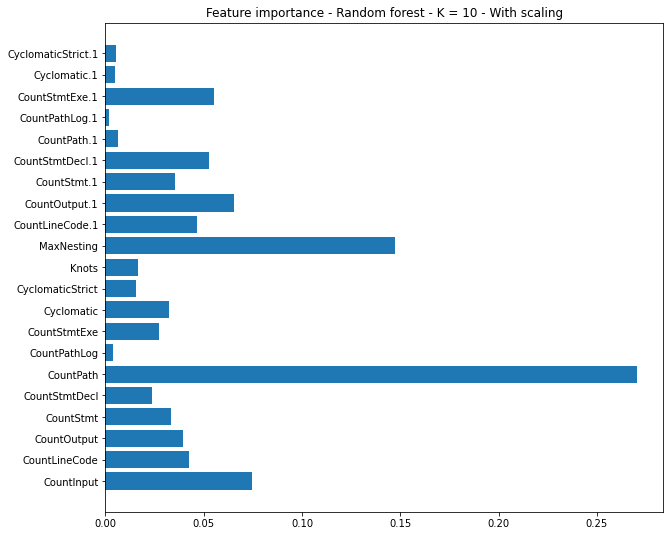

,Metrics,Feature importance
0,CountPath,0.261318
1,MaxNesting,0.151634
2,CountInput,0.073496
3,CountOutput.1,0.065230
4,CountStmtExe.1,0.055765
5,CountStmtDecl.1,0.053204
6,CountLineCode.1,0.045121
7,CountLineCode,0.042697
8,CountOutput,0.039046
9,Cyclomatic,0.035690


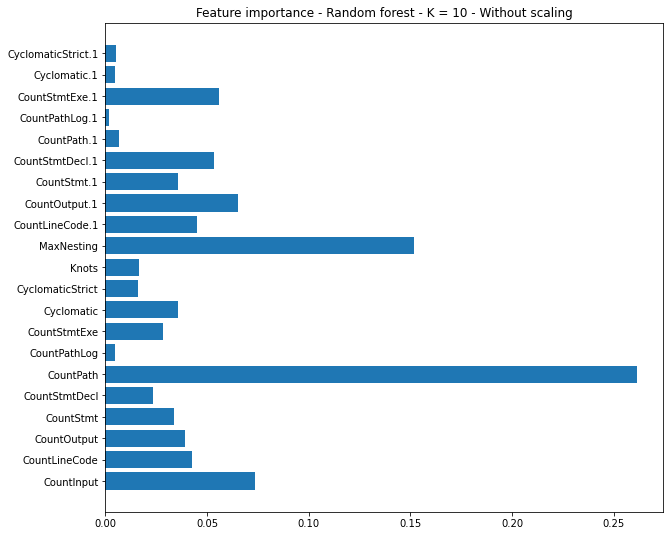

In [313]:
feature_importance_evaluator.evaluate(selected_metrics_without_ec)

### SCM + EC

,Metrics,Feature importance
0,EdgeCoverage,0.843989
1,CountPath,0.032055
2,CountStmt,0.028589
3,CountOutput,0.019905
4,CountStmtDecl,0.010373
5,CountStmtExe,0.010365
6,Knots,0.010133
7,CountInput,0.007381
8,MaxNesting,0.007263
9,CountLineCode,0.006296


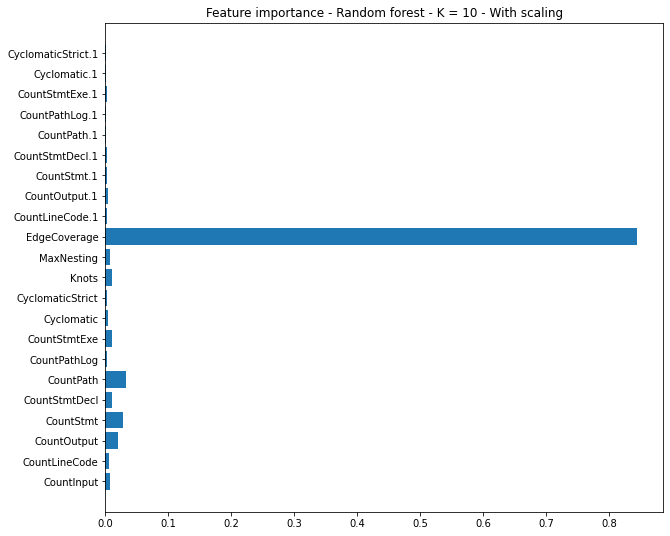

,Metrics,Feature importance
0,EdgeCoverage,0.843710
1,CountPath,0.031125
2,CountStmt,0.028141
3,CountOutput,0.019732
4,CountStmtExe,0.010976
5,CountStmtDecl,0.010511
6,Knots,0.010009
7,CountInput,0.007327
8,MaxNesting,0.007304
9,CountLineCode,0.006537


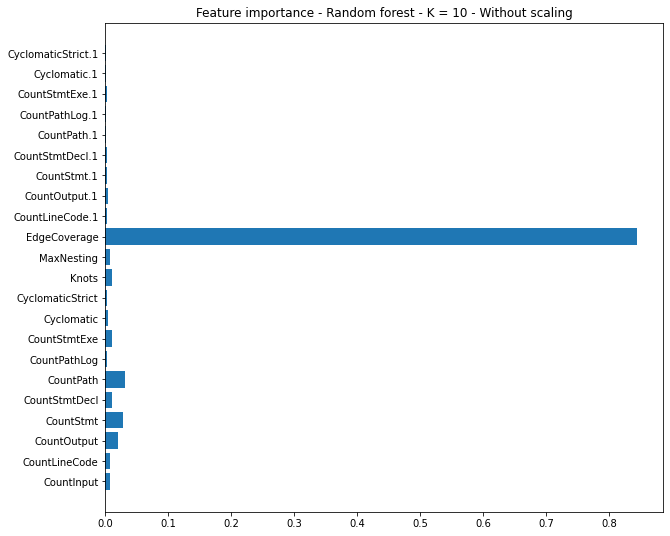

In [314]:
feature_importance_evaluator.evaluate(selected_metrics)

### EC

Not applicable

# Hyper-parameter selection

## Validation curves (seleção de parametros)

### SCM

### SCM + EC

### EC

## Tuning hyper-parameters

### SCM

### SCM + EC

### EC

## Evaluation using Random Forest

### SCM

### SCM + EC

### EC

# External validation

## With undersampling

In [530]:
dataset_external_validation_with_undersampling = CoverageDataset('dataset-unificado-validacao.csv')
dataset_external_validation_with_undersampling.remove_last_column()
dataset_external_validation_with_undersampling.remove_nan()
dataset_external_validation_with_undersampling.convert_coverage_metrics_to_float()
dataset_external_validation_with_undersampling.under_sampling({1:60, 2:86, 3:40})
dataset_external_validation_with_undersampling.select_metrics(metrics)

external_validation_with_undersampling = ExternalValidation(dataset, dataset_external_validation_with_undersampling)

### SCM

In [531]:
external_validation_with_undersampling.evaluate(selected_metrics_without_ec)

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.326509,0.151643,0.068561,0.298031,0.024384


,Cyclomatic,Average error,Total
0,[0;2],0.375041,146
1,[3;5],0.276185,98
2,[6;8],0.232690,47
3,[8;10],0.180902,32
4,> 10,0.195005,17


,Cyclomatic,EC correct,PPC predict,PPC correct,Error
84,6,1.000000,0.210361,1.000000,0.789639
46,4,0.333300,0.289518,1.000000,0.710482
39,1,1.000000,0.293337,1.000000,0.706663
40,1,1.000000,0.293337,1.000000,0.706663
38,1,1.000000,0.293337,1.000000,0.706663
15,1,1.000000,0.313337,1.000000,0.686663
90,3,1.000000,0.320501,1.000000,0.679499
266,2,1.000000,0.326409,1.000000,0.673591
223,3,1.000000,0.328621,1.000000,0.671379
31,1,0.050000,0.668923,0.000000,0.668923


,Interval,Total
0,Error == 0,0
1,0 < Error < 0.3,170
2,0.3 <= Error < 0.5,93
3,0.5 <= Error < 0.7,57
4,Error >= 0.7,5


,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.259008,0.114192,0.056651,0.195432,0.265331


,Cyclomatic,Average error,Total
0,[0;2],0.275639,146
1,[3;5],0.276563,98
2,[6;8],0.207700,47
3,[8;10],0.173995,32
4,> 10,0.089889,17


,Cyclomatic,EC correct,PPC predict,PPC correct,Error
201,1,0.000000,1.000000,0.000000,1.000000
199,1,0.000000,1.000000,0.000000,1.000000
198,1,0.000000,1.000000,0.000000,1.000000
5,1,0.000000,0.990000,0.000000,0.990000
24,1,0.000000,0.899544,0.000000,0.899544
32,1,0.050000,0.893208,0.000000,0.893208
195,1,0.000000,0.890000,0.000000,0.890000
178,3,0.000000,0.886168,0.000000,0.886168
197,1,0.000000,0.860000,0.000000,0.860000
31,1,0.050000,0.857410,0.000000,0.857410


,Interval,Total
0,Error == 0,3
1,0 < Error < 0.3,219
2,0.3 <= Error < 0.5,62
3,0.5 <= Error < 0.7,28
4,Error >= 0.7,13


### SCM + EC

In [532]:
external_validation_with_undersampling.evaluate(selected_metrics)

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.177521,0.069506,0.035001,0.124471,0.552826


,Cyclomatic,Average error,Total
0,[0;2],0.105253,146
1,[3;5],0.232596,98
2,[6;8],0.178658,47
3,[8;10],0.119089,32
4,> 10,0.125148,17


,Cyclomatic,EC correct,PPC predict,PPC correct,Error
46,4,0.333300,0.159650,1.000000,0.840350
253,2,0.250000,0.161418,1.000000,0.838582
230,2,0.250000,0.167855,1.000000,0.832145
248,2,0.250000,0.168355,1.000000,0.831645
48,2,0.666700,0.241943,1.000000,0.758057
45,2,0.666700,0.245276,1.000000,0.754724
246,5,0.666700,0.012614,0.750000,0.737386
36,2,0.666700,0.280806,1.000000,0.719194
242,5,0.666700,0.035073,0.750000,0.714927
245,5,0.888900,0.104715,0.750000,0.645285


,Interval,Total
0,Error == 0,43
1,0 < Error < 0.3,230
2,0.3 <= Error < 0.5,30
3,0.5 <= Error < 0.7,13
4,Error >= 0.7,9


,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.081060,0.025698,0.013040,0.025240,0.834668


,Cyclomatic,Average error,Total
0,[0;2],0.049583,146
1,[3;5],0.126469,98
2,[6;8],0.065856,47
3,[8;10],0.105812,32
4,> 10,0.046881,17


,Cyclomatic,EC correct,PPC predict,PPC correct,Error
248,2,0.250000,0.045119,1.000000,0.954881
253,2,0.250000,0.050254,1.000000,0.949746
230,2,0.250000,0.051340,1.000000,0.948660
46,4,0.333300,0.190894,1.000000,0.809106
45,2,0.666700,0.500000,1.000000,0.500000
36,2,0.666700,0.500000,1.000000,0.500000
48,2,0.666700,0.500000,1.000000,0.500000
296,2,0.500000,0.495000,0.000000,0.495000
191,4,0.666700,0.452524,0.000000,0.452524
114,3,0.600000,0.215317,0.666700,0.451383


,Interval,Total
0,Error == 0,117
1,0 < Error < 0.3,190
2,0.3 <= Error < 0.5,11
3,0.5 <= Error < 0.7,3
4,Error >= 0.7,4


### EC

In [533]:
external_validation_with_undersampling.evaluate(only_ec)

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.124253,0.040010,0.019935,0.047245,0.742591


,Cyclomatic,Average error,Total
0,[0;2],0.085625,146
1,[3;5],0.141738,98
2,[6;8],0.148019,47
3,[8;10],0.181882,32
4,> 10,0.136924,17


,Cyclomatic,EC correct,PPC predict,PPC correct,Error
230,2,0.250000,0.152912,1.000000,0.847088
248,2,0.250000,0.152912,1.000000,0.847088
253,2,0.250000,0.152912,1.000000,0.847088
46,4,0.333300,0.220604,1.000000,0.779396
320,5,1.000000,0.957010,0.343800,0.613210
36,2,0.666700,0.403666,1.000000,0.596334
45,2,0.666700,0.403666,1.000000,0.596334
48,2,0.666700,0.403666,1.000000,0.596334
322,5,1.000000,0.957010,0.375000,0.582010
122,6,1.000000,0.957010,0.473700,0.483310


,Interval,Total
0,Error == 0,28
1,0 < Error < 0.3,259
2,0.3 <= Error < 0.5,29
3,0.5 <= Error < 0.7,5
4,Error >= 0.7,4


,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.124253,0.040010,0.019935,0.047245,0.742591


,Cyclomatic,Average error,Total
0,[0;2],0.085625,146
1,[3;5],0.141738,98
2,[6;8],0.148019,47
3,[8;10],0.181882,32
4,> 10,0.136924,17


,Cyclomatic,EC correct,PPC predict,PPC correct,Error
230,2,0.250000,0.152912,1.000000,0.847088
248,2,0.250000,0.152912,1.000000,0.847088
253,2,0.250000,0.152912,1.000000,0.847088
46,4,0.333300,0.220604,1.000000,0.779396
320,5,1.000000,0.957010,0.343800,0.613210
36,2,0.666700,0.403666,1.000000,0.596334
45,2,0.666700,0.403666,1.000000,0.596334
48,2,0.666700,0.403666,1.000000,0.596334
322,5,1.000000,0.957010,0.375000,0.582010
122,6,1.000000,0.957010,0.473700,0.483310


,Interval,Total
0,Error == 0,28
1,0 < Error < 0.3,259
2,0.3 <= Error < 0.5,29
3,0.5 <= Error < 0.7,5
4,Error >= 0.7,4


## Without undersampling

In [534]:
dataset_external_validation_without_undersampling = CoverageDataset('dataset-unificado-validacao.csv')
dataset_external_validation_without_undersampling.remove_last_column()
dataset_external_validation_without_undersampling.remove_nan()
dataset_external_validation_without_undersampling.convert_coverage_metrics_to_float()
dataset_external_validation_without_undersampling.select_metrics(metrics)

external_validation_without_undersampling = ExternalValidation(dataset, dataset_external_validation_without_undersampling)

### SCM

In [535]:
external_validation_without_undersampling.evaluate(selected_metrics_without_ec)

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.350786,0.174271,0.077488,0.343156,-0.060620


,Cyclomatic,Average error,Total
0,[0;2],0.374312,280
1,[3;5],0.294461,104
2,[6;8],0.257436,47
3,[8;10],0.166136,32
4,> 10,0.147527,17


,Cyclomatic,EC correct,PPC predict,PPC correct,Error
48,1,0.050000,0.943334,0.000000,0.943334
47,1,0.050000,0.943334,0.000000,0.943334
46,1,0.050000,0.943334,0.000000,0.943334
116,6,1.000000,0.065102,1.000000,0.934898
291,1,0.000000,0.926668,0.000000,0.926668
298,1,0.000000,0.926668,0.000000,0.926668
296,1,0.000000,0.886668,0.000000,0.886668
9,1,0.000000,0.856668,0.000000,0.856668
115,6,0.947400,0.065102,0.833300,0.768198
102,3,1.000000,0.236203,1.000000,0.763797


,Interval,Total
0,Error == 0,0
1,0 < Error < 0.3,244
2,0.3 <= Error < 0.5,93
3,0.5 <= Error < 0.7,111
4,Error >= 0.7,17


,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.275875,0.127346,0.062252,0.214175,0.224968


,Cyclomatic,Average error,Total
0,[0;2],0.293026,280
1,[3;5],0.275758,104
2,[6;8],0.207700,47
3,[8;10],0.173995,32
4,> 10,0.089889,17


,Cyclomatic,EC correct,PPC predict,PPC correct,Error
294,1,0.000000,1.000000,0.000000,1.000000
291,1,0.000000,1.000000,0.000000,1.000000
296,1,0.000000,1.000000,0.000000,1.000000
298,1,0.000000,1.000000,0.000000,1.000000
9,1,0.000000,0.990000,0.000000,0.990000
293,1,0.000000,0.960000,0.000000,0.960000
33,1,0.000000,0.899544,0.000000,0.899544
47,1,0.050000,0.893208,0.000000,0.893208
287,1,0.000000,0.890000,0.000000,0.890000
40,1,0.000000,0.889544,0.000000,0.889544


,Interval,Total
0,Error == 0,4
1,0 < Error < 0.3,291
2,0.3 <= Error < 0.5,101
3,0.5 <= Error < 0.7,46
4,Error >= 0.7,23


### SCM + EC

In [536]:
external_validation_without_undersampling.evaluate(selected_metrics)

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.168330,0.070278,0.034361,0.106172,0.572283


,Cyclomatic,Average error,Total
0,[0;2],0.112946,280
1,[3;5],0.229383,104
2,[6;8],0.178547,47
3,[8;10],0.118562,32
4,> 10,0.124966,17


,Cyclomatic,EC correct,PPC predict,PPC correct,Error
69,4,0.333300,0.159650,1.000000,0.840350
371,2,0.250000,0.161418,1.000000,0.838582
369,2,0.250000,0.163512,1.000000,0.836488
367,2,0.250000,0.163640,1.000000,0.836360
375,2,0.250000,0.163640,1.000000,0.836360
7,2,0.833300,0.166319,1.000000,0.833681
343,2,0.250000,0.167855,1.000000,0.832145
372,2,0.250000,0.168355,1.000000,0.831645
364,2,0.250000,0.168355,1.000000,0.831645
76,2,0.666700,0.241943,1.000000,0.758057


,Interval,Total
0,Error == 0,82
1,0 < Error < 0.3,317
2,0.3 <= Error < 0.5,34
3,0.5 <= Error < 0.7,14
4,Error >= 0.7,18


,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.080017,0.031682,0.015413,0.006703,0.807184


,Cyclomatic,Average error,Total
0,[0;2],0.059992,280
1,[3;5],0.120947,104
2,[6;8],0.068714,47
3,[8;10],0.110128,32
4,> 10,0.077187,17


,Cyclomatic,EC correct,PPC predict,PPC correct,Error
364,2,0.250000,0.135746,1.000000,0.864254
369,2,0.250000,0.135746,1.000000,0.864254
372,2,0.250000,0.135746,1.000000,0.864254
371,2,0.250000,0.146821,1.000000,0.853179
367,2,0.250000,0.147270,1.000000,0.852730
375,2,0.250000,0.147270,1.000000,0.852730
343,2,0.250000,0.147409,1.000000,0.852591
69,4,0.333300,0.149218,1.000000,0.850782
7,2,0.833300,0.435933,1.000000,0.564067
377,2,0.833300,0.495240,1.000000,0.504760


,Interval,Total
0,Error == 0,212
1,0 < Error < 0.3,221
2,0.3 <= Error < 0.5,12
3,0.5 <= Error < 0.7,12
4,Error >= 0.7,8


### EC

In [537]:
external_validation_without_undersampling.evaluate(only_ec)

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.117868,0.041309,0.019792,0.041060,0.748591


,Cyclomatic,Average error,Total
0,[0;2],0.090325,280
1,[3;5],0.139530,104
2,[6;8],0.170694,47
3,[8;10],0.185357,32
4,> 10,0.116733,17


,Cyclomatic,EC correct,PPC predict,PPC correct,Error
369,2,0.250000,0.180912,1.000000,0.819088
343,2,0.250000,0.180912,1.000000,0.819088
364,2,0.250000,0.180912,1.000000,0.819088
372,2,0.250000,0.180912,1.000000,0.819088
371,2,0.250000,0.180912,1.000000,0.819088
367,2,0.250000,0.180912,1.000000,0.819088
375,2,0.250000,0.180912,1.000000,0.819088
69,4,0.333300,0.225243,1.000000,0.774757
54,2,0.666700,0.379704,1.000000,0.620296
76,2,0.666700,0.379704,1.000000,0.620296


,Interval,Total
0,Error == 0,55
1,0 < Error < 0.3,358
2,0.3 <= Error < 0.5,30
3,0.5 <= Error < 0.7,14
4,Error >= 0.7,8


,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.117868,0.041309,0.019792,0.041060,0.748591


,Cyclomatic,Average error,Total
0,[0;2],0.090325,280
1,[3;5],0.139530,104
2,[6;8],0.170694,47
3,[8;10],0.185357,32
4,> 10,0.116733,17


,Cyclomatic,EC correct,PPC predict,PPC correct,Error
369,2,0.250000,0.180912,1.000000,0.819088
343,2,0.250000,0.180912,1.000000,0.819088
364,2,0.250000,0.180912,1.000000,0.819088
372,2,0.250000,0.180912,1.000000,0.819088
371,2,0.250000,0.180912,1.000000,0.819088
367,2,0.250000,0.180912,1.000000,0.819088
375,2,0.250000,0.180912,1.000000,0.819088
69,4,0.333300,0.225243,1.000000,0.774757
54,2,0.666700,0.379704,1.000000,0.620296
76,2,0.666700,0.379704,1.000000,0.620296


,Interval,Total
0,Error == 0,55
1,0 < Error < 0.3,358
2,0.3 <= Error < 0.5,30
3,0.5 <= Error < 0.7,14
4,Error >= 0.7,8


# -----< OLD >-----

# Importações

In [315]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Leitura dataset e pré-processamento

In [316]:
global dataset
global dataset_original

def load_dataset(name='dataset-unificado.csv'):
    global dataset
    global dataset_original
    
    dataset = pd.read_csv(name, sep=';')
    dataset_original = dataset
    
def under_sampling(sampling_strategy={1:800, 2:320}):
    global dataset
    global dataset_original
    
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={0:0, 1:299, 2:900, 3:826, 4:458, 5:233})
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={0:0, 1:454, 2:970, 3:717, 4:458, 5:204})
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={1:800, 2:520})
    rus = RandomUnderSampler(random_state=0, sampling_strategy=sampling_strategy)
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={1:700, 2:270, 3:692})
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={1:655, 2:229, 3:648})
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={1:454})
    X_res, y_res = rus.fit_resample(
            pd.DataFrame(dataset.index.array)[0].values.reshape(-1,1), 
            dataset['Cyclomatic'].values
    )
    
    dataset['idx'] = dataset.index
    idx_selected = X_res.reshape(1,-1)[0]
    dataset['selected'] = dataset['idx'].apply(lambda idx: idx in idx_selected)
    dataset = dataset[dataset['selected']]
    dataset = dataset.drop('idx', axis=1)
    dataset = dataset.drop('selected', axis=1)
    
def remove_last_column():
    global dataset
    
    dataset = dataset.iloc[:,:-1]
    
def remove_nan():
    global dataset
    
    dataset = dataset.dropna()
    
def fix_coverage_metrics():
    global dataset
    
    dataset.iloc[:,-1] = dataset.iloc[:,-1].apply(lambda ppc: float(ppc.replace(',', '.')) if type(ppc) == str else ppc)
    dataset.iloc[:,-2] = dataset.iloc[:,-2].apply(lambda ec: float(ec.replace(',', '.')) if type(ec) == str else ppc)
    dataset_original['PrimePathCoverage'] = dataset_original['PrimePathCoverage'].apply(lambda ppc: float(ppc.replace(',', '.')) if type(ppc) == str else ppc)
    dataset_original['EdgeCoverage'] = dataset_original['EdgeCoverage'].apply(lambda ec: float(ec.replace(',', '.')) if type(ec) == str else ppc)
    
def remove_coverage_metrics_with_zero():
    global dataset
    
    dataset = dataset[(dataset['EdgeCoverage'] != 0) | (dataset['PrimePathCoverage'] != 0)]
    #dataset = dataset[dataset['PrimePathCoverage'] > 0]
    
def select_metrics(metrics):
    global dataset
    
    dataset = dataset[metrics]
    
def remove_ppc_greater_than_ec():
    global dataset
    
    dataset = dataset[(dataset['PrimePathCoverage'] <= dataset['EdgeCoverage'])]
    
def remove_ppc_between(start, end):
    global dataset
    
    dataset = dataset[(dataset['PrimePathCoverage'] < start) | (dataset['PrimePathCoverage'] > end)]

In [317]:
original_metrics = [
    # Método testado
    'Name','CountInput','CountLine','CountLineBlank','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','EdgeCoverage','PrimePathCoverage',
    
    # Método de teste
    'Name.1','CountInput.1','CountLine.1','CountLineBlank.1','CountLineCode.1','CountLineCodeDecl.1',
    'CountLineCodeExe.1','CountLineComment.1','CountOutput.1','CountStmt.1',
    'CountStmtDecl.1','CountPath.1','CountPathLog.1','CountStmtExe.1',
    'Cyclomatic.1','CyclomaticModified.1','CyclomaticStrict.1','Essential.1',
    'Knots.1','MaxEssentialKnots.1','MaxNesting.1','MinEssentialKnots.1',
]

selected_metrics = [
    # Método testado
    'Name','CountInput','CountLineCode',
    'CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticStrict',
    'Knots','MaxNesting','EdgeCoverage','PrimePathCoverage',
    
    # Método de teste
    'Name.1','CountLineCode.1',
    'CountOutput.1','CountStmt.1',
    'CountStmtDecl.1','CountPath.1','CountPathLog.1','CountStmtExe.1',
    'Cyclomatic.1','CyclomaticStrict.1'
]

In [411]:
load_dataset()
remove_last_column()
remove_nan()
fix_coverage_metrics()
#remove_coverage_metrics_with_zero()
#under_sampling({1:1300})
under_sampling({1:946, 2:720, 3:670})
select_metrics(selected_metrics)
remove_ppc_greater_than_ec()
remove_ppc_between(0.90, 0.99)

Dataset size:  3681
Média complexidade dataset balanceado:  4.005433306166802


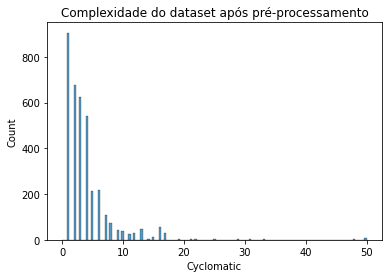

In [363]:
print('Dataset size: ', dataset.shape[0])
print('Média complexidade dataset balanceado: ', dataset['Cyclomatic'].mean())
plt.title("Complexidade do dataset após pré-processamento")
sns.histplot(dataset['Cyclomatic'])
plt.show()

# Características do dataset original

[Text(0.5, 0, 'Total'), Text(0, 0.5, 'Cyclomatic')]

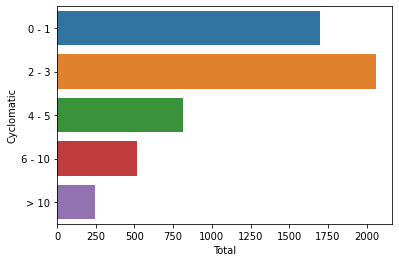

In [926]:
def get_level_of_cyclomatic(level):
    if level <= 1:
        return '0 - 1'
    elif level <= 3:
        return '2 - 3'
    elif level <= 5:
        return '4 - 5'
    elif level <= 10:
        return '6 - 10'

    return '> 10'

d_tmp = dataset_original
d_tmp['Cyclomatic_Level'] = dataset_original['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 1', '2 - 3', '4 - 5', '6 - 10', '> 10'])
ax.set(xlabel='Total', ylabel='Cyclomatic')

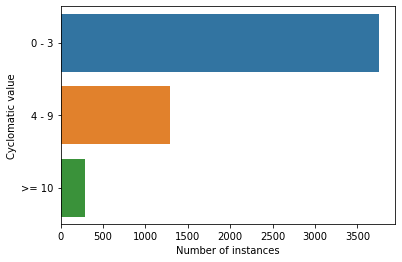

In [927]:
def get_level_of_cyclomatic(level):
    if level <= 3:
        return '0 - 3'
    elif level <= 9:
        return '4 - 9'

    return '>= 10'


d_tmp = dataset_original
d_tmp['Cyclomatic_Level'] = dataset_original['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 3', '4 - 9', '>= 10'])
ax.set(xlabel='Number of instances', ylabel='Cyclomatic value')
plt.savefig('cyclomatic-chart-noprocessing.png', dpi=300)

[Text(0.5, 0, 'Total'), Text(0, 0.5, 'Cyclomatic')]

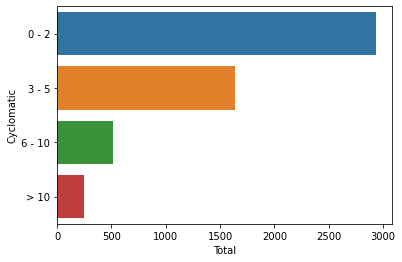

In [928]:
def get_level_of_cyclomatic(level):
    if level <= 2:
        return '0 - 2'
    elif level <= 5:
        return '3 - 5'
    elif level <= 10:
        return '6 - 10'

    return '> 10'

d_tmp = dataset_original
d_tmp['Cyclomatic_Level'] = dataset_original['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 2', '3 - 5', '6 - 10', '> 10'])
ax.set(xlabel='Total', ylabel='Cyclomatic')

Dataset size:  5342
Média complexidade dataset:  3.3569824035941593


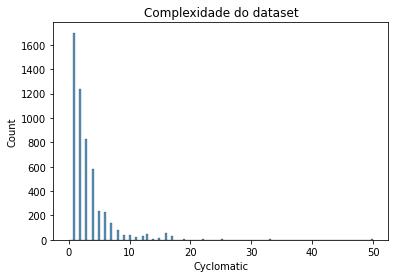

In [929]:
print('Dataset size: ', dataset_original.shape[0])
print('Média complexidade dataset: ', dataset_original['Cyclomatic'].mean())
plt.title("Complexidade do dataset")
sns.histplot(dataset_original['Cyclomatic'])
plt.show()

<AxesSubplot:title={'center':'Contribuição de cada projeto no dataset após pré-processamento'}, xlabel='count', ylabel='Project'>

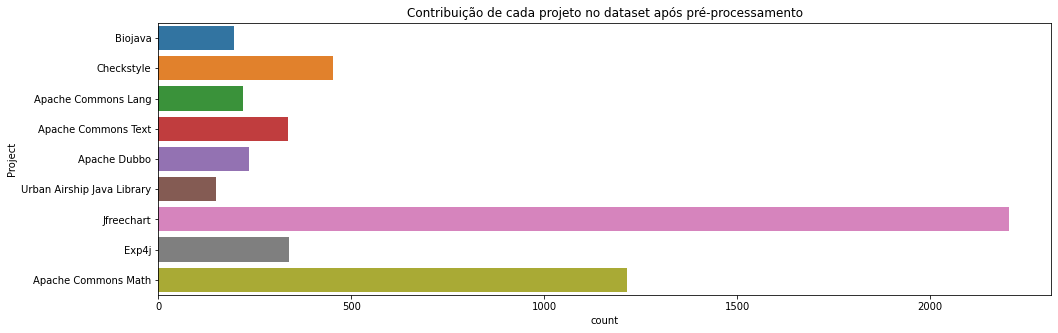

In [930]:
def signature_to_project(signature):
    project = ''
    
    if 'com.puppycrawl.tools.checkstyle' in signature:
        project = 'Checkstyle'
    elif 'exp4j' in signature:
        project = 'Exp4j'
    elif 'biojava' in signature:
        project = 'Biojava'
    elif 'org.jfree' in signature:
        project = 'Jfreechart'
    elif 'com.urbanairship' in signature:
        project = 'Urban Airship Java Library'
    elif 'org.apache.commons.text' in signature:
        project = 'Apache Commons Text'
    elif 'dubbo' in signature:
        project = 'Apache Dubbo'
    elif 'org.apache.commons.lang3' in signature:
        project = 'Apache Commons Lang'
    elif 'math3' in signature:
        project = 'Apache Commons Math'
        
    return project

d2 = dataset_original
d2['Project'] = dataset_original['Name'].apply(signature_to_project)
plt.figure(figsize=(16,5))
plt.title("Contribuição de cada projeto no dataset após pré-processamento")

contrib_projetos = d2.groupby('Project')
contrib_projetos = contrib_projetos.count()

sns.countplot(y='Project', data=d2, orient='h')

<AxesSubplot:title={'center':'Correlação das métricas'}>

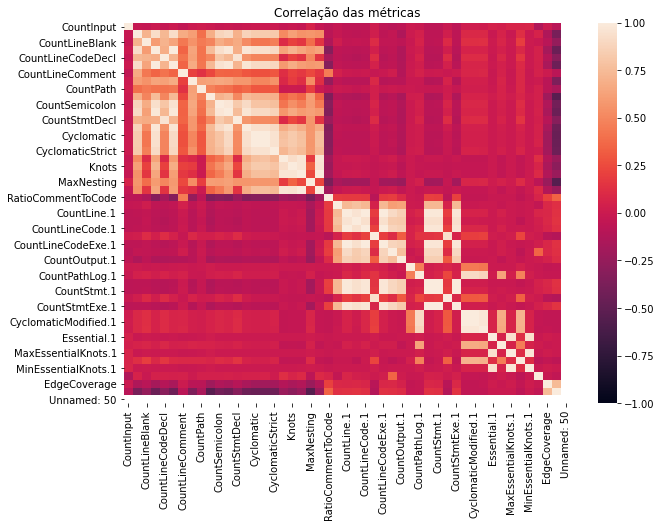

In [931]:
plt.figure(figsize=(10,7))
plt.title("Correlação das métricas")
sns.heatmap(dataset_original.corr(), vmin=-1, vmax=1)

<AxesSubplot:title={'center':'Contribuição de cada projeto no dataset após pré-processamento'}, xlabel='count', ylabel='Project'>

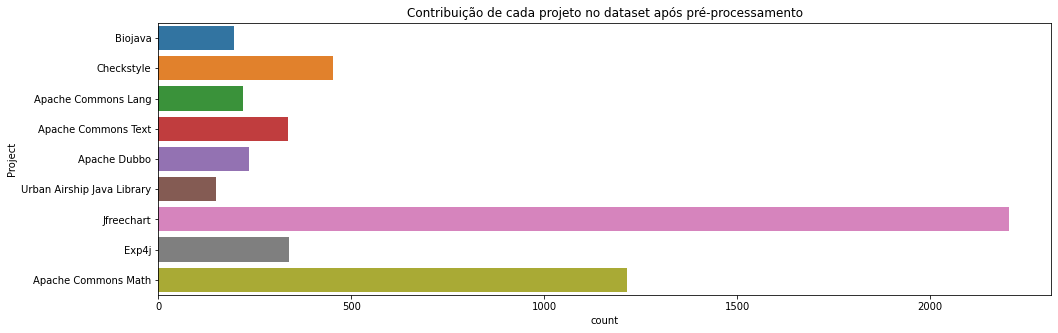

In [932]:
def signature_to_project(signature):
    project = ''
    
    if 'com.puppycrawl.tools.checkstyle' in signature:
        project = 'Checkstyle'
    elif 'exp4j' in signature:
        project = 'Exp4j'
    elif 'biojava' in signature:
        project = 'Biojava'
    elif 'org.jfree' in signature:
        project = 'Jfreechart'
    elif 'com.urbanairship' in signature:
        project = 'Urban Airship Java Library'
    elif 'org.apache.commons.text' in signature:
        project = 'Apache Commons Text'
    elif 'dubbo' in signature:
        project = 'Apache Dubbo'
    elif 'org.apache.commons.lang3' in signature:
        project = 'Apache Commons Lang'
    elif 'math3' in signature:
        project = 'Apache Commons Math'
        
    return project

d2 = dataset_original
d2['Project'] = dataset_original['Name'].apply(signature_to_project)
plt.figure(figsize=(16,5))
plt.title("Contribuição de cada projeto no dataset após pré-processamento")

contrib_projetos = d2.groupby('Project')
contrib_projetos = contrib_projetos.count()

sns.countplot(y='Project', data=d2, orient='h')

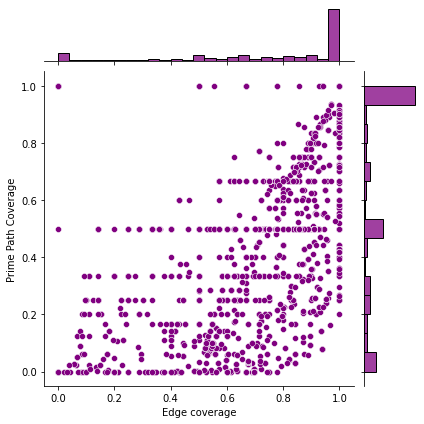

In [933]:
ax = sns.jointplot(x='EdgeCoverage', y='PrimePathCoverage', data=dataset_original, kind='scatter', color='purple')
ax.set_axis_labels('Edge coverage', 'Prime Path Coverage')
plt.show(ax)

# Características do dataset após pré-processamento

In [1140]:
print('Repeated registers:', dataset[dataset.duplicated()].shape[0])

Repeated registers: 0


[Text(0.5, 0, 'Total'), Text(0, 0.5, 'Cyclomatic')]

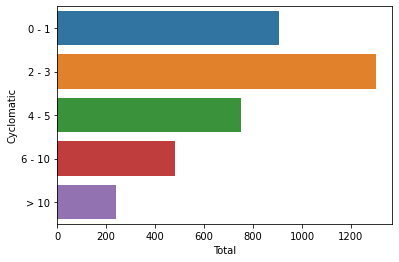

In [364]:
def get_level_of_cyclomatic(level):
    if level <= 1:
        return '0 - 1'
    elif level <= 3:
        return '2 - 3'
    elif level <= 5:
        return '4 - 5'
    elif level <= 10:
        return '6 - 10'

    #elif level <= 20:
    #    return '16 - 20'
    
    return '> 10'


d_tmp = dataset
d_tmp['Cyclomatic_Level'] = dataset['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 1', '2 - 3', '4 - 5', '6 - 10', '> 10'])
ax.set(xlabel='Total', ylabel='Cyclomatic')

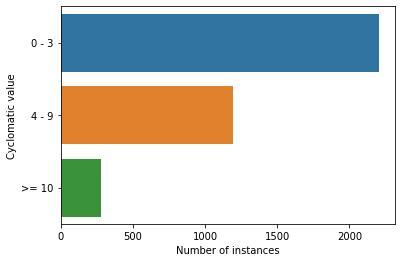

In [365]:
def get_level_of_cyclomatic(level):
    if level <= 3:
        return '0 - 3'
    elif level <= 9:
        return '4 - 9'

    return '>= 10'


d_tmp = dataset
d_tmp['Cyclomatic_Level'] = dataset['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 3', '4 - 9', '>= 10'])
ax.set(xlabel='Number of instances', ylabel='Cyclomatic value')
plt.savefig('cyclomatic-chart-preprocessing.png', dpi=300)

[Text(0.5, 0, 'Total'), Text(0, 0.5, 'Cyclomatic')]

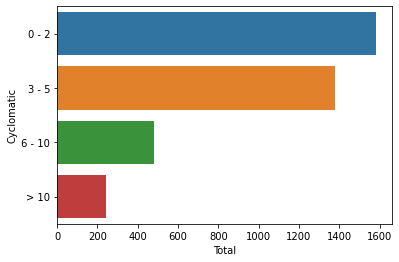

In [366]:
def get_level_of_cyclomatic(level):
    if level <= 2:
        return '0 - 2'
    elif level <= 5:
        return '3 - 5'
    elif level <= 10:
        return '6 - 10'

    return '> 10'

d_tmp = dataset
d_tmp['Cyclomatic_Level'] = dataset['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 2', '3 - 5', '6 - 10', '> 10'])
ax.set(xlabel='Total', ylabel='Cyclomatic')

Dataset size:  3681
Média complexidade dataset balanceado:  4.005433306166802


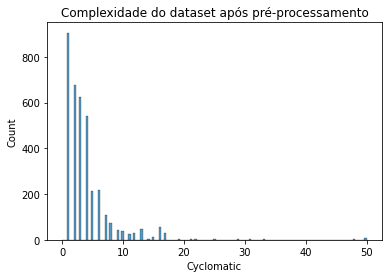

In [367]:
print('Dataset size: ', dataset.shape[0])
print('Média complexidade dataset balanceado: ', dataset['Cyclomatic'].mean())
plt.title("Complexidade do dataset após pré-processamento")
sns.histplot(dataset['Cyclomatic'])
plt.show()

<AxesSubplot:title={'center':'Contribuição de cada projeto no dataset após pré-processamento'}, xlabel='count', ylabel='Project'>

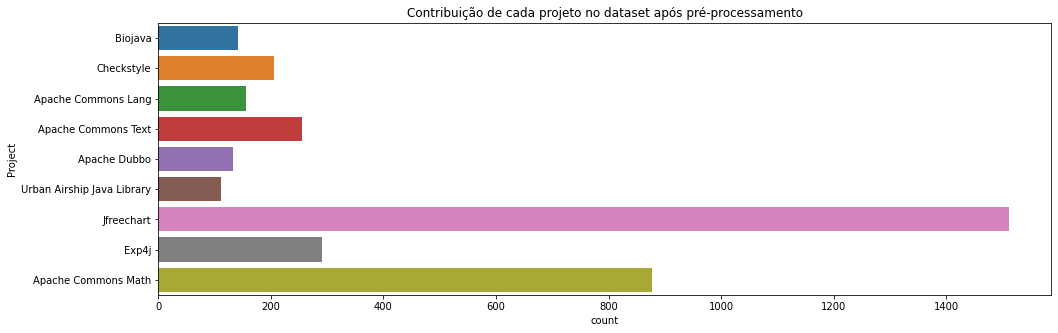

In [368]:
def signature_to_project(signature):
    project = ''
    
    if 'com.puppycrawl.tools.checkstyle' in signature:
        project = 'Checkstyle'
    elif 'exp4j' in signature:
        project = 'Exp4j'
    elif 'biojava' in signature:
        project = 'Biojava'
    elif 'org.jfree' in signature:
        project = 'Jfreechart'
    elif 'com.urbanairship' in signature:
        project = 'Urban Airship Java Library'
    elif 'org.apache.commons.text' in signature:
        project = 'Apache Commons Text'
    elif 'dubbo' in signature:
        project = 'Apache Dubbo'
    elif 'org.apache.commons.lang3' in signature:
        project = 'Apache Commons Lang'
    elif 'math3' in signature:
        project = 'Apache Commons Math'
        
    return project

d2 = dataset
d2['Project'] = dataset['Name'].apply(signature_to_project)
plt.figure(figsize=(16,5))
plt.title("Contribuição de cada projeto no dataset após pré-processamento")

contrib_projetos = d2.groupby('Project')
contrib_projetos = contrib_projetos.count()

sns.countplot(y='Project', data=d2, orient='h')

<AxesSubplot:title={'center':'Complexidade do dataset após pré-processamento por projeto'}, xlabel='count', ylabel='Project'>

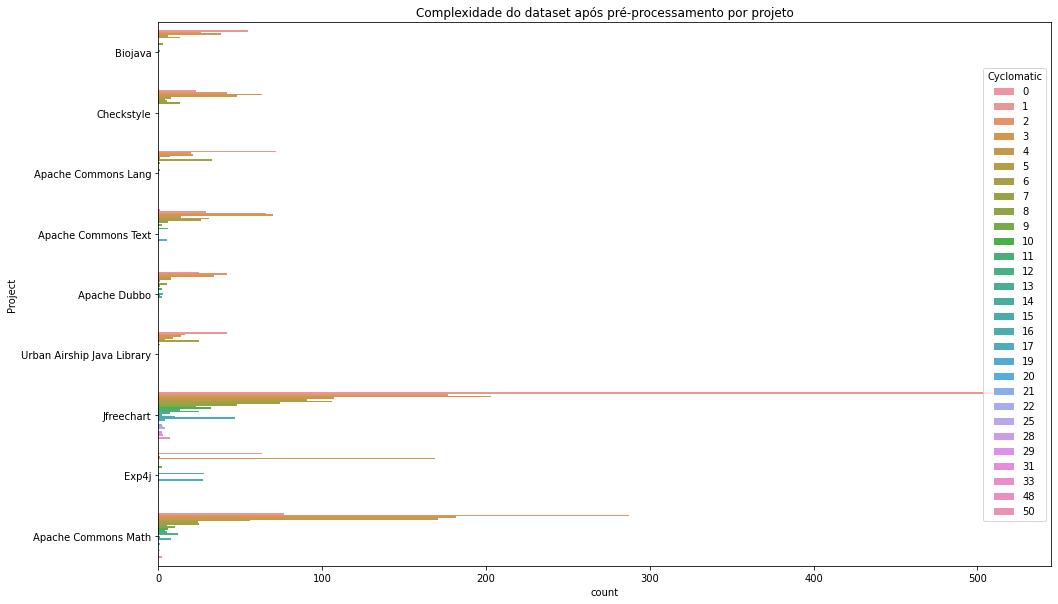

In [369]:
plt.figure(figsize=(16,10))
plt.title('Complexidade do dataset após pré-processamento por projeto')
sns.countplot(y='Project', data=d2, orient='h', hue='Cyclomatic')

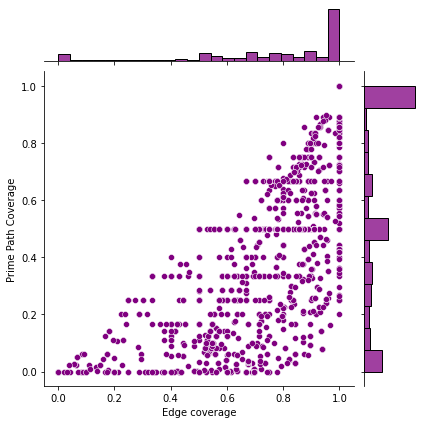

In [370]:
ax = sns.jointplot(x='EdgeCoverage', y='PrimePathCoverage', data=dataset, kind='scatter', color='purple')
ax.set_axis_labels('Edge coverage', 'Prime Path Coverage')
plt.savefig('ec-ppc.png', dpi=300)
plt.show(ax)

<AxesSubplot:title={'center':'Correlação das métricas após pré-processamento'}>

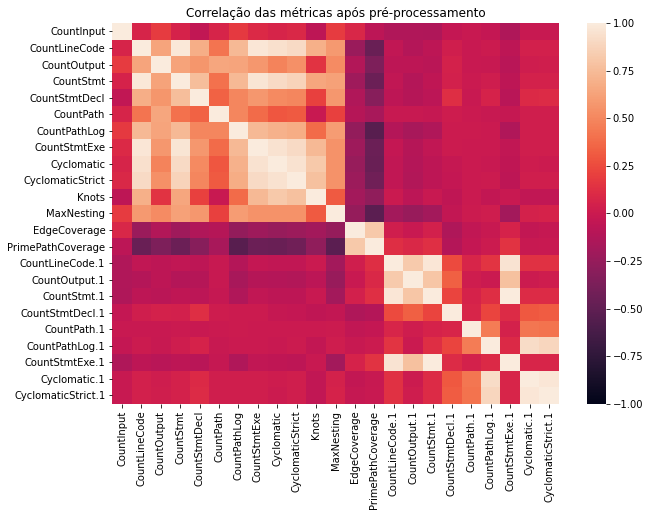

In [371]:
plt.figure(figsize=(10,7))
plt.title("Correlação das métricas após pré-processamento")
sns.heatmap(dataset.corr(), vmin=-1, vmax=1)

,Metrics,Correlation
12,EdgeCoverage,0.816491
19,CountStmtExe.1,0.142334
15,CountStmt.1,0.125417
13,CountLineCode.1,0.118900
14,CountOutput.1,0.086368
18,CountPathLog.1,0.002803
21,CyclomaticStrict.1,-0.014291
20,Cyclomatic.1,-0.018177
17,CountPath.1,-0.033461
0,CountInput,-0.076267


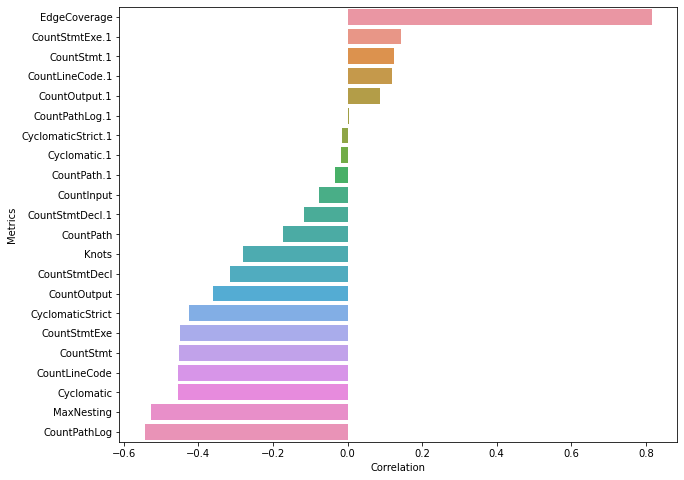

In [372]:
correlations = dataset.corr()['PrimePathCoverage']
correlations = correlations.drop('PrimePathCoverage')

metrics = correlations.index
ppc_corr = correlations.values
corr_table = pd.DataFrame(columns=['Metrics', 'Correlation'])
corr_table['Metrics'] = metrics
corr_table['Correlation'] = ppc_corr
corr_table = corr_table.sort_values(ascending=False, by='Correlation')

plt.figure(figsize=(10,8))
sns.barplot(y='Metrics', x='Correlation', data=corr_table)

display(corr_table)

In [328]:
d_groupby = d2.groupby('Project')
d_groupby['Cyclomatic'].describe()

,count,mean,std,min,25%,50%,75%,max
Project,,,,,,,,
Apache Commons Lang,174.0,2.551724,2.094632,1.0,1.0,1.0,3.0,12.0
Apache Commons Math,945.0,3.523810,3.349316,1.0,2.0,3.0,4.0,48.0
Apache Commons Text,278.0,3.582734,2.909959,0.0,2.0,3.0,5.0,19.0
Apache Dubbo,155.0,3.135484,2.984978,1.0,2.0,2.0,3.0,16.0
Biojava,157.0,2.363057,1.772847,1.0,1.0,2.0,3.0,13.0
Checkstyle,227.0,3.176211,1.771145,1.0,2.0,3.0,4.0,8.0
Exp4j,304.0,5.253289,4.839843,1.0,1.0,4.0,4.0,17.0
Jfreechart,1684.0,4.130048,5.204922,1.0,1.0,2.0,5.0,50.0
Urban Airship Java Library,122.0,2.795082,2.028469,1.0,1.0,2.0,4.0,8.0


In [1152]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4046 entries, 0 to 5340
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                4046 non-null   object 
 1   CountInput          4046 non-null   int64  
 2   CountLineCode       4046 non-null   int64  
 3   CountOutput         4046 non-null   int64  
 4   CountStmt           4046 non-null   int64  
 5   CountStmtDecl       4046 non-null   int64  
 6   CountPath           4046 non-null   int64  
 7   CountPathLog        4046 non-null   int64  
 8   CountStmtExe        4046 non-null   int64  
 9   Cyclomatic          4046 non-null   int64  
 10  CyclomaticStrict    4046 non-null   int64  
 11  Knots               4046 non-null   int64  
 12  MaxNesting          4046 non-null   int64  
 13  EdgeCoverage        4046 non-null   float64
 14  PrimePathCoverage   4046 non-null   float64
 15  Name.1              4046 non-null   object 
 16  CountL

In [1153]:
dataset.describe()

,CountInput,CountLineCode,CountOutput,CountStmt,CountStmtDecl,CountPath,CountPathLog,CountStmtExe,Cyclomatic,CyclomaticStrict,...,PrimePathCoverage,CountLineCode.1,CountOutput.1,CountStmt.1,CountStmtDecl.1,CountPath.1,CountPathLog.1,CountStmtExe.1,Cyclomatic.1,CyclomaticStrict.1
count,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,...,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000
mean,22.466387,15.351211,5.390262,10.877410,2.961691,65.404103,0.473554,7.915719,3.766930,4.265447,...,0.619916,23.134207,9.707118,18.627533,4.422392,396.766930,0.083786,14.205141,1.404597,1.421898
std,39.676463,16.906695,4.965761,11.620441,3.618694,623.212835,0.675305,9.159057,4.196567,5.094919,...,0.362580,32.446400,8.965253,28.251063,3.230461,14275.007009,0.372277,27.780028,1.226880,1.281881
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,5.000000,6.000000,3.000000,4.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,...,0.333300,9.000000,5.000000,7.000000,3.000000,1.000000,0.000000,3.000000,1.000000,1.000000
50%,9.000000,11.000000,4.000000,7.000000,2.000000,3.000000,0.000000,5.000000,3.000000,3.000000,...,0.636400,14.000000,7.000000,11.000000,3.000000,1.000000,0.000000,6.000000,1.000000,1.000000
75%,20.000000,17.000000,7.000000,13.000000,3.000000,6.000000,1.000000,10.000000,4.000000,5.000000,...,1.000000,23.000000,11.000000,19.000000,5.000000,1.000000,0.000000,13.000000,1.000000,1.000000
max,201.000000,225.000000,58.000000,144.000000,49.000000,12240.000000,4.000000,99.000000,50.000000,72.000000,...,1.000000,273.000000,70.000000,230.000000,32.000000,524288.000000,6.000000,226.000000,20.000000,20.000000


# Funções uteis

In [412]:
k = 10
metricas_erro = [
    'r2', 'max_error', 'neg_mean_absolute_error',
    'neg_mean_squared_error', 'neg_root_mean_squared_error',
    'neg_mean_squared_log_error', 'neg_median_absolute_error'
]
previsores = [
    # Método testado
    'CountInput','CountLineCode',
    'CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticStrict',
    'Knots','MaxNesting','EdgeCoverage',
    
    # Método de teste
    'CountLineCode.1',
    'CountOutput.1','CountStmt.1',
    'CountStmtDecl.1','CountPath.1','CountPathLog.1','CountStmtExe.1',
    'Cyclomatic.1','CyclomaticStrict.1'
]

previsores_sem_ec = previsores.copy()
previsores_sem_ec.remove('EdgeCoverage')

In [413]:
def feature_importance_of(regressor_model, previsores, ppc, previsores_nome):
    results = permutation_importance(regressor_model, previsores, ppc, scoring='neg_mean_squared_error')  
    importance = results.importances_mean

    return importance

In [414]:
def escalonador(dados):
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    return scaler.fit_transform(dados)

def evaluate(previsores, classificador, d = dataset, k=10, apenas_escalonamento=False, display_prediction=False, display_feature_importance=False):
    ppc = d['PrimePathCoverage'].values
    previsores_content = d[previsores].values
    
    error_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=['no_scaled', 'scaled']
    )
    

    if not apenas_escalonamento:
        resultados = cross_validate(
                classificador, 
                previsores_content, 
                ppc, 
                cv=k, 
                scoring=metricas_erro, 
                return_estimator=True
        )
        error_metrics_table['no_scaled']['Mean Abs Error'] = abs(resultados['test_neg_mean_absolute_error'].mean())
        error_metrics_table['no_scaled']['Mean Sqr Error'] = abs(resultados['test_neg_mean_squared_error'].mean())
        error_metrics_table['no_scaled']['Mean Sqr Log Error'] = abs(resultados['test_neg_mean_squared_log_error'].mean())
        error_metrics_table['no_scaled']['Mean Median Error'] = abs(resultados['test_neg_median_absolute_error'].mean())
        error_metrics_table['no_scaled']['R2 Score'] = abs(resultados['test_r2'].mean())
        
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )
    error_metrics_table['scaled']['Mean Abs Error'] = abs(resultados_escalonados['test_neg_mean_absolute_error'].mean())
    error_metrics_table['scaled']['Mean Sqr Error'] = abs(resultados_escalonados['test_neg_mean_squared_error'].mean())
    error_metrics_table['scaled']['Mean Sqr Log Error'] = abs(resultados_escalonados['test_neg_mean_squared_log_error'].mean())
    error_metrics_table['scaled']['Mean Median Error'] = abs(resultados_escalonados['test_neg_median_absolute_error'].mean())
    error_metrics_table['scaled']['R2 Score'] = abs(resultados_escalonados['test_r2'].mean())
    
    if display_prediction:
        k_current = 0
        for estimator in resultados_escalonados['estimator']:
            ppc_predict = estimator.predict(escalonador(previsores_content))
            predict_table = pd.DataFrame(index=[i for i in range(len(ppc_predict))],columns=['PPC correct', 'PPC predict', 'MAE'])

            for i in range(len(ppc_predict)):
                predict_table['PPC correct'][i] = ppc[i]
                predict_table['PPC predict'][i] = ppc_predict[i]
                predict_table['MAE'][i] = abs(ppc[i] - ppc_predict[i])
                #print(ppc_predict[i], ppc[i])
            print('k:', k_current)
            display(predict_table)
            k_current += 1
    
    if display_feature_importance:
        k_current = 0
        columns = [i for i in range(k)]
        columns.append('Mean')
        fi_scaled_table = pd.DataFrame(columns=columns, index=d[previsores].columns)
        
        for estimator in resultados_escalonados['estimator']:
            fi_scaled_table[k_current] = feature_importance_of(
                estimator, escalonador(previsores_content), ppc, d[previsores].columns
            )
            k_current += 1
            
        for i in range(fi_scaled_table.shape[0]):
            fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()
        

        fi_final = pd.DataFrame(columns=['Metrics', 'Importance'])
        fi_final['Metrics'] = fi_scaled_table.index.values
        fi_final['Importance'] = fi_scaled_table['Mean'].values

        fi_final = fi_final.sort_values(ascending=False, by='Importance')
        display(fi_final)
        plt.figure(figsize=(12,8))
        plt.title("Feature importance - K = " + str(k) + " - Mean")
        plt.axis([0, fi_final['Importance'].values.max(), 0, len(fi_final.index.values)])
        sns.barplot(y=fi_final['Metrics'].values, x=fi_final['Importance'].values, orient='h')
        plt.show()

    
    return error_metrics_table

In [415]:
def feature_importance(classificador, d = dataset, prev = previsores):
    ppc = d['PrimePathCoverage'].values
    importance_dataset = pd.DataFrame(
            [0]*len(prev),
            index=prev,
            columns=['importance']
    )
    previsores_content = d[prev].values
    resultados = cross_validate(
            classificador, 
            previsores_content, 
            ppc, 
            cv=k, 
            scoring=metricas_erro,
            return_estimator=True
    )
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro,
            return_estimator=True
    )
    
    print('-----< SEM ESCALONAMENTO >-----')
    #print(resultados)
    for idx,estimator in enumerate(resultados['estimator']):
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                           index=prev,
                                           columns=['importance'])
        importance_dataset += feature_importances
 
    #print(importance_dataset) 
    importance_dataset['mean'] = importance_dataset['importance'] / k
    plt.figure(figsize=(10,9))
    plt.title("Feature importance - Random forest - K = 10 - Mean")
    plt.barh(prev, importance_dataset['mean'].values)
    plt.show()
    
    importance_dataset = pd.DataFrame(
            [0]*len(prev),
            index=prev,
            columns=['importance']
    )
    print('\n')
    
    print('-----< COM ESCALONAMENTO >-----')
    for idx,estimator in enumerate(resultados_escalonados['estimator']):
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                           index=prev,
                                           columns=['importance'])
        importance_dataset += feature_importances

    importance_dataset['mean'] = importance_dataset['importance'] / k
    print(importance_dataset['mean'].sort_values(ascending=False))
    plt.figure(figsize=(10,9))
    plt.title("Feature importance - Random forest - K = 10 - Mean")
    plt.barh(prev, importance_dataset['mean'].values)
    plt.show()

In [416]:
def estimator_metrics_to_dataframe(estimator_results, dataframe):
    dataframe['Mean']['Mean Abs Error'] = estimator_results.iloc[0,:-1].mean()
    dataframe['Mean']['Mean Sqr Error'] = estimator_results.iloc[1,:-1].mean()
    dataframe['Mean']['Mean Sqr Log Error'] = estimator_results.iloc[2,:-1].mean()
    dataframe['Mean']['Mean Median Error'] = estimator_results.iloc[3,:-1].mean()
    dataframe['Mean']['R2 Score'] = estimator_results.iloc[4,:-1].mean()

# Experimentos

## Linear Regression

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
12,EdgeCoverage,0.112894
19,CountStmtExe.1,0.00128798
14,CountOutput.1,7.4514e-06
13,CountLineCode.1,3.4024e-08
0,CountInput,0
10,Knots,0
20,Cyclomatic.1,0
16,CountStmtDecl.1,0
15,CountStmt.1,0
1,CountLineCode,0


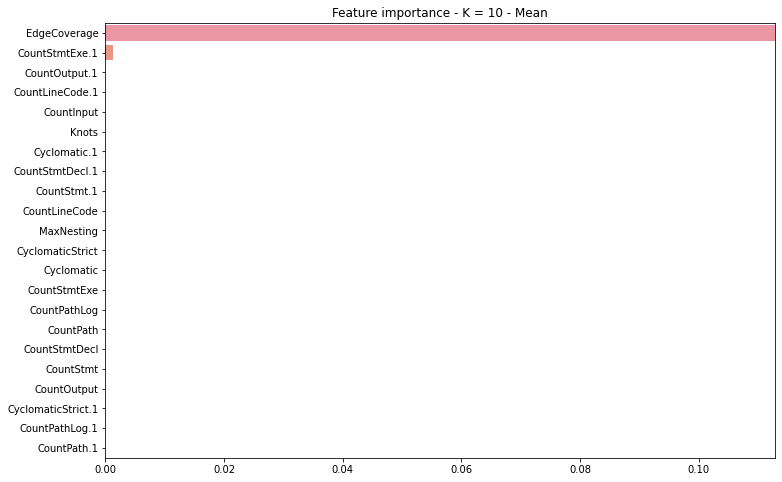

,no_scaled,scaled
Mean Abs Error,NaN,NaN
Mean Sqr Error,NaN,NaN
Mean Sqr Log Error,NaN,NaN
Mean Median Error,NaN,NaN
R2 Score,NaN,NaN


In [24]:
evaluate(previsores, LinearRegression(positive=True), display_feature_importance=True)

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
18,CountStmtExe.1,0.00614666
13,CountOutput.1,0.00033824
12,CountLineCode.1,3.58007e-06
0,CountInput,0
1,CountLineCode,0
19,Cyclomatic.1,0
17,CountPathLog.1,0
15,CountStmtDecl.1,0
14,CountStmt.1,0
11,MaxNesting,0


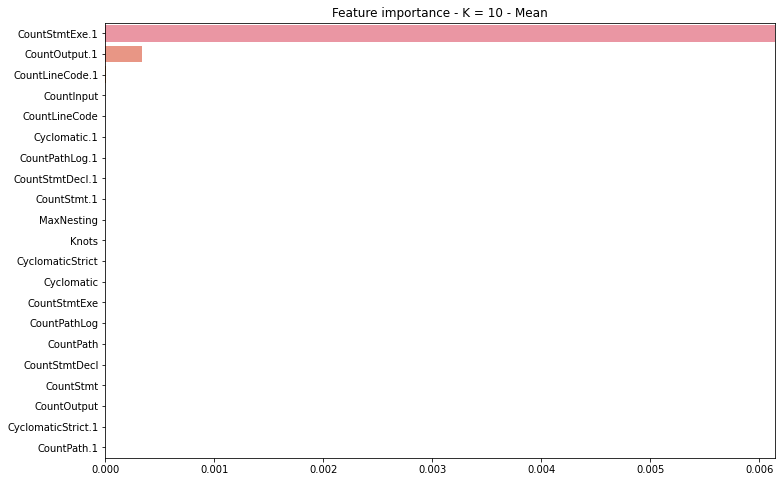

,no_scaled,scaled
Mean Abs Error,0.297273,0.297273
Mean Sqr Error,0.130122,0.130122
Mean Sqr Log Error,0.0507882,0.0507882
Mean Median Error,0.311615,0.311615
R2 Score,0.177976,0.177976


In [25]:
evaluate(previsores_sem_ec, LinearRegression(positive=True), display_feature_importance=True)

### Com EC

In [26]:
error_metrics_table = pd.DataFrame(
    index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
    columns=previsores
)

for previsor in previsores:
    print('PREVISOR ', previsor)
    metrics = evaluate([
        previsor
    ], LinearRegression(positive=True), dataset)
    error_metrics_table[previsor] = metrics['scaled']
    display(metrics)
    print('\n')

PREVISOR  CountInput


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountLineCode


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountOutput


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmt


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmtDecl


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPath


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPathLog


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmtExe


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  Cyclomatic


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CyclomaticStrict


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  Knots


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  MaxNesting


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  EdgeCoverage


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

,no_scaled,scaled
Mean Abs Error,NaN,NaN
Mean Sqr Error,NaN,NaN
Mean Sqr Log Error,NaN,NaN
Mean Median Error,NaN,NaN
R2 Score,NaN,NaN




PREVISOR  CountLineCode.1


,no_scaled,scaled
Mean Abs Error,0.294229,0.294229
Mean Sqr Error,0.113319,0.113319
Mean Sqr Log Error,0.0494709,0.0494709
Mean Median Error,0.307604,0.307604
R2 Score,0.0317703,0.0317703




PREVISOR  CountOutput.1


,no_scaled,scaled
Mean Abs Error,0.294844,0.294844
Mean Sqr Error,0.114245,0.114245
Mean Sqr Log Error,0.0499953,0.0499953
Mean Median Error,0.307665,0.307665
R2 Score,0.0398916,0.0398916




PREVISOR  CountStmt.1


,no_scaled,scaled
Mean Abs Error,0.294491,0.294491
Mean Sqr Error,0.113397,0.113397
Mean Sqr Log Error,0.0494741,0.0494741
Mean Median Error,0.308865,0.308865
R2 Score,0.0299882,0.0299882




PREVISOR  CountStmtDecl.1


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPath.1


,no_scaled,scaled
Mean Abs Error,0.330616,0.330616
Mean Sqr Error,1.48944,1.48944
Mean Sqr Log Error,0.0581882,0.0581882
Mean Median Error,0.32638,0.32638
R2 Score,12.1851,12.1851




PREVISOR  CountPathLog.1


,no_scaled,scaled
Mean Abs Error,0.302088,0.302088
Mean Sqr Error,0.116794,0.116794
Mean Sqr Log Error,0.050945,0.050945
Mean Median Error,0.326448,0.326448
R2 Score,0.052479,0.052479




PREVISOR  CountStmtExe.1


,no_scaled,scaled
Mean Abs Error,0.293639,0.293639
Mean Sqr Error,0.113051,0.113051
Mean Sqr Log Error,0.0492599,0.0492599
Mean Median Error,0.311154,0.311154
R2 Score,0.0261972,0.0261972




PREVISOR  Cyclomatic.1


,no_scaled,scaled
Mean Abs Error,0.301998,0.301998
Mean Sqr Error,0.116761,0.116761
Mean Sqr Log Error,0.0509288,0.0509288
Mean Median Error,0.325733,0.325733
R2 Score,0.0521811,0.0521811




PREVISOR  CyclomaticStrict.1


,no_scaled,scaled
Mean Abs Error,0.302071,0.302071
Mean Sqr Error,0.11679,0.11679
Mean Sqr Log Error,0.0509428,0.0509428
Mean Median Error,0.326083,0.326083
R2 Score,0.0524417,0.0524417


C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Linear Regression - R2 Score'}>

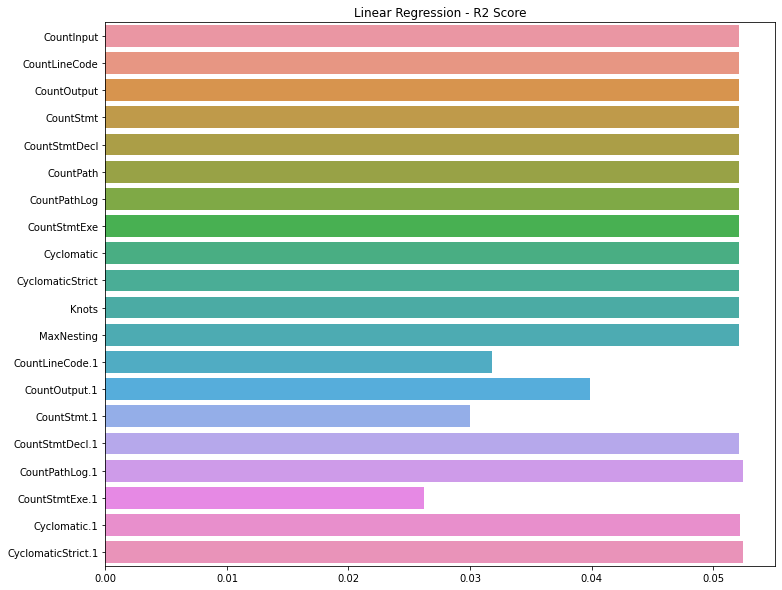

In [27]:
error_metrics = error_metrics_table.iloc[-1,:].dropna()
error_metrics = error_metrics[error_metrics < 1]
y_axis = error_metrics.values
x_axis = error_metrics.index.values
plt.figure(figsize=(12,10))
plt.title('Linear Regression - R2 Score')
sns.barplot(y_axis, x_axis)

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Linear Regression - MSE'}>

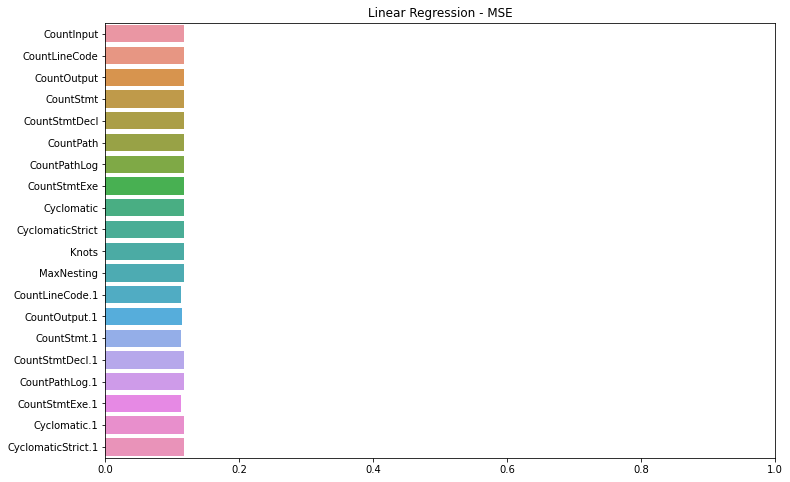

In [28]:
error_metrics = error_metrics_table.iloc[1,:].dropna()
error_metrics = error_metrics[error_metrics < 1]
y_axis = error_metrics.values
x_axis = error_metrics.index.values
plt.figure(figsize=(12,8))
plt.axis([0, 1, 0, len(x_axis)])
plt.title('Linear Regression - MSE')
sns.barplot(y_axis, x_axis)

In [29]:
evaluate([
    'EdgeCoverage'
], LinearRegression(fit_intercept=False), dataset)

,no_scaled,scaled
Mean Abs Error,0.206974,0.206974
Mean Sqr Error,0.0620772,0.0620772
Mean Sqr Log Error,0.029046,0.029046
Mean Median Error,0.212136,0.212136
R2 Score,0.441571,0.441571


In [30]:
evaluate([
    'MaxNesting'
], LinearRegression(fit_intercept=False), dataset)

,no_scaled,scaled
Mean Abs Error,0.495413,0.495413
Mean Sqr Error,0.377472,0.377472
Mean Sqr Log Error,0.178821,0.178821
Mean Median Error,0.406899,0.406899
R2 Score,2.51427,2.51427


### Sem EC

In [31]:
error_metrics_table = pd.DataFrame(
    index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
    columns=previsores
)

for previsor in previsores:
    if previsor == 'EdgeCoverage':
        continue
        
    print('PREVISOR ', previsor)
    metrics = evaluate([
        previsor
    ], LinearRegression(positive=True), dataset)
    error_metrics_table[previsor] = metrics['scaled']
    display(metrics)
    print('\n')

PREVISOR  CountInput


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountLineCode


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountOutput


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmt


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmtDecl


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPath


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPathLog


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmtExe


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  Cyclomatic


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CyclomaticStrict


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  Knots


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  MaxNesting


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountLineCode.1


,no_scaled,scaled
Mean Abs Error,0.294229,0.294229
Mean Sqr Error,0.113319,0.113319
Mean Sqr Log Error,0.0494709,0.0494709
Mean Median Error,0.307604,0.307604
R2 Score,0.0317703,0.0317703




PREVISOR  CountOutput.1


,no_scaled,scaled
Mean Abs Error,0.294844,0.294844
Mean Sqr Error,0.114245,0.114245
Mean Sqr Log Error,0.0499953,0.0499953
Mean Median Error,0.307665,0.307665
R2 Score,0.0398916,0.0398916




PREVISOR  CountStmt.1


,no_scaled,scaled
Mean Abs Error,0.294491,0.294491
Mean Sqr Error,0.113397,0.113397
Mean Sqr Log Error,0.0494741,0.0494741
Mean Median Error,0.308865,0.308865
R2 Score,0.0299882,0.0299882




PREVISOR  CountStmtDecl.1


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPath.1


,no_scaled,scaled
Mean Abs Error,0.330616,0.330616
Mean Sqr Error,1.48944,1.48944
Mean Sqr Log Error,0.0581882,0.0581882
Mean Median Error,0.32638,0.32638
R2 Score,12.1851,12.1851




PREVISOR  CountPathLog.1


,no_scaled,scaled
Mean Abs Error,0.302088,0.302088
Mean Sqr Error,0.116794,0.116794
Mean Sqr Log Error,0.050945,0.050945
Mean Median Error,0.326448,0.326448
R2 Score,0.052479,0.052479




PREVISOR  CountStmtExe.1


,no_scaled,scaled
Mean Abs Error,0.293639,0.293639
Mean Sqr Error,0.113051,0.113051
Mean Sqr Log Error,0.0492599,0.0492599
Mean Median Error,0.311154,0.311154
R2 Score,0.0261972,0.0261972




PREVISOR  Cyclomatic.1


,no_scaled,scaled
Mean Abs Error,0.301998,0.301998
Mean Sqr Error,0.116761,0.116761
Mean Sqr Log Error,0.0509288,0.0509288
Mean Median Error,0.325733,0.325733
R2 Score,0.0521811,0.0521811




PREVISOR  CyclomaticStrict.1


,no_scaled,scaled
Mean Abs Error,0.302071,0.302071
Mean Sqr Error,0.11679,0.11679
Mean Sqr Log Error,0.0509428,0.0509428
Mean Median Error,0.326083,0.326083
R2 Score,0.0524417,0.0524417


### Apenas EC

In [32]:
evaluate([
    'EdgeCoverage'
], LinearRegression(fit_intercept=False), dataset)

,no_scaled,scaled
Mean Abs Error,0.206974,0.206974
Mean Sqr Error,0.0620772,0.0620772
Mean Sqr Log Error,0.029046,0.029046
Mean Median Error,0.212136,0.212136
R2 Score,0.441571,0.441571


## SVR

In [33]:
def evaluate_svr(metrics, epsilon = 0.1, tot_seeds=0, display_feature_importance=False):
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=[0, 'Mean']
    )
    
    error_scaled_metrics_table.index.name = 'Error metrics'
    error_scaled_metrics_table.columns.name = 'Seed'

    error_metrics = evaluate(metrics, SVR(epsilon=epsilon), dataset, apenas_escalonamento=True, display_feature_importance=display_feature_importance)
    error_scaled_metrics_table[0] = error_metrics['scaled']
    estimator_metrics_to_dataframe(error_metrics, error_scaled_metrics_table)

    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

,Metrics,Importance
12,EdgeCoverage,0.0858965
6,CountPathLog,0.00870845
11,MaxNesting,0.00430722
7,CountStmtExe,0.00382408
3,CountStmt,0.00333331
4,CountStmtDecl,0.0029799
9,CyclomaticStrict,0.00278582
15,CountStmt.1,0.00104377
19,CountStmtExe.1,0.00100108
8,Cyclomatic,0.000949374


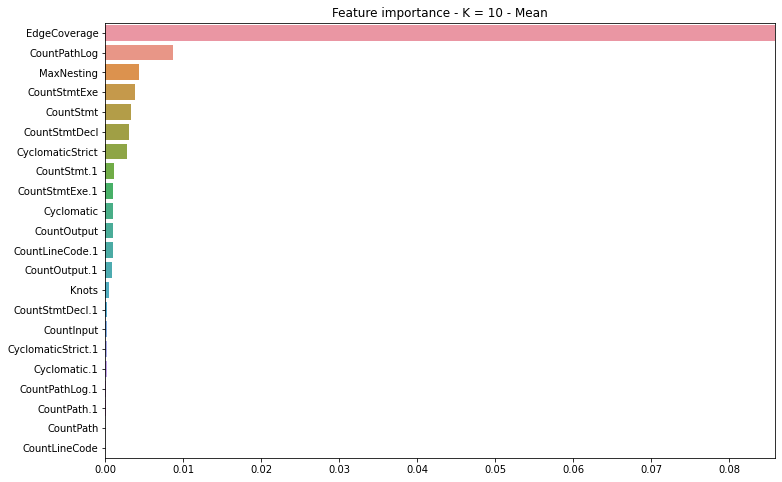

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,NaN,NaN
Mean Sqr Error,NaN,NaN
Mean Sqr Log Error,NaN,NaN
Mean Median Error,NaN,NaN
R2 Score,NaN,NaN


In [34]:
evaluate_svr(previsores, epsilon=0.3, display_feature_importance=True)

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
11,MaxNesting,0.0236545
6,CountPathLog,0.0197674
8,Cyclomatic,0.0150978
7,CountStmtExe,0.00959733
1,CountLineCode,0.0067273
0,CountInput,0.00636571
13,CountOutput.1,0.00505992
14,CountStmt.1,0.00498466
18,CountStmtExe.1,0.00488976
12,CountLineCode.1,0.00439583


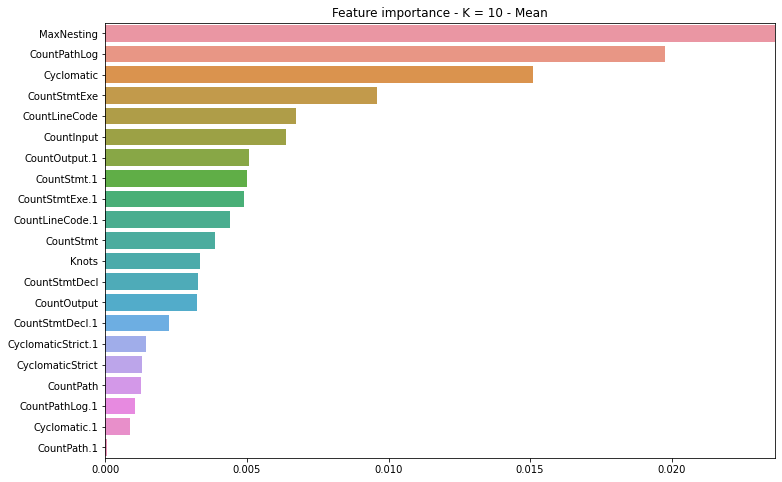

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.218093,NaN
Mean Sqr Error,0.0626579,NaN
Mean Sqr Log Error,0.0279004,NaN
Mean Median Error,0.20869,NaN
R2 Score,0.421141,NaN


In [35]:
evaluate_svr(previsores_sem_ec, epsilon=0.3, display_feature_importance=True)

### Com EC

In [36]:
evaluate_svr(previsores, epsilon=0.4)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.229429,NaN
Mean Sqr Error,0.0695661,NaN
Mean Sqr Log Error,0.0278945,NaN
Mean Median Error,0.236011,NaN
R2 Score,0.359841,NaN


In [37]:
evaluate_svr([
    'CountOutput',
    'EdgeCoverage',
    'Knots',
    'CountStmtDecl',
], epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.185766,NaN
Mean Sqr Error,0.0468584,NaN
Mean Sqr Log Error,0.0196152,NaN
Mean Median Error,0.203179,NaN
R2 Score,0.574105,NaN


In [38]:
evaluate_svr([
    'Cyclomatic', 
    'CyclomaticStrict', 
    'CountInput', 
    'CountOutput',
    'EdgeCoverage',
    'CountStmtExe.1'
], epsilon=0.4)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.218685,NaN
Mean Sqr Error,0.0622643,NaN
Mean Sqr Log Error,0.0242962,NaN
Mean Median Error,0.222261,NaN
R2 Score,0.4266,NaN


In [39]:
evaluate_svr([
    'MaxNesting', 
    'CountPath', 
    'CountStmtExe', 
    'CountInput', 
    'CountOutput',
    'CountStmtExe.1'
], epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.2157,NaN
Mean Sqr Error,0.0637464,NaN
Mean Sqr Log Error,0.0285504,NaN
Mean Median Error,0.195121,NaN
R2 Score,0.410263,NaN


In [40]:
evaluate_svr([
    'CountInput','CountOutput','CountPath','CountStmt','CountStmtDecl','Knots',
    'MaxNesting',
    
    'CountOutput.1','CountStmtDecl.1','CountStmtExe.1'
], epsilon=0.4)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.246073,NaN
Mean Sqr Error,0.0790754,NaN
Mean Sqr Log Error,0.0347405,NaN
Mean Median Error,0.245945,NaN
R2 Score,0.285856,NaN


In [41]:
evaluate_svr([
    'Cyclomatic', 
    'CountOutput',
    'EdgeCoverage'
], epsilon=0.4)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.22054,NaN
Mean Sqr Error,0.0648962,NaN
Mean Sqr Log Error,0.0252986,NaN
Mean Median Error,0.229466,NaN
R2 Score,0.403778,NaN


### Sem EC

In [42]:
evaluate_svr(previsores_sem_ec, epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.218093,NaN
Mean Sqr Error,0.0626579,NaN
Mean Sqr Log Error,0.0279004,NaN
Mean Median Error,0.20869,NaN
R2 Score,0.421141,NaN


### Apenas EC

In [43]:
evaluate_svr([
    'EdgeCoverage',
], epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.210894,NaN
Mean Sqr Error,0.0587562,NaN
Mean Sqr Log Error,0.0238038,NaN
Mean Median Error,0.236372,NaN
R2 Score,0.459563,NaN


## Neural network

In [44]:
def evaluate_neural_network(metrics, epsilon, tot_seeds=0, display_feature_importance=False):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, MLPRegressor(epsilon=epsilon, random_state=i), dataset, apenas_escalonamento=True, display_feature_importance=display_feature_importance)
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)

In [45]:
#evaluate_neural_network(previsores, display_feature_importance=True)

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
11,MaxNesting,0.0179343
6,CountPathLog,0.0126583
7,CountStmtExe,0.0027116
9,CyclomaticStrict,0.001445
10,Knots,0.00119342
3,CountStmt,0.00110103
12,CountLineCode.1,0.00103448
2,CountOutput,0.000946382
1,CountLineCode,0.00078768
14,CountStmt.1,0.00074113


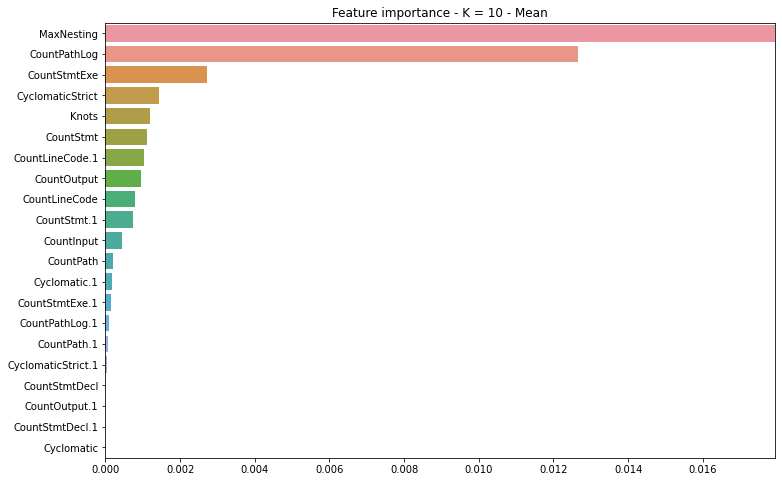

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.243107,0.243107
Mean Sqr Error,0.0774932,0.0774932
Mean Sqr Log Error,0.034324,0.034324
Mean Median Error,0.243669,0.243669
R2 Score,0.297552,0.297552


In [46]:
evaluate_neural_network(previsores_sem_ec, epsilon=0.3, display_feature_importance=True)

### Com EC

In [47]:
evaluate_neural_network(previsores, epsilon=0.8)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.233972,0.233972
Mean Sqr Error,0.0708001,0.0708001
Mean Sqr Log Error,0.0319111,0.0319111
Mean Median Error,0.239292,0.239292
R2 Score,0.373508,0.373508


### Sem EC

In [48]:
evaluate_neural_network(previsores_sem_ec, epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.243107,0.243107
Mean Sqr Error,0.0774932,0.0774932
Mean Sqr Log Error,0.034324,0.034324
Mean Median Error,0.243669,0.243669
R2 Score,0.297552,0.297552


### Apenas EC

In [49]:
evaluate_neural_network([
    'EdgeCoverage'
], epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.241533,0.241533
Mean Sqr Error,0.0783181,0.0783181
Mean Sqr Log Error,0.0353284,0.0353284
Mean Median Error,0.258806,0.258806
R2 Score,0.304758,0.304758


## Random forest

In [417]:
def evaluate_random_forest(metrics, tot_seeds=0, display_prediction=False, display_feature_importance=False):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_noscaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_noscaled_metrics_table.columns.name = 'Seed'
    error_noscaled_metrics_table.index.name = 'Error Metrics'
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, RandomForestRegressor(random_state=i), dataset, display_prediction=display_prediction, display_feature_importance=display_feature_importance)
        error_noscaled_metrics_table[i] = error_metrics['no_scaled']
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_noscaled_metrics_table, error_noscaled_metrics_table)
    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< SEM ESCALONAMENTO >-----')
    display(error_noscaled_metrics_table)
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)

In [418]:
evaluate_random_forest(previsores, display_feature_importance=False)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.056192,0.056192
Mean Sqr Error,0.012195,0.012195
Mean Sqr Log Error,0.005912,0.005912
Mean Median Error,0.014883,0.014883
R2 Score,0.900465,0.900465


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.056463,0.056463
Mean Sqr Error,0.01226,0.01226
Mean Sqr Log Error,0.005952,0.005952
Mean Median Error,0.015691,0.015691
R2 Score,0.899955,0.899955


In [419]:
evaluate_random_forest(previsores_sem_ec, display_feature_importance=False)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.194818,0.194818
Mean Sqr Error,0.07544,0.07544
Mean Sqr Log Error,0.034897,0.034897
Mean Median Error,0.145374,0.145374
R2 Score,0.377501,0.377501


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.195093,0.195093
Mean Sqr Error,0.075554,0.075554
Mean Sqr Log Error,0.034952,0.034952
Mean Median Error,0.145843,0.145843
R2 Score,0.376707,0.376707


In [421]:
evaluate_random_forest(['EdgeCoverage'], display_feature_importance=False)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.099305,0.099305
Mean Sqr Error,0.022348,0.022348
Mean Sqr Log Error,0.010551,0.010551
Mean Median Error,0.055399,0.055399
R2 Score,0.821206,0.821206


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.099305,0.099305
Mean Sqr Error,0.022348,0.022348
Mean Sqr Log Error,0.010551,0.010551
Mean Median Error,0.055399,0.055399
R2 Score,0.821206,0.821206


### Com EC

-----< SEM ESCALONAMENTO >-----


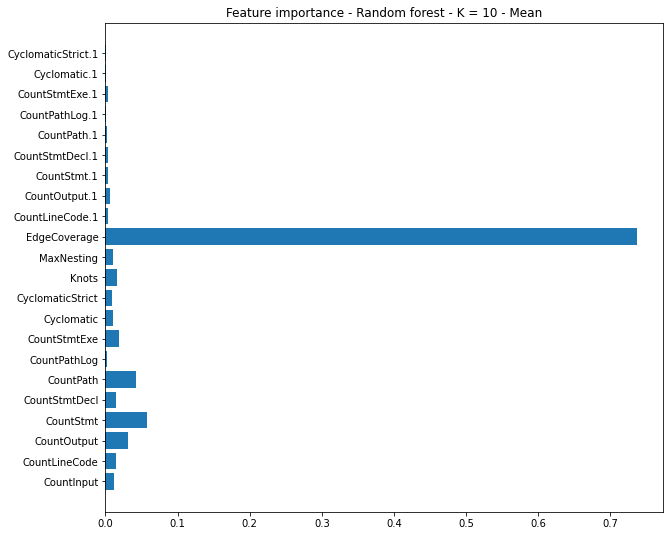



-----< COM ESCALONAMENTO >-----
EdgeCoverage          0.736387
CountStmt             0.058045
CountPath             0.042119
CountOutput           0.030383
CountStmtExe          0.018342
Knots                 0.015660
CountLineCode         0.015333
CountStmtDecl         0.015309
CountInput            0.012241
Cyclomatic            0.010972
MaxNesting            0.010257
CyclomaticStrict      0.008127
CountOutput.1         0.006296
CountStmtDecl.1       0.004145
CountLineCode.1       0.003838
CountStmtExe.1        0.003646
CountStmt.1           0.003379
CountPathLog          0.001781
CountPath.1           0.001489
CyclomaticStrict.1    0.000904
Cyclomatic.1          0.000845
CountPathLog.1        0.000500
Name: mean, dtype: float64


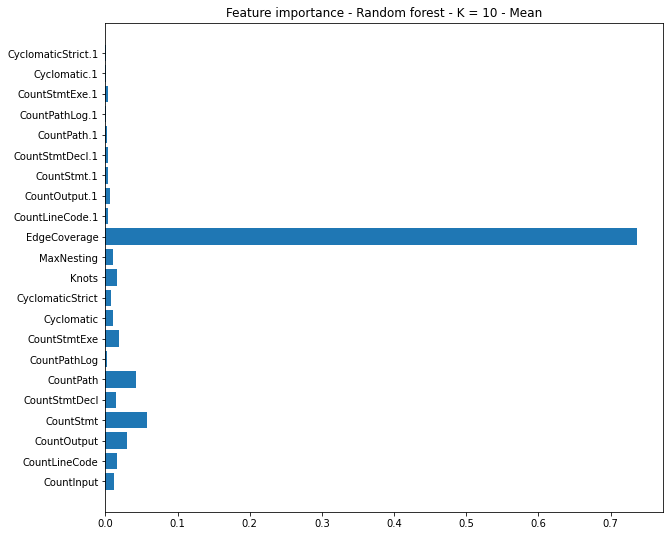

In [54]:
feature_importance(RandomForestRegressor())

In [55]:
evaluate_random_forest(previsores)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0786762,0.0786762
Mean Sqr Error,0.0188811,0.0188811
Mean Sqr Log Error,0.00903727,0.00903727
Mean Median Error,0.034867,0.034867
R2 Score,0.826749,0.826749


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0787833,0.0787833
Mean Sqr Error,0.0189386,0.0189386
Mean Sqr Log Error,0.00906076,0.00906076
Mean Median Error,0.0352914,0.0352914
R2 Score,0.82617,0.82617


In [56]:
evaluate_random_forest([
    'EdgeCoverage'
])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.120745,0.120745
Mean Sqr Error,0.0303291,0.0303291
Mean Sqr Log Error,0.0142042,0.0142042
Mean Median Error,0.0740908,0.0740908
R2 Score,0.723531,0.723531


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.120745,0.120745
Mean Sqr Error,0.0303291,0.0303291
Mean Sqr Log Error,0.0142042,0.0142042
Mean Median Error,0.0740908,0.0740908
R2 Score,0.723531,0.723531


In [57]:
evaluate_random_forest([
    'CountPath', 'CountStmtExe.1', 'CountInput', 'CountOutput', 'CountOutput.1', 'EdgeCoverage'
])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0876215,0.0876215
Mean Sqr Error,0.0215344,0.0215344
Mean Sqr Log Error,0.0101418,0.0101418
Mean Median Error,0.0429287,0.0429287
R2 Score,0.798505,0.798505


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0875951,0.0875951
Mean Sqr Error,0.0215646,0.0215646
Mean Sqr Log Error,0.010159,0.010159
Mean Median Error,0.0425257,0.0425257
R2 Score,0.798199,0.798199


### Sem EC

-----< SEM ESCALONAMENTO >-----


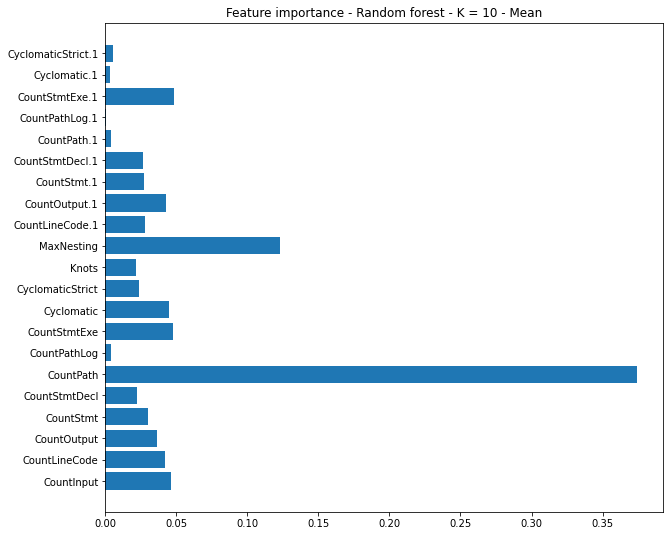



-----< COM ESCALONAMENTO >-----
CountPath             0.372770
MaxNesting            0.123629
Cyclomatic            0.048604
CountStmtExe.1        0.047891
CountInput            0.046386
CountStmtExe          0.046191
CountOutput.1         0.042582
CountLineCode         0.042388
CountOutput           0.035995
CountStmt             0.029958
CountLineCode.1       0.028381
CountStmt.1           0.026880
CountStmtDecl.1       0.026712
CountStmtDecl         0.021700
Knots                 0.021628
CyclomaticStrict      0.021458
CyclomaticStrict.1    0.005642
CountPathLog          0.004337
CountPath.1           0.003437
Cyclomatic.1          0.002767
CountPathLog.1        0.000663
Name: mean, dtype: float64


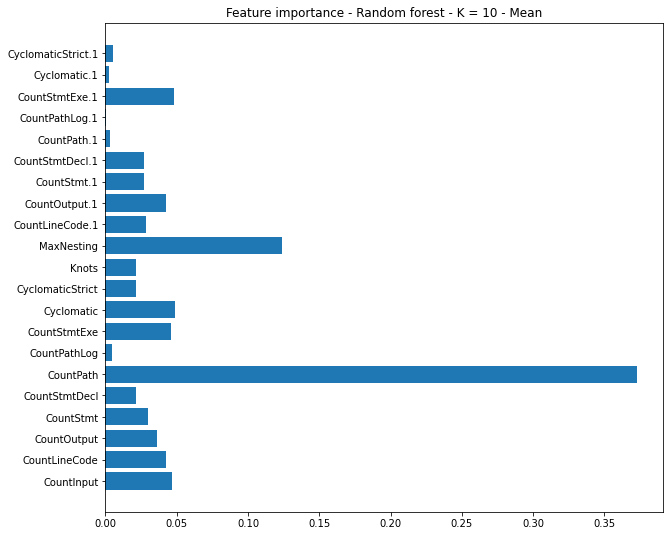

In [58]:
feature_importance(RandomForestRegressor(), prev=previsores_sem_ec)

In [59]:
evaluate_random_forest(previsores_sem_ec)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.147809,0.147809
Mean Sqr Error,0.0481227,0.0481227
Mean Sqr Log Error,0.0219381,0.0219381
Mean Median Error,0.109017,0.109017
R2 Score,0.542421,0.542421


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.147786,0.147786
Mean Sqr Error,0.0482513,0.0482513
Mean Sqr Log Error,0.021994,0.021994
Mean Median Error,0.107399,0.107399
R2 Score,0.541412,0.541412


### Apenas EC

In [60]:
evaluate_random_forest([
    'EdgeCoverage'
])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.120745,0.120745
Mean Sqr Error,0.0303291,0.0303291
Mean Sqr Log Error,0.0142042,0.0142042
Mean Median Error,0.0740908,0.0740908
R2 Score,0.723531,0.723531


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.120745,0.120745
Mean Sqr Error,0.0303291,0.0303291
Mean Sqr Log Error,0.0142042,0.0142042
Mean Median Error,0.0740908,0.0740908
R2 Score,0.723531,0.723531


## Naive bayes

**Aparentemente, não é compatível com variavel dependente como float**

In [61]:
def evaluate_nb(metrics, tot_seeds=0):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_noscaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_noscaled_metrics_table.columns.name = 'Seed'
    error_noscaled_metrics_table.index.name = 'Error Metrics'
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, GaussianNB(var_smoothing =0.00000000001), dataset)
        error_noscaled_metrics_table[i] = error_metrics['no_scaled']
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_noscaled_metrics_table, error_noscaled_metrics_table)
    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< SEM ESCALONAMENTO >-----')
    display(error_noscaled_metrics_table)
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)

### Com EC

In [62]:
evaluate([
    'EdgeCoverage'
], GaussianNB(var_smoothing=1e-5))

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 209, in fit
    return self._partial_fit(X, y, np.unique(y), _refit=True,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 374, in _partial_fit
    if _check_partial_fit_first_call(self, classes):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\multiclass.py", line 339, in _check_partial_fit_first_call
    clf.classes_ = unique_labels(classes)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\multiclass.py", line 98, in uni

,no_scaled,scaled
Mean Abs Error,NaN,NaN
Mean Sqr Error,NaN,NaN
Mean Sqr Log Error,NaN,NaN
Mean Median Error,NaN,NaN
R2 Score,NaN,NaN


In [63]:
evaluate_nb([
    'CountPath', 'CountStmtExe.1', 'CountInput', 'CountOutput', 'CountOutput.1', 'EdgeCoverage'
])

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 209, in fit
    return self._partial_fit(X, y, np.unique(y), _refit=True,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 374, in _partial_fit
    if _check_partial_fit_first_call(self, classes):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\multiclass.py", line 339, in _check_partial_fit_first_call
    clf.classes_ = unique_labels(classes)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\multiclass.py", line 98, in uni

-----< SEM ESCALONAMENTO >-----


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 209, in fit
    return self._partial_fit(X, y, np.unique(y), _refit=True,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 374, in _partial_fit
    if _check_partial_fit_first_call(self, classes):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\multiclass.py", line 339, in _check_partial_fit_first_call
    clf.classes_ = unique_labels(classes)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\multiclass.py", line 98, in uni

Seed,0,Mean
Error Metrics,,
Mean Abs Error,NaN,NaN
Mean Sqr Error,NaN,NaN
Mean Sqr Log Error,NaN,NaN
Mean Median Error,NaN,NaN
R2 Score,NaN,NaN


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,NaN,NaN
Mean Sqr Error,NaN,NaN
Mean Sqr Log Error,NaN,NaN
Mean Median Error,NaN,NaN
R2 Score,NaN,NaN


### Sem EC

## KNeighborsRegressor

In [64]:
def evaluate_knr(metrics, tot_seeds=0, display_feature_importance=False):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_noscaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_noscaled_metrics_table.columns.name = 'Seed'
    error_noscaled_metrics_table.index.name = 'Error Metrics'
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, KNeighborsRegressor(), dataset, display_feature_importance=display_feature_importance)
        error_noscaled_metrics_table[i] = error_metrics['no_scaled']
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_noscaled_metrics_table, error_noscaled_metrics_table)
    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< SEM ESCALONAMENTO >-----')
    display(error_noscaled_metrics_table)
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
12,EdgeCoverage,0.103965
6,CountPathLog,0.0185817
11,MaxNesting,0.01429
0,CountInput,0.00972261
2,CountOutput,0.00335614
4,CountStmtDecl,0.0022664
14,CountOutput.1,0.00214189
16,CountStmtDecl.1,0.00194405
10,Knots,0.0012221
7,CountStmtExe,0.000864431


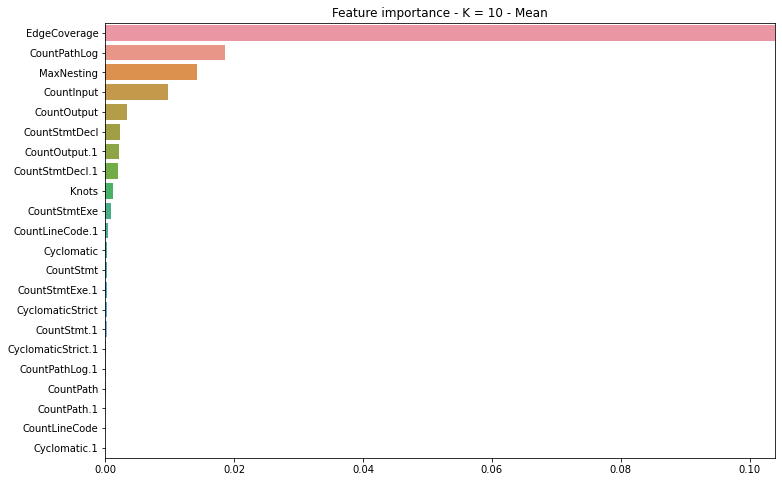

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.168141,0.168141
Mean Sqr Error,0.0615175,0.0615175
Mean Sqr Log Error,0.0274799,0.0274799
Mean Median Error,0.115594,0.115594
R2 Score,0.413543,0.413543


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0918171,0.0918171
Mean Sqr Error,0.0250757,0.0250757
Mean Sqr Log Error,0.0122085,0.0122085
Mean Median Error,0.04083,0.04083
R2 Score,0.768497,0.768497


In [65]:
evaluate_knr(previsores, display_feature_importance=True)

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
11,MaxNesting,0.0616253
6,CountPathLog,0.0557813
0,CountInput,0.0154896
2,CountOutput,0.00911925
15,CountStmtDecl.1,0.00909707
13,CountOutput.1,0.00783307
4,CountStmtDecl,0.00657658
10,Knots,0.0058073
7,CountStmtExe,0.00353074
14,CountStmt.1,0.00350326


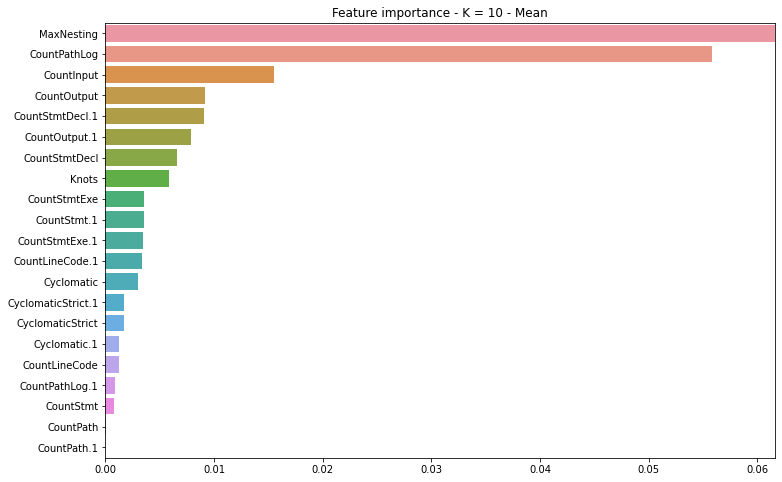

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.170081,0.170081
Mean Sqr Error,0.0626859,0.0626859
Mean Sqr Log Error,0.0279984,0.0279984
Mean Median Error,0.115668,0.115668
R2 Score,0.402208,0.402208


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.162846,0.162846
Mean Sqr Error,0.0620222,0.0620222
Mean Sqr Log Error,0.0284736,0.0284736
Mean Median Error,0.106012,0.106012
R2 Score,0.390778,0.390778


In [66]:
evaluate_knr(previsores_sem_ec, display_feature_importance=True)

### Com EC

In [67]:
evaluate_knr(previsores)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.168141,0.168141
Mean Sqr Error,0.0615175,0.0615175
Mean Sqr Log Error,0.0274799,0.0274799
Mean Median Error,0.115594,0.115594
R2 Score,0.413543,0.413543


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0918171,0.0918171
Mean Sqr Error,0.0250757,0.0250757
Mean Sqr Log Error,0.0122085,0.0122085
Mean Median Error,0.04083,0.04083
R2 Score,0.768497,0.768497


### Sem EC

In [68]:
evaluate_knr(previsores_sem_ec)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.170081,0.170081
Mean Sqr Error,0.0626859,0.0626859
Mean Sqr Log Error,0.0279984,0.0279984
Mean Median Error,0.115668,0.115668
R2 Score,0.402208,0.402208


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.162846,0.162846
Mean Sqr Error,0.0620222,0.0620222
Mean Sqr Log Error,0.0284736,0.0284736
Mean Median Error,0.106012,0.106012
R2 Score,0.390778,0.390778


### Apenas EC

In [69]:
evaluate_knr([
    'EdgeCoverage'
])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.119735,0.119735
Mean Sqr Error,0.0361383,0.0361383
Mean Sqr Log Error,0.0168497,0.0168497
Mean Median Error,0.071106,0.071106
R2 Score,0.664289,0.664289


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.119735,0.119735
Mean Sqr Error,0.0361383,0.0361383
Mean Sqr Log Error,0.0168497,0.0168497
Mean Median Error,0.071106,0.071106
R2 Score,0.664289,0.664289


# Feature importance dos melhores modelos

## SCM

In [969]:
evaluate_random_forest(previsores_sem_ec, display_feature_importance=False)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.192043,0.192043
Mean Sqr Error,0.074596,0.074596
Mean Sqr Log Error,0.034209,0.034209
Mean Median Error,0.143459,0.143459
R2 Score,0.39046,0.39046


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.192154,0.192154
Mean Sqr Error,0.074665,0.074665
Mean Sqr Log Error,0.034229,0.034229
Mean Median Error,0.144526,0.144526
R2 Score,0.389989,0.389989


## SCM + EC

In [970]:
evaluate_random_forest(previsores, display_feature_importance=False)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.051941,0.051941
Mean Sqr Error,0.011362,0.011362
Mean Sqr Log Error,0.005502,0.005502
Mean Median Error,0.008181,0.008181
R2 Score,0.906967,0.906967


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.052247,0.052247
Mean Sqr Error,0.01147,0.01147
Mean Sqr Log Error,0.005556,0.005556
Mean Median Error,0.009347,0.009347
R2 Score,0.906182,0.906182


## EC

In [971]:
evaluate_random_forest([
    'EdgeCoverage'
], display_feature_importance=False)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.09215,0.09215
Mean Sqr Error,0.020572,0.020572
Mean Sqr Log Error,0.009638,0.009638
Mean Median Error,0.043412,0.043412
R2 Score,0.835796,0.835796


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.09215,0.09215
Mean Sqr Error,0.020572,0.020572
Mean Sqr Log Error,0.009638,0.009638
Mean Median Error,0.043412,0.043412
R2 Score,0.835796,0.835796


# Avaliação dos modelos com variação das métricas

In [27]:
melhores_previsores = [
    'CountPath',
    'CountLineCode',
    'MaxNesting',
    'CountStmtExe.1',
    'CountOutput.1',
    'CountInput',
    'CountStmt',
    'CountStmtExe',
    'CountStmtDecl.1',
    'CountOutput',
    'Cyclomatic',
    'CountStmt.1',
    'CountLineCode.1',
    'Knots'
]

melhores_previsores_com_ec = [
    'CountPath',
    'CountLineCode',
    'MaxNesting',
    'CountStmtExe.1',
    'CountOutput.1',
    'CountInput',
    'CountStmt',
    'CountStmtExe',
    'CountStmtDecl.1',
    'CountOutput',
    'Cyclomatic',
    'CountStmt.1',
    'CountLineCode.1',
    'Knots',
    'EdgeCoverage'
]

### Funções auxiliares

In [14]:
from itertools import chain, combinations

def powerset(iterable):
    "list(powerset([1,2,3])) --> [(), (1,), (2,), (3,), (1,2), (1,3), (2,3), (1,2,3)]"
    s = list(iterable)
    it = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

    powerset_list = []

    for element in it:
        subset_list = []
        for subset_element in element:
            subset_list.append(subset_element)

        powerset_list.append(subset_list)
        
    return powerset_list

In [15]:
def evaluate_metrics_brute_force(metrics=previsores, history=10):
    metrics_powerset = powerset(metrics)
    metrics_powerset.remove([]) # Removes empty subset
    
    results = pd.DataFrame(
        index=[i for i in range(history)],
        columns=['R2', 'Metrics'],
        data=[[0.0, '']]
    )

    for subset_metrics_powerset in metrics_powerset:
        error_metrics = evaluate(subset_metrics_powerset, RandomForestRegressor(random_state=0), dataset)
        idx_min_r2 = results['R2'].argmin()

        results.loc[idx_min_r2, 'R2'] = float(error_metrics['no_scaled'][4]) # R2
        results.loc[idx_min_r2, 'Metrics'] = str([str(metric) for metric in subset_metrics_powerset])

    return results

## SCM

In [18]:
results = evaluate_metrics_brute_force(melhores_previsores, history=10)

<AxesSubplot:xlabel='R2', ylabel='Metrics'>

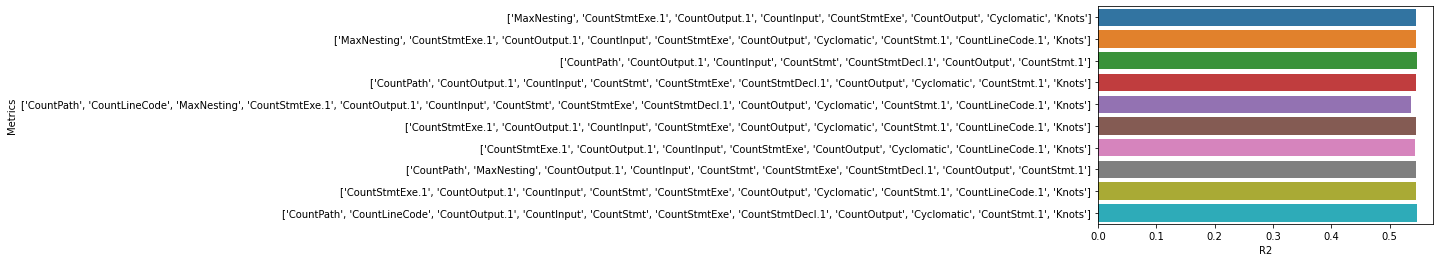

In [19]:
sns.barplot(x='R2', y='Metrics', data=results, orient='h')

In [23]:
pd.set_option('display.max_colwidth', 500)
results.sort_values(by="R2", ascending=False)

,R2,Metrics
2,0.546646,"['CountPath', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 'CountStmt.1']"
9,0.546406,"['CountPath', 'CountLineCode', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtExe', 'CountStmtDecl.1', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'Knots']"
1,0.545886,"['MaxNesting', 'CountStmtExe.1', 'CountOutput.1', 'CountInput', 'CountStmtExe', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'CountLineCode.1', 'Knots']"
8,0.545516,"['CountStmtExe.1', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtExe', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'CountLineCode.1', 'Knots']"
7,0.544882,"['CountPath', 'MaxNesting', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtExe', 'CountStmtDecl.1', 'CountOutput', 'CountStmt.1']"
3,0.544827,"['CountPath', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtExe', 'CountStmtDecl.1', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'Knots']"
0,0.544818,"['MaxNesting', 'CountStmtExe.1', 'CountOutput.1', 'CountInput', 'CountStmtExe', 'CountOutput', 'Cyclomatic', 'Knots']"
5,0.544211,"['CountStmtExe.1', 'CountOutput.1', 'CountInput', 'CountStmtExe', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'CountLineCode.1', 'Knots']"
6,0.544151,"['CountStmtExe.1', 'CountOutput.1', 'CountInput', 'CountStmtExe', 'CountOutput', 'Cyclomatic', 'CountLineCode.1', 'Knots']"
4,0.535797,"['CountPath', 'CountLineCode', 'MaxNesting', 'CountStmtExe.1', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtExe', 'CountStmtDecl.1', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'CountLineCode.1', 'Knots']"


In [26]:
evaluate_random_forest(['CountPath', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 'CountStmt.1'])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.147094,0.147094
Mean Sqr Error,0.047246,0.047246
Mean Sqr Log Error,0.021487,0.021487
Mean Median Error,0.100898,0.100898
R2 Score,0.546646,0.546646


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.147235,0.147235
Mean Sqr Error,0.047452,0.047452
Mean Sqr Log Error,0.021619,0.021619
Mean Median Error,0.100503,0.100503
R2 Score,0.54555,0.54555


## SCM + EC

In [28]:
results_com_ec = evaluate_metrics_brute_force(melhores_previsores_com_ec, history=10)

In [29]:
pd.set_option('display.max_colwidth', 500)
results_com_ec.sort_values(by="R2", ascending=False)

,R2,Metrics
7,0.844454,"['MaxNesting', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'Knots', 'EdgeCoverage']"
0,0.844249,"['MaxNesting', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'Knots', 'EdgeCoverage']"
8,0.843752,"['MaxNesting', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 'Cyclomatic', 'CountLineCode.1', 'Knots', 'EdgeCoverage']"
3,0.843669,"['MaxNesting', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 'Cyclomatic', 'Knots', 'EdgeCoverage']"
4,0.843291,"['MaxNesting', 'CountStmtExe.1', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'Knots', 'EdgeCoverage']"
1,0.843205,"['CountLineCode', 'MaxNesting', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'Knots', 'EdgeCoverage']"
2,0.843134,"['MaxNesting', 'CountInput', 'CountStmt', 'CountStmtExe', 'CountStmtDecl.1', 'CountOutput', 'Knots', 'EdgeCoverage']"
6,0.842864,"['CountLineCode', 'MaxNesting', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'Knots', 'EdgeCoverage']"
9,0.842853,"['MaxNesting', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'CountLineCode.1', 'Knots', 'EdgeCoverage']"
5,0.827074,"['CountPath', 'CountLineCode', 'MaxNesting', 'CountStmtExe.1', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtExe', 'CountStmtDecl.1', 'CountOutput', 'Cyclomatic', 'CountStmt.1', 'CountLineCode.1', 'Knots', 'EdgeCoverage']"


<AxesSubplot:xlabel='R2', ylabel='Metrics'>

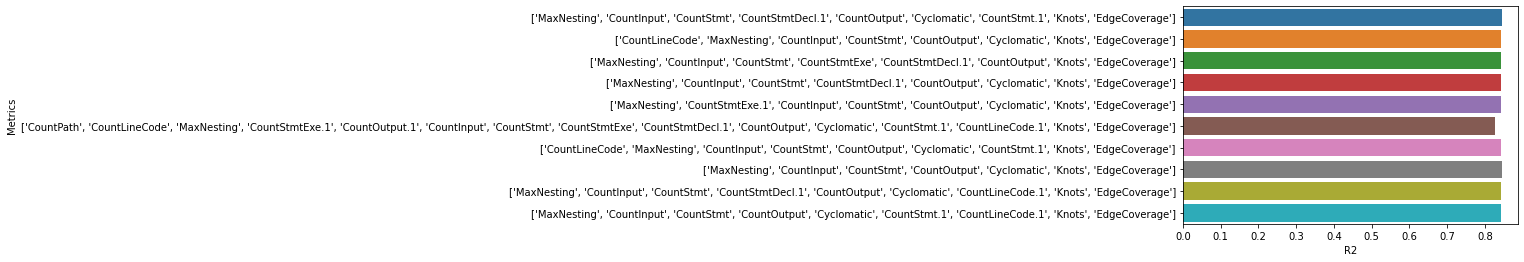

In [30]:
sns.barplot(x='R2', y='Metrics', data=results_com_ec, orient='h')

In [31]:
evaluate_random_forest(['MaxNesting', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'Knots', 'EdgeCoverage'])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.074011,0.074011
Mean Sqr Error,0.016937,0.016937
Mean Sqr Log Error,0.008181,0.008181
Mean Median Error,0.03406,0.03406
R2 Score,0.844454,0.844454


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.073978,0.073978
Mean Sqr Error,0.016966,0.016966
Mean Sqr Log Error,0.008191,0.008191
Mean Median Error,0.034304,0.034304
R2 Score,0.844336,0.844336


In [32]:
evaluate_random_forest([
    'MaxNesting', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 
    'Cyclomatic', 'CountStmt.1', 'Knots', 'EdgeCoverage'])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.074802,0.074802
Mean Sqr Error,0.016928,0.016928
Mean Sqr Log Error,0.008173,0.008173
Mean Median Error,0.037938,0.037938
R2 Score,0.844249,0.844249


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.074806,0.074806
Mean Sqr Error,0.016961,0.016961
Mean Sqr Log Error,0.008187,0.008187
Mean Median Error,0.038116,0.038116
R2 Score,0.844017,0.844017


### EC

### Não se aplica

# Validation curves (seleção de parametros para tuning)

In [70]:
from sklearn.model_selection import validation_curve

In [117]:
def plot_validation_curve(train_score, test_score, param_range):
    train_scores_mean = np.mean(train_score, axis=1)
    train_scores_std = np.std(train_score, axis=1)
    test_scores_mean = np.mean(test_score, axis=1)
    test_scores_std = np.std(test_score, axis=1)

    plt.title("Validation Curve with Random Forest")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

def evaluate_validation_curve(param_name, param_range, labels = melhores_previsores):
    train_scoreNum, test_scoreNum = validation_curve(
            RandomForestRegressor(),
            X = dataset[labels].values, y = dataset['PrimePathCoverage'].values, 
            param_name = param_name, 
            param_range = param_range, cv = 10
    )
    
    plot_validation_curve(train_scoreNum, test_scoreNum, param_range)

## SCM

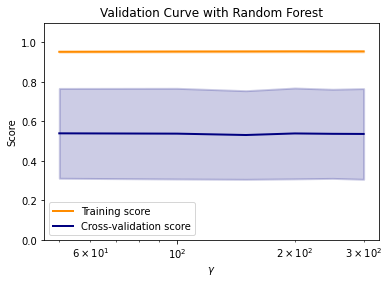

In [92]:
evaluate_validation_curve('n_estimators', [50, 100, 150, 200, 250, 300])

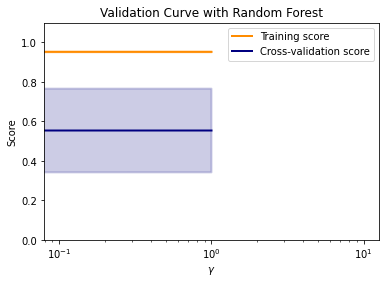

In [93]:
evaluate_validation_curve('criterion', ['mse', 'mae'])

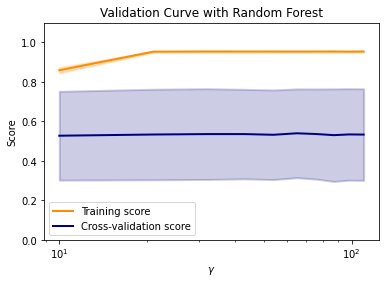

In [94]:
param_range = [x for x in np.linspace(10, 110, num = 10, dtype=int)]
evaluate_validation_curve('max_depth', param_range)

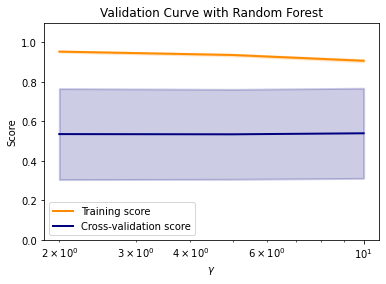

In [95]:
evaluate_validation_curve('min_samples_split', [2, 5, 10])

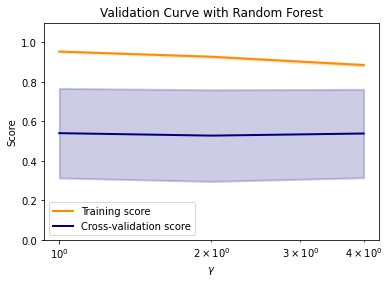

In [96]:
evaluate_validation_curve('min_samples_leaf', [1, 2, 4])

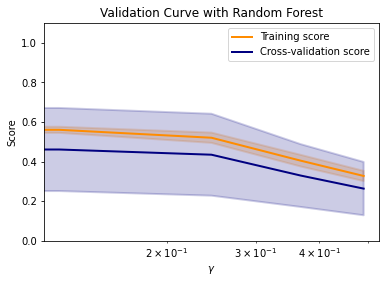

In [146]:
evaluate_validation_curve('min_weight_fraction_leaf', [x for x in np.linspace(0.0, 0.49, 5, dtype=float)])

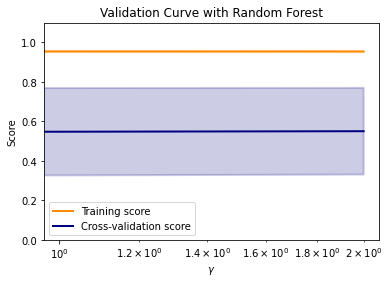

In [98]:
evaluate_validation_curve('max_features', ['auto', 'sqrt', 'log2'])

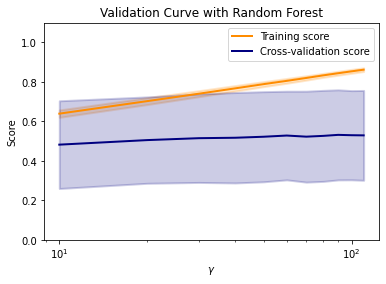

In [99]:
param_range = [x for x in np.linspace(10, 110, num = 11, dtype=int)]
evaluate_validation_curve('max_leaf_nodes', param_range)

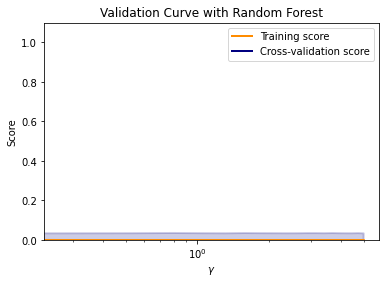

In [100]:
evaluate_validation_curve('min_impurity_decrease', [x for x in np.linspace(0.0, 5.0, 20)])

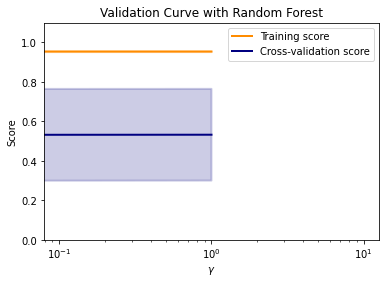

In [101]:
evaluate_validation_curve('bootstrap', [True, False])

## SCM + EC

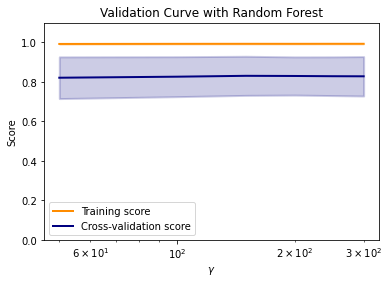

In [118]:
evaluate_validation_curve('n_estimators', [50, 100, 150, 200, 250, 300], melhores_previsores_com_ec)

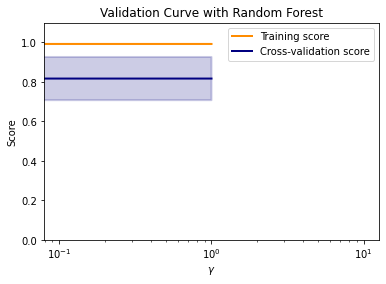

In [119]:
evaluate_validation_curve('criterion', ['mse', 'mae'], melhores_previsores_com_ec)

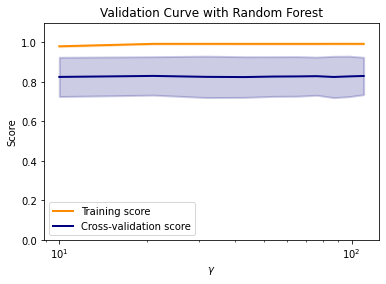

In [120]:
param_range = [x for x in np.linspace(10, 110, num = 10, dtype=int)]
evaluate_validation_curve('max_depth', param_range, melhores_previsores_com_ec)

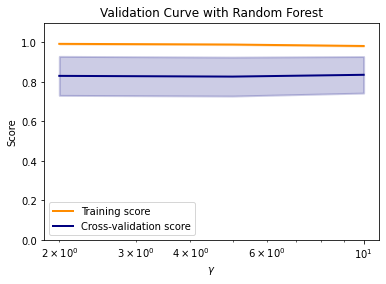

In [121]:
evaluate_validation_curve('min_samples_split', [2, 5, 10], melhores_previsores_com_ec)

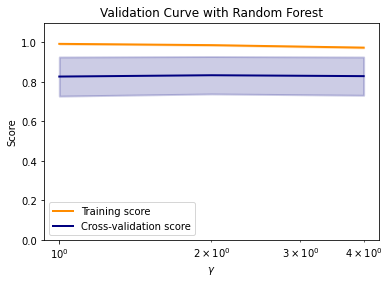

In [122]:
evaluate_validation_curve('min_samples_leaf', [1, 2, 4], melhores_previsores_com_ec)

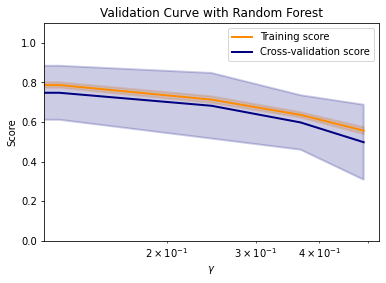

In [145]:
evaluate_validation_curve('min_weight_fraction_leaf', [x for x in np.linspace(0.0, 0.49, 5, dtype=float)], melhores_previsores_com_ec)

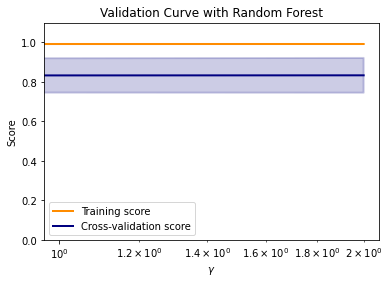

In [124]:
evaluate_validation_curve('max_features', ['auto', 'sqrt', 'log2'], melhores_previsores_com_ec)

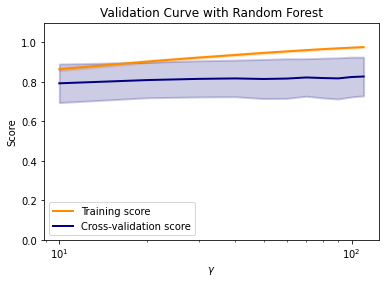

In [125]:
param_range = [x for x in np.linspace(10, 110, num = 11, dtype=int)]
evaluate_validation_curve('max_leaf_nodes', param_range, melhores_previsores_com_ec)

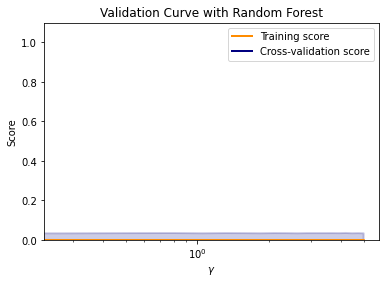

In [126]:
evaluate_validation_curve('min_impurity_decrease', [x for x in np.linspace(0.0, 5.0, 20)], melhores_previsores_com_ec)

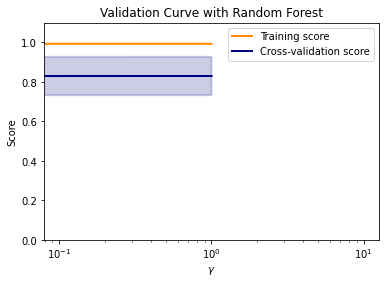

In [127]:
evaluate_validation_curve('bootstrap', [True, False], melhores_previsores_com_ec)

## EC

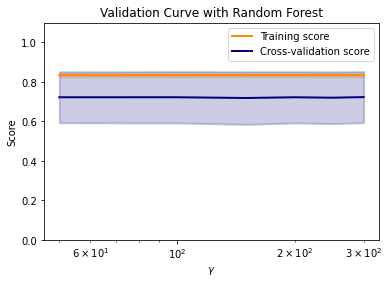

In [128]:
evaluate_validation_curve('n_estimators', [50, 100, 150, 200, 250, 300], ['EdgeCoverage'])

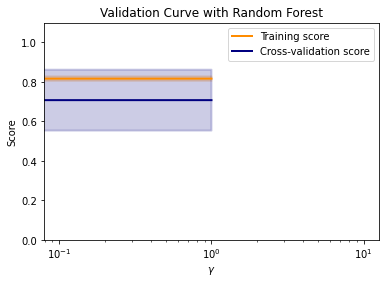

In [129]:
evaluate_validation_curve('criterion', ['mse', 'mae'], ['EdgeCoverage'])

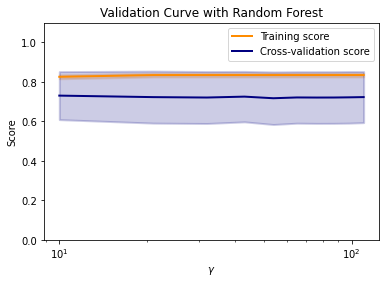

In [130]:
param_range = [x for x in np.linspace(10, 110, num = 10, dtype=int)]
evaluate_validation_curve('max_depth', param_range, ['EdgeCoverage'])

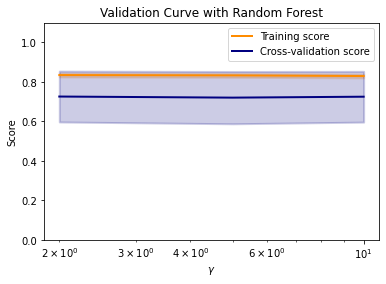

In [131]:
evaluate_validation_curve('min_samples_split', [2, 5, 10], ['EdgeCoverage'])

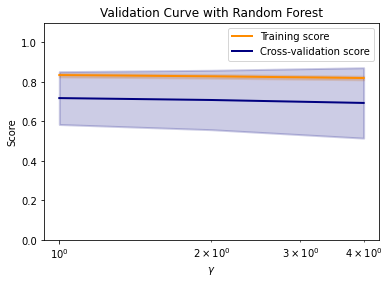

In [132]:
evaluate_validation_curve('min_samples_leaf', [1, 2, 4], ['EdgeCoverage'])

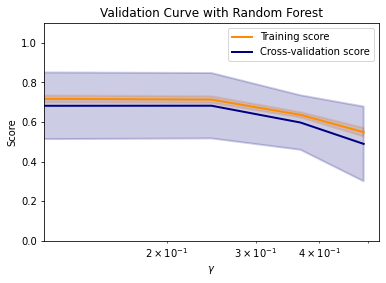

In [144]:
evaluate_validation_curve('min_weight_fraction_leaf', [x for x in np.linspace(0.0, 0.49, 5, dtype=float)], ['EdgeCoverage'])

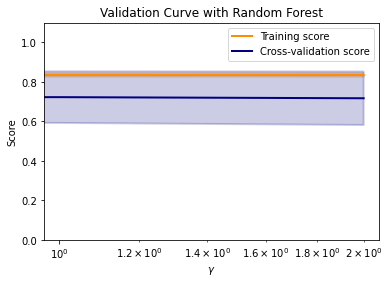

In [134]:
evaluate_validation_curve('max_features', ['auto', 'sqrt', 'log2'], ['EdgeCoverage'])

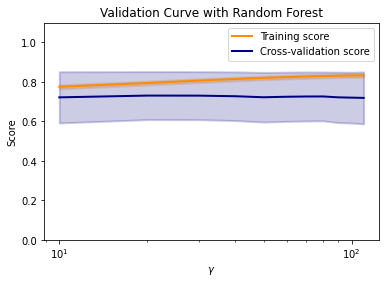

In [135]:
param_range = [x for x in np.linspace(10, 110, num = 11, dtype=int)]
evaluate_validation_curve('max_leaf_nodes', param_range, ['EdgeCoverage'])

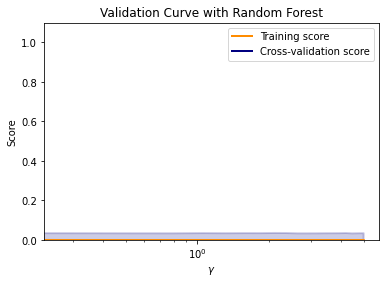

In [136]:
evaluate_validation_curve('min_impurity_decrease', [x for x in np.linspace(0.0, 5.0, 20)], ['EdgeCoverage'])

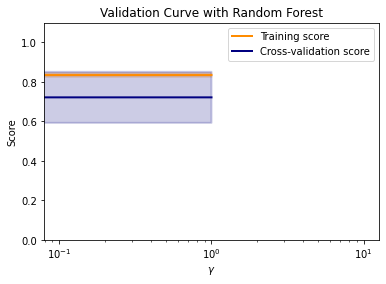

In [137]:
evaluate_validation_curve('bootstrap', [True, False], ['EdgeCoverage'])

# Tuning hyper-parameters

In [154]:
from sklearn.model_selection import RandomizedSearchCV

def evaluate_hyperparam_rf_scm():
    hyperparam_space = {
        'min_weight_fraction_leaf': [x for x in np.linspace(0.0, 0.49, 5, dtype=float)],
        'max_depth':[x for x in np.linspace(10, 110, num = 10, dtype=int)],
        'min_samples_split':[2, 5, 10],
        'min_samples_leaf':[1, 2, 4],
        'max_leaf_nodes':[x for x in np.linspace(10, 110, num = 11, dtype=int)]
    }
    
    random_search = RandomizedSearchCV(
            estimator=RandomForestRegressor(), 
            param_distributions=hyperparam_space,
            n_iter=100,
            cv=10,
            random_state=0
    )

    random_search.fit(dataset[melhores_previsores].values, dataset['PrimePathCoverage'].values)
    
    display(random_search.best_params_)
    
    return random_search

def evaluate_hyperparam_rf_scm_ec():
    hyperparam_space = {
        'max_depth':[x for x in np.linspace(10, 110, num = 10, dtype=int)],
        'min_weight_fraction_leaf': [x for x in np.linspace(0.0, 0.49, 5, dtype=float)],
        'max_leaf_nodes':[x for x in np.linspace(10, 110, num = 11, dtype=int)]
    }
    
    random_search = RandomizedSearchCV(
            estimator=RandomForestRegressor(), 
            param_distributions=hyperparam_space,
            n_iter=100,
            cv=10,
            random_state=0
    )

    
    random_search.fit(dataset[melhores_previsores_com_ec].values, dataset['PrimePathCoverage'].values)
    
    display(random_search.best_params_)
    
    return random_search

def evaluate_hyperparam_rf_ec():
    hyperparam_space = {
        'min_weight_fraction_leaf': [x for x in np.linspace(0.0, 0.49, 5, dtype=float)],
        'max_leaf_nodes':[x for x in np.linspace(10, 110, num = 11, dtype=int)]
    }
    
    random_search = RandomizedSearchCV(
            estimator=RandomForestRegressor(), 
            param_distributions=hyperparam_space,
            n_iter=100,
            cv=10,
            random_state=0
    )

    random_search.fit(dataset['EdgeCoverage'].values.reshape(-1,1), dataset['PrimePathCoverage'].values)
    
    display(random_search.best_params_)
    
    return random_search

### SCM

In [149]:
results_scm = evaluate_hyperparam_rf_scm()

{'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 90,
 'max_depth': 110}

### SCM + EC

In [150]:
results_scm_ec = evaluate_hyperparam_rf_scm_ec()

{'min_weight_fraction_leaf': 0.0, 'max_leaf_nodes': 60, 'max_depth': 87}

### EC

In [155]:
results_ec = evaluate_hyperparam_rf_ec()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 55 is smaller than n_iter=100. Running 55 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'min_weight_fraction_leaf': 0.0, 'max_leaf_nodes': 30}

# Executando algoritmos com tuning

In [159]:
def evaluate_random_forest_tuning_scm(metrics, tot_seeds=0, display_prediction=False, display_feature_importance=False):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_noscaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_noscaled_metrics_table.columns.name = 'Seed'
    error_noscaled_metrics_table.index.name = 'Error Metrics'
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, RandomForestRegressor(random_state=i, min_weight_fraction_leaf=0.0, min_samples_split=5, min_samples_leaf=1, max_leaf_nodes=90, max_depth=110), dataset, display_prediction=display_prediction, display_feature_importance=display_feature_importance)
        error_noscaled_metrics_table[i] = error_metrics['no_scaled']
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_noscaled_metrics_table, error_noscaled_metrics_table)
    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< SEM ESCALONAMENTO >-----')
    display(error_noscaled_metrics_table)
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)
    
def evaluate_random_forest_tuning_scm_ec(metrics, tot_seeds=0, display_prediction=False, display_feature_importance=False):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_noscaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_noscaled_metrics_table.columns.name = 'Seed'
    error_noscaled_metrics_table.index.name = 'Error Metrics'
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, RandomForestRegressor(random_state=i, min_weight_fraction_leaf=0.0, max_leaf_nodes=90, max_depth=87), dataset, display_prediction=display_prediction, display_feature_importance=display_feature_importance)
        error_noscaled_metrics_table[i] = error_metrics['no_scaled']
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_noscaled_metrics_table, error_noscaled_metrics_table)
    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< SEM ESCALONAMENTO >-----')
    display(error_noscaled_metrics_table)
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)
    
def evaluate_random_forest_tuning_ec(metrics, tot_seeds=0, display_prediction=False, display_feature_importance=False):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_noscaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_noscaled_metrics_table.columns.name = 'Seed'
    error_noscaled_metrics_table.index.name = 'Error Metrics'
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, RandomForestRegressor(random_state=i, min_weight_fraction_leaf=0.0, max_leaf_nodes=30), dataset, display_prediction=display_prediction, display_feature_importance=display_feature_importance)
        error_noscaled_metrics_table[i] = error_metrics['no_scaled']
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_noscaled_metrics_table, error_noscaled_metrics_table)
    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< SEM ESCALONAMENTO >-----')
    display(error_noscaled_metrics_table)
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)

## SCM

In [160]:
evaluate_random_forest_tuning_scm(previsores_sem_ec)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.152231,0.152231
Mean Sqr Error,0.048535,0.048535
Mean Sqr Log Error,0.022192,0.022192
Mean Median Error,0.116175,0.116175
R2 Score,0.537998,0.537998


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.152268,0.152268
Mean Sqr Error,0.048708,0.048708
Mean Sqr Log Error,0.02229,0.02229
Mean Median Error,0.115903,0.115903
R2 Score,0.536406,0.536406


## SCM + EC

In [161]:
evaluate_random_forest_tuning_scm_ec(previsores)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.081767,0.081767
Mean Sqr Error,0.019448,0.019448
Mean Sqr Log Error,0.009373,0.009373
Mean Median Error,0.038175,0.038175
R2 Score,0.820893,0.820893


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.081796,0.081796
Mean Sqr Error,0.019436,0.019436
Mean Sqr Log Error,0.009366,0.009366
Mean Median Error,0.037944,0.037944
R2 Score,0.820903,0.820903


## EC

In [162]:
evaluate_random_forest_tuning_ec(['EdgeCoverage'])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.124163,0.124163
Mean Sqr Error,0.029534,0.029534
Mean Sqr Log Error,0.014016,0.014016
Mean Median Error,0.078397,0.078397
R2 Score,0.730579,0.730579


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.124163,0.124163
Mean Sqr Error,0.029534,0.029534
Mean Sqr Log Error,0.014016,0.014016
Mean Median Error,0.078397,0.078397
R2 Score,0.730579,0.730579


# Validação

In [378]:
def escalonador(dados):
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    return scaler.fit_transform(dados)

def get_cross_validate_estimators_scaled(previsores):
    d = dataset
    k = 10
    classificador = RandomForestRegressor(random_state=0)
    ppc = d['PrimePathCoverage'].values
    previsores_content = d[previsores].values
    
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )

    return resultados_escalonados['estimator']

def get_cross_validate_estimators_noscaled(previsores):
    d = dataset
    k = 10
    classificador = RandomForestRegressor(random_state=0)
    ppc = d['PrimePathCoverage'].values
    previsores_content = d[previsores].values
    
    resultados = cross_validate(
            classificador, 
            previsores_content, 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )
    
    return resultados['estimator']

In [379]:
estimators_scm_best_noscaled = get_cross_validate_estimators_noscaled(['CountPath', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 'CountStmt.1'])
estimators_scm_best_scaled = get_cross_validate_estimators_scaled(['CountPath', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 'CountStmt.1'])
estimators_scm_all_noscaled = get_cross_validate_estimators_noscaled(previsores_sem_ec)
estimators_scm_all_scaled = get_cross_validate_estimators_scaled(previsores_sem_ec)

estimators_scmec_best_noscaled = get_cross_validate_estimators_noscaled(['MaxNesting', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'Knots', 'EdgeCoverage'])
estimators_scmec_best_scaled = get_cross_validate_estimators_scaled(['MaxNesting', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'Knots', 'EdgeCoverage'])
estimators_scmec_all_noscaled = get_cross_validate_estimators_noscaled(previsores)
estimators_scmec_all_scaled = get_cross_validate_estimators_scaled(previsores)

estimators_ec_noscaled = get_cross_validate_estimators_noscaled(['EdgeCoverage'])
estimators_ec_scaled = get_cross_validate_estimators_scaled(['EdgeCoverage'])

In [380]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

def evaluate_rf_external_validation(estimadores_dataset_treinado, dataset_externo, previsores, display_prediction = False, scale=False):
    ppc = dataset_externo['PrimePathCoverage'].values
    previsores_content = dataset_externo[previsores].values
    
    if scale:
        previsores_content = escalonador(previsores_content)
    
    results = pd.DataFrame(
            index=[i for i in range(10)], 
            columns=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score']
    )
    results_mean = pd.DataFrame(
            index=[0], 
            columns=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score']
    )
    
    k = 0
    for estimator in estimadores_dataset_treinado:
        ppc_predict = estimator.predict(previsores_content)
        predict_table = pd.DataFrame(index=[i for i in range(len(ppc_predict))],columns=['PPC correct', 'PPC predict'])

        for i in range(len(ppc_predict)):
            predict_table['PPC correct'][i] = ppc[i]
            predict_table['PPC predict'][i] = ppc_predict[i]
        
        results.iloc[k,0] = mean_absolute_error(predict_table['PPC correct'].values, predict_table['PPC predict'].values)
        results.iloc[k,1] = mean_squared_error(predict_table['PPC correct'].values, predict_table['PPC predict'].values)
        results.iloc[k,2] = mean_squared_log_error(predict_table['PPC correct'].values, predict_table['PPC predict'].values)
        results.iloc[k,3] = median_absolute_error(predict_table['PPC correct'].values, predict_table['PPC predict'].values)
        results.iloc[k,4] = r2_score(predict_table['PPC correct'].values, predict_table['PPC predict'].values)
    
        k += 1
        
    results_mean['Mean Abs Error'] = results['Mean Abs Error'].mean()
    results_mean['Mean Sqr Error'] = results['Mean Sqr Error'].mean()
    results_mean['Mean Sqr Log Error'] = results['Mean Sqr Log Error'].mean()
    results_mean['Mean Median Error'] = results['Mean Median Error'].mean()
    results_mean['R2 Score'] = results['R2 Score'].mean()
    
    return results_mean

In [381]:
def evalutate_rf_external_validation_scm_best(dataset_validation):
    previsores = ['CountPath', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 'CountStmt.1']
    results_scaled = evaluate_rf_external_validation(estimators_scm_best_scaled, dataset_validation, previsores, scale=True)
    results_noscaled = evaluate_rf_external_validation(estimators_scm_best_noscaled, dataset_validation, previsores, scale=False)
    
    display('-----< SEM ESCALONAMENTO >-----')
    display(results_noscaled)
    display('-----< COM ESCALONAMENTO >-----')
    display(results_scaled)
    
def evalutate_rf_external_validation_scm_all(dataset_validation):
    previsores = previsores_sem_ec
    results_scaled = evaluate_rf_external_validation(estimators_scm_all_scaled, dataset_validation, previsores, scale=True)
    results_noscaled = evaluate_rf_external_validation(estimators_scm_all_noscaled, dataset_validation, previsores, scale=False)
    
    display('-----< SEM ESCALONAMENTO >-----')
    display(results_noscaled)
    display('-----< COM ESCALONAMENTO >-----')
    display(results_scaled)
    
def evalutate_rf_external_validation_scmec_best(dataset_validation):
    previsores = ['MaxNesting', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'Knots', 'EdgeCoverage']
    results_scaled = evaluate_rf_external_validation(estimators_scmec_best_scaled, dataset_validation, previsores, scale=True)
    results_noscaled = evaluate_rf_external_validation(estimators_scmec_best_noscaled, dataset_validation, previsores, scale=False)
    
    display('-----< SEM ESCALONAMENTO >-----')
    display(results_noscaled)
    display('-----< COM ESCALONAMENTO >-----')
    display(results_scaled)
    
def evalutate_rf_external_validation_scmec_all(dataset_validation):
    results_scaled = evaluate_rf_external_validation(estimators_scmec_all_scaled, dataset_validation, previsores, scale=True)
    results_noscaled = evaluate_rf_external_validation(estimators_scmec_all_noscaled, dataset_validation, previsores, scale=False)
    
    display('-----< SEM ESCALONAMENTO >-----')
    display(results_noscaled)
    display('-----< COM ESCALONAMENTO >-----')
    display(results_scaled)
    
def evalutate_rf_external_validation_ec(dataset_validation):
    previsores = ['EdgeCoverage']
    results_scaled = evaluate_rf_external_validation(estimators_ec_scaled, dataset_validation, previsores, scale=True)
    results_noscaled = evaluate_rf_external_validation(estimators_ec_noscaled, dataset_validation, previsores, scale=False)
    
    display('-----< SEM ESCALONAMENTO >-----')
    display(results_noscaled)
    display('-----< COM ESCALONAMENTO >-----')
    display(results_scaled)

## Dataset unificado

In [422]:
load_dataset('dataset-unificado-validacao.csv')
remove_last_column()
remove_nan()
fix_coverage_metrics()
remove_coverage_metrics_with_zero()
under_sampling({1:60, 2:86, 3:40})
select_metrics(selected_metrics)

Dataset size:  324
Média complexidade dataset balanceado:  4.098765432098766


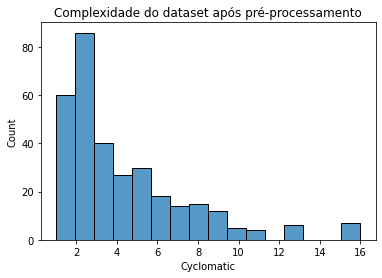

In [423]:
print('Dataset size: ', dataset.shape[0])
print('Média complexidade dataset balanceado: ', dataset['Cyclomatic'].mean())
plt.title("Complexidade do dataset após pré-processamento")
sns.histplot(dataset['Cyclomatic'])
plt.show()

### SCM

#### Usando melhores metricas

In [424]:
evalutate_rf_external_validation_scm_best(dataset)

'-----< SEM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.235826,0.09422,0.043455,0.195826,0.357575


'-----< COM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.308192,0.140712,0.059522,0.257489,0.040581


#### Usando todas metricas

In [425]:
evalutate_rf_external_validation_scm_all(dataset)

'-----< SEM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.222426,0.082689,0.038356,0.177764,0.436196


'-----< COM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.304919,0.13511,0.057699,0.259284,0.078774


### SCM + EC

#### Usando melhores metricas

In [426]:
evalutate_rf_external_validation_scmec_best(dataset)

'-----< SEM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.098479,0.033998,0.017789,0.040919,0.768187


'-----< COM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.165188,0.061993,0.029986,0.115419,0.577313


#### Usando todas metricas

In [427]:
evalutate_rf_external_validation_scmec_all(dataset)

'-----< SEM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.09339,0.029909,0.015174,0.03805,0.796068


'-----< COM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.190228,0.076213,0.038196,0.131483,0.480354


### EC

In [428]:
evalutate_rf_external_validation_ec(dataset)

'-----< SEM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.137369,0.043915,0.021739,0.05134,0.700575


'-----< COM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.149827,0.05061,0.025073,0.061818,0.654923


# Validação sem undersampling

## Dataset unificado

In [429]:
load_dataset('dataset-unificado-validacao.csv')
remove_last_column()
remove_nan()
fix_coverage_metrics()
remove_coverage_metrics_with_zero()
select_metrics(selected_metrics)

Dataset size:  411
Média complexidade dataset balanceado:  3.6155717761557176


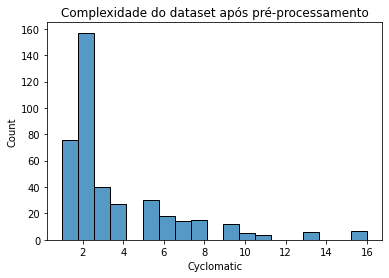

In [430]:
print('Dataset size: ', dataset.shape[0])
print('Média complexidade dataset balanceado: ', dataset['Cyclomatic'].mean())
plt.title("Complexidade do dataset após pré-processamento")
sns.histplot(dataset['Cyclomatic'])
plt.show()

### SCM

#### Usando melhores metricas

In [431]:
evalutate_rf_external_validation_scm_best(dataset)

'-----< SEM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.238835,0.095138,0.04216,0.200579,0.319349


'-----< COM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.30977,0.145885,0.060511,0.231367,-0.043712


#### Usando todas metricas

In [432]:
evalutate_rf_external_validation_scm_all(dataset)

'-----< SEM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.226199,0.083513,0.036944,0.187395,0.402522


'-----< COM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.306752,0.14106,0.058685,0.235792,-0.009193


### SCM + EC

#### Usando melhores metricas

In [433]:
evalutate_rf_external_validation_scmec_best(dataset)

'-----< SEM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.096681,0.039137,0.019479,0.025562,0.720003


'-----< COM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.169607,0.068459,0.032219,0.116117,0.510218


#### Usando todas metricas

In [434]:
evalutate_rf_external_validation_scmec_all(dataset)

'-----< SEM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.091986,0.035274,0.017051,0.021633,0.747638


'-----< COM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.19511,0.082127,0.040032,0.131126,0.412431


### EC

In [435]:
evalutate_rf_external_validation_ec(dataset)

'-----< SEM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.135333,0.046032,0.02188,0.04814,0.670671


'-----< COM ESCALONAMENTO >-----'

,Mean Abs Error,Mean Sqr Error,Mean Sqr Log Error,Mean Median Error,R2 Score
0,0.157317,0.058276,0.028135,0.0588,0.58307


# Detalhes do dataset unificado

In [396]:
def evaluate_rf_external_validation_full(estimadores_dataset_treinado, dataset_externo, previsores, display_prediction = False, scale=False):
    results_full = pd.DataFrame(columns=['CC', 'Real EC', 'Predicted PPC', 'Real PPC', 'Error'])
    ppc = dataset_externo['PrimePathCoverage'].values
    previsores_content = dataset_externo[previsores].values
    cyclomatic = dataset_externo['Cyclomatic'].values
    ec = dataset_externo['EdgeCoverage'].values
    
    if scale:
        previsores_content = escalonador(previsores_content)
    
    results = pd.DataFrame(
            index=[i for i in range(10)], 
            columns=['Mean Sqr Error']
    )
    
    predict_table = pd.DataFrame(columns=['Cyclomatic', 'EC correct', 'PPC predict', 'PPC correct', 'Error'])
    
    #k = 0
    for estimator in estimadores_dataset_treinado:
        ppc_predict = estimator.predict(previsores_content)
        tot_ppc_predict = len(ppc_predict)
        current_predict_table = pd.DataFrame(
            columns=['Cyclomatic', 'EC correct', 'PPC predict', 'PPC correct', 'Error'],
            index=[i for i in range(tot_ppc_predict)]
        )


        for i in range(tot_ppc_predict):
            current_predict_table.loc[i, 'PPC correct'] = ppc[i]
            current_predict_table.loc[i, 'PPC predict'] = ppc_predict[i]
            current_predict_table.loc[i, 'EC correct'] = ec[i]
            current_predict_table.loc[i, 'Cyclomatic'] = cyclomatic[i]
            current_predict_table.loc[i, 'Error'] = abs(ppc[i] - ppc_predict[i])
    
        current_predict_error = current_predict_table['Error'].mean()
        best_predict_error = predict_table['Error'].mean()
        
        if (np.isnan(best_predict_error)) or (current_predict_error < best_predict_error):
            predict_table = current_predict_table.copy()
        #k += 1
    
    predict_table.sort_values(by='Error', ascending=False, inplace=True)
    
    display_error_mean_table(predict_table)

    return predict_table

In [397]:
def display_error_mean_table(dataset):
    error_mean_table = pd.DataFrame(
        columns=['Cyclomatic', 'Average error', 'Total'],
        index=[i for i in range(5)]
    )
    error_mean_table['Cyclomatic'][0] = '[0;2]'
    error_mean_table['Cyclomatic'][1] = '[3;5]'
    error_mean_table['Cyclomatic'][2] = '[6;8]'
    error_mean_table['Cyclomatic'][3] = '[8;10]'
    error_mean_table['Cyclomatic'][4] = '> 10'

    error_mean_table['Average error'][0] = dataset[(dataset['Cyclomatic'] >= 0) & (dataset['Cyclomatic'] <= 2)]['Error'].mean()
    error_mean_table['Average error'][1] = dataset[(dataset['Cyclomatic'] >= 3) & (dataset['Cyclomatic'] <= 5)]['Error'].mean()
    error_mean_table['Average error'][2] = dataset[(dataset['Cyclomatic'] >= 6) & (dataset['Cyclomatic'] <= 8)]['Error'].mean()
    error_mean_table['Average error'][3] = dataset[(dataset['Cyclomatic'] >= 8) & (dataset['Cyclomatic'] <= 10)]['Error'].mean()
    error_mean_table['Average error'][4] = dataset[dataset['Cyclomatic'] > 10]['Error'].mean()

    error_mean_table['Total'][0] = dataset[(dataset['Cyclomatic'] >= 0) & (dataset['Cyclomatic'] <= 2)]['Error'].shape[0]
    error_mean_table['Total'][1] = dataset[(dataset['Cyclomatic'] >= 3) & (dataset['Cyclomatic'] <= 5)]['Error'].shape[0]
    error_mean_table['Total'][2] = dataset[(dataset['Cyclomatic'] >= 6) & (dataset['Cyclomatic'] <= 8)]['Error'].shape[0]
    error_mean_table['Total'][3] = dataset[(dataset['Cyclomatic'] >= 8) & (dataset['Cyclomatic'] <= 10)]['Error'].shape[0]
    error_mean_table['Total'][4] = dataset[dataset['Cyclomatic'] > 10]['Error'].shape[0]

    display(error_mean_table)
    print('Dataset average error:', dataset['Error'].mean())

In [398]:
MAX_ROWS = 50
pd.set_option('display.max_rows', MAX_ROWS)

def evalutate_rf_external_validation_scm_best_full(dataset_validation):
    previsores = ['CountPath', 'CountOutput.1', 'CountInput', 'CountStmt', 'CountStmtDecl.1', 'CountOutput', 'CountStmt.1']
    results_noscaled = evaluate_rf_external_validation_full(estimators_scm_best_noscaled, dataset_validation, previsores, scale=False)
    
    display('-----< SEM ESCALONAMENTO >-----')
    display(results_noscaled.iloc[0:MAX_ROWS, :])
    print('Error == 0:', results_noscaled[results_noscaled['Error'] == 0].shape[0])
    print('0 < Error < 0.3:', results_noscaled[(results_noscaled['Error'] > 0) & (results_noscaled['Error'] < 0.3)].shape[0])
    print('0.3 <= Error < 0.5:', results_noscaled[(results_noscaled['Error'] >= 0.3) & (results_noscaled['Error'] < 0.5)].shape[0])
    print('0.5 <= Error < 0.7:', results_noscaled[(results_noscaled['Error'] >= 0.5) & (results_noscaled['Error'] < 0.7)].shape[0])
    print('Error >= 0.7:', results_noscaled[results_noscaled['Error'] >= 0.7].shape[0])
    
def evalutate_rf_external_validation_scm_all_full(dataset_validation):
    previsores = previsores_sem_ec
    results_noscaled = evaluate_rf_external_validation_full(estimators_scm_all_noscaled, dataset_validation, previsores, scale=False)
    
    display('-----< SEM ESCALONAMENTO >-----')
    display(results_noscaled.iloc[0:MAX_ROWS, :])
    print('Error == 0:', results_noscaled[results_noscaled['Error'] == 0].shape[0])
    print('0 < Error < 0.3:', results_noscaled[(results_noscaled['Error'] > 0) & (results_noscaled['Error'] < 0.3)].shape[0])
    print('0.3 <= Error < 0.5:', results_noscaled[(results_noscaled['Error'] >= 0.3) & (results_noscaled['Error'] < 0.5)].shape[0])
    print('0.5 <= Error < 0.7:', results_noscaled[(results_noscaled['Error'] >= 0.5) & (results_noscaled['Error'] < 0.7)].shape[0])
    print('Error >= 0.7:', results_noscaled[results_noscaled['Error'] >= 0.7].shape[0])
    
def evalutate_rf_external_validation_scmec_best_full(dataset_validation):
    previsores = ['MaxNesting', 'CountInput', 'CountStmt', 'CountOutput', 'Cyclomatic', 'Knots', 'EdgeCoverage']
    results_noscaled = evaluate_rf_external_validation_full(estimators_scmec_best_noscaled, dataset_validation, previsores, scale=False)
    
    display('-----< SEM ESCALONAMENTO >-----')
    display(results_noscaled.iloc[0:MAX_ROWS, :])
    print('Error == 0:', results_noscaled[results_noscaled['Error'] == 0].shape[0])
    print('0 < Error < 0.3:', results_noscaled[(results_noscaled['Error'] > 0) & (results_noscaled['Error'] < 0.3)].shape[0])
    print('0.3 <= Error < 0.5:', results_noscaled[(results_noscaled['Error'] >= 0.3) & (results_noscaled['Error'] < 0.5)].shape[0])
    print('0.5 <= Error < 0.7:', results_noscaled[(results_noscaled['Error'] >= 0.5) & (results_noscaled['Error'] < 0.7)].shape[0])
    print('Error >= 0.7:', results_noscaled[results_noscaled['Error'] >= 0.7].shape[0])
    
def evalutate_rf_external_validation_scmec_all_full(dataset_validation):
    results_noscaled = evaluate_rf_external_validation_full(estimators_scmec_all_noscaled, dataset_validation, previsores, scale=False)
    
    display('-----< SEM ESCALONAMENTO >-----')
    display(results_noscaled.iloc[0:MAX_ROWS, :])
    print('Error == 0:', results_noscaled[results_noscaled['Error'] == 0].shape[0])
    print('0 < Error < 0.3:', results_noscaled[(results_noscaled['Error'] > 0) & (results_noscaled['Error'] < 0.3)].shape[0])
    print('0.3 <= Error < 0.5:', results_noscaled[(results_noscaled['Error'] >= 0.3) & (results_noscaled['Error'] < 0.5)].shape[0])
    print('0.5 <= Error < 0.7:', results_noscaled[(results_noscaled['Error'] >= 0.5) & (results_noscaled['Error'] < 0.7)].shape[0])
    print('Error >= 0.7:', results_noscaled[results_noscaled['Error'] >= 0.7].shape[0])
    
    return results_noscaled
    
def evalutate_rf_external_validation_ec_full(dataset_validation):
    previsores = ['EdgeCoverage']
    results_noscaled = evaluate_rf_external_validation_full(estimators_ec_noscaled, dataset_validation, previsores, scale=False)
    
    display('-----< SEM ESCALONAMENTO >-----')
    display(results_noscaled.iloc[0:MAX_ROWS, :])
    print('Error == 0:', results_noscaled[results_noscaled['Error'] == 0].shape[0])
    print('0 < Error < 0.3:', results_noscaled[(results_noscaled['Error'] > 0) & (results_noscaled['Error'] < 0.3)].shape[0])
    print('0.3 <= Error < 0.5:', results_noscaled[(results_noscaled['Error'] >= 0.3) & (results_noscaled['Error'] < 0.5)].shape[0])
    print('0.5 <= Error < 0.7:', results_noscaled[(results_noscaled['Error'] >= 0.5) & (results_noscaled['Error'] < 0.7)].shape[0])
    print('Error >= 0.7:', results_noscaled[results_noscaled['Error'] >= 0.7].shape[0])

## Com undersampling

In [399]:
load_dataset('dataset-unificado-validacao.csv')
remove_last_column()
remove_nan()
fix_coverage_metrics()
#remove_coverage_metrics_with_zero()
under_sampling({1:60, 2:86, 3:40})
select_metrics(selected_metrics)

### SCM

#### Usando melhores metricas

In [400]:
evalutate_rf_external_validation_scm_best_full(dataset)

,Cyclomatic,Average error,Total
0,[0;2],0.288381,146
1,[3;5],0.285049,98
2,[6;8],0.223053,47
3,[8;10],0.214954,32
4,> 10,0.103991,17


Dataset average error: 0.2666732341890843


'-----< SEM ESCALONAMENTO >-----'

,Cyclomatic,EC correct,PPC predict,PPC correct,Error
201,1,0.0,1.0,0.0,1.0
198,1,0.0,1.0,0.0,1.0
5,1,0.0,0.98,0.0,0.98
199,1,0.0,0.975,0.0,0.975
197,1,0.0,0.97,0.0,0.97
195,1,0.0,0.95,0.0,0.95
22,1,0.0,0.95,0.0,0.95
318,2,0.3333,0.889333,0.0,0.889333
24,1,0.0,0.863333,0.0,0.863333
134,2,0.5,0.835,0.0,0.835


Error == 0: 8
0 < Error < 0.3: 216
0.3 <= Error < 0.5: 55
0.5 <= Error < 0.7: 26
Error >= 0.7: 20


#### Usando todas metricas

In [401]:
evalutate_rf_external_validation_scm_all_full(dataset)

,Cyclomatic,Average error,Total
0,[0;2],0.285976,146
1,[3;5],0.264313,98
2,[6;8],0.191363,47
3,[8;10],0.191307,32
4,> 10,0.125898,17


Dataset average error: 0.253504875102667


'-----< SEM ESCALONAMENTO >-----'

,Cyclomatic,EC correct,PPC predict,PPC correct,Error
195,1,0.0,1.0,0.0,1.0
197,1,0.0,1.0,0.0,1.0
5,1,0.0,1.0,0.0,1.0
198,1,0.0,1.0,0.0,1.0
199,1,0.0,1.0,0.0,1.0
201,1,0.0,1.0,0.0,1.0
24,1,0.0,0.948571,0.0,0.948571
22,1,0.0,0.94,0.0,0.94
31,1,0.05,0.874125,0.0,0.874125
318,2,0.3333,0.8495,0.0,0.8495


Error == 0: 8
0 < Error < 0.3: 224
0.3 <= Error < 0.5: 49
0.5 <= Error < 0.7: 26
Error >= 0.7: 18


### SCM + EC

#### Usando melhores metricas

In [402]:
evalutate_rf_external_validation_scmec_best_full(dataset)

,Cyclomatic,Average error,Total
0,[0;2],0.048286,146
1,[3;5],0.142418,98
2,[6;8],0.071214,47
3,[8;10],0.099331,32
4,> 10,0.075793,17


Dataset average error: 0.0842868865184371


'-----< SEM ESCALONAMENTO >-----'

,Cyclomatic,EC correct,PPC predict,PPC correct,Error
253,2,0.25,0.095108,1.0,0.904892
248,2,0.25,0.095108,1.0,0.904892
230,2,0.25,0.095108,1.0,0.904892
46,4,0.3333,0.169124,1.0,0.830876
290,4,0.7143,0.229757,0.75,0.520243
134,2,0.5,0.5,0.0,0.5
48,2,0.6667,0.5,1.0,0.5
45,2,0.6667,0.5,1.0,0.5
36,2,0.6667,0.5,1.0,0.5
191,4,0.6667,0.409857,0.0,0.409857


Error == 0: 117
0 < Error < 0.3: 189
0.3 <= Error < 0.5: 10
0.5 <= Error < 0.7: 5
Error >= 0.7: 4


#### Usando todas metricas

In [403]:
evalutate_rf_external_validation_scmec_all_full(dataset)

,Cyclomatic,Average error,Total
0,[0;2],0.051212,146
1,[3;5],0.126241,98
2,[6;8],0.07458,47
3,[8;10],0.099051,32
4,> 10,0.043076,17


Dataset average error: 0.07938148410256408


'-----< SEM ESCALONAMENTO >-----'

,Cyclomatic,EC correct,PPC predict,PPC correct,Error
248,2,0.25,0.083064,1.0,0.916936
230,2,0.25,0.0856,1.0,0.9144
253,2,0.25,0.089063,1.0,0.910937
46,4,0.3333,0.180452,1.0,0.819548
36,2,0.6667,0.495,1.0,0.505
48,2,0.6667,0.495,1.0,0.505
45,2,0.6667,0.495,1.0,0.505
296,2,0.5,0.5,0.0,0.5
191,4,0.6667,0.448728,0.0,0.448728
94,2,0.4,0.077828,0.5,0.422172


Error == 0: 110
0 < Error < 0.3: 197
0.3 <= Error < 0.5: 10
0.5 <= Error < 0.7: 4
Error >= 0.7: 4


,Cyclomatic,EC correct,PPC predict,PPC correct,Error
248,2,0.25,0.083064,1.0,0.916936
230,2,0.25,0.0856,1.0,0.9144
253,2,0.25,0.089063,1.0,0.910937
46,4,0.3333,0.180452,1.0,0.819548
36,2,0.6667,0.495,1.0,0.505
...,...,...,...,...,...
201,1,0.0,0.0,0.0,0.0
200,2,0.0,0.0,0.0,0.0
199,1,0.0,0.0,0.0,0.0
198,1,0.0,0.0,0.0,0.0


### EC

In [404]:
evalutate_rf_external_validation_ec_full(dataset)

,Cyclomatic,Average error,Total
0,[0;2],0.09021,146
1,[3;5],0.140878,98
2,[6;8],0.146129,47
3,[8;10],0.176591,32
4,> 10,0.135457,17


Dataset average error: 0.12232198345334921


'-----< SEM ESCALONAMENTO >-----'

,Cyclomatic,EC correct,PPC predict,PPC correct,Error
230,2,0.25,0.148499,1.0,0.851501
248,2,0.25,0.148499,1.0,0.851501
253,2,0.25,0.148499,1.0,0.851501
46,4,0.3333,0.222917,1.0,0.777083
320,5,1.0,0.950029,0.3438,0.606229
48,2,0.6667,0.397869,1.0,0.602131
36,2,0.6667,0.397869,1.0,0.602131
45,2,0.6667,0.397869,1.0,0.602131
322,5,1.0,0.950029,0.375,0.575029
122,6,1.0,0.950029,0.4737,0.476329


Error == 0: 28
0 < Error < 0.3: 259
0.3 <= Error < 0.5: 29
0.5 <= Error < 0.7: 5
Error >= 0.7: 4


## Sem undersampling

In [405]:
load_dataset('dataset-unificado-validacao.csv')
remove_last_column()
remove_nan()
fix_coverage_metrics()
#remove_coverage_metrics_with_zero()
select_metrics(selected_metrics)

### SCM

#### Usando melhores metricas

In [406]:
evalutate_rf_external_validation_scm_best_full(dataset)

,Cyclomatic,Average error,Total
0,[0;2],0.29863,280
1,[3;5],0.281023,104
2,[6;8],0.223053,47
3,[8;10],0.214954,32
4,> 10,0.103991,17


Dataset average error: 0.2784370771930873


'-----< SEM ESCALONAMENTO >-----'

,Cyclomatic,EC correct,PPC predict,PPC correct,Error
298,1,0.0,1.0,0.0,1.0
291,1,0.0,1.0,0.0,1.0
296,1,0.0,0.995,0.0,0.995
9,1,0.0,0.98,0.0,0.98
293,1,0.0,0.98,0.0,0.98
294,1,0.0,0.975,0.0,0.975
289,1,0.0,0.97,0.0,0.97
287,1,0.0,0.95,0.0,0.95
27,1,0.0,0.95,0.0,0.95
300,1,0.0,0.94,0.0,0.94


Error == 0: 14
0 < Error < 0.3: 292
0.3 <= Error < 0.5: 83
0.5 <= Error < 0.7: 44
Error >= 0.7: 32


#### Usando todas metricas

In [407]:
evalutate_rf_external_validation_scm_all_full(dataset)

,Cyclomatic,Average error,Total
0,[0;2],0.294596,280
1,[3;5],0.276108,104
2,[6;8],0.194292,47
3,[8;10],0.185571,32
4,> 10,0.094013,17


Dataset average error: 0.2704974341171016


'-----< SEM ESCALONAMENTO >-----'

,Cyclomatic,EC correct,PPC predict,PPC correct,Error
298,1,0.0,0.99,0.0,0.99
291,1,0.0,0.99,0.0,0.99
296,1,0.0,0.98,0.0,0.98
287,1,0.0,0.976667,0.0,0.976667
289,1,0.0,0.976667,0.0,0.976667
290,1,0.0,0.976667,0.0,0.976667
293,1,0.0,0.976667,0.0,0.976667
9,1,0.0,0.97,0.0,0.97
294,1,0.0,0.965,0.0,0.965
33,1,0.0,0.955,0.0,0.955


Error == 0: 12
0 < Error < 0.3: 289
0.3 <= Error < 0.5: 91
0.5 <= Error < 0.7: 48
Error >= 0.7: 25


### SCM + EC

#### Usando melhores metricas

In [408]:
evalutate_rf_external_validation_scmec_best_full(dataset)

,Cyclomatic,Average error,Total
0,[0;2],0.059691,280
1,[3;5],0.142287,104
2,[6;8],0.071214,47
3,[8;10],0.099331,32
4,> 10,0.075793,17


Dataset average error: 0.08150068080223112


'-----< SEM ESCALONAMENTO >-----'

,Cyclomatic,EC correct,PPC predict,PPC correct,Error
367,2,0.25,0.095108,1.0,0.904892
364,2,0.25,0.095108,1.0,0.904892
369,2,0.25,0.095108,1.0,0.904892
371,2,0.25,0.095108,1.0,0.904892
372,2,0.25,0.095108,1.0,0.904892
375,2,0.25,0.095108,1.0,0.904892
343,2,0.25,0.095108,1.0,0.904892
69,4,0.3333,0.169124,1.0,0.830876
416,4,0.7143,0.229757,0.75,0.520243
193,2,0.5,0.5,0.0,0.5


Error == 0: 212
0 < Error < 0.3: 219
0.3 <= Error < 0.5: 15
0.5 <= Error < 0.7: 11
Error >= 0.7: 8


#### Usando todas metricas

In [409]:
res = evalutate_rf_external_validation_scmec_all_full(dataset)

,Cyclomatic,Average error,Total
0,[0;2],0.062206,280
1,[3;5],0.125639,104
2,[6;8],0.07458,47
3,[8;10],0.099051,32
4,> 10,0.043076,17


Dataset average error: 0.0783537326164875


'-----< SEM ESCALONAMENTO >-----'

,Cyclomatic,EC correct,PPC predict,PPC correct,Error
372,2,0.25,0.083064,1.0,0.916936
364,2,0.25,0.083064,1.0,0.916936
369,2,0.25,0.083064,1.0,0.916936
343,2,0.25,0.0856,1.0,0.9144
367,2,0.25,0.089063,1.0,0.910937
375,2,0.25,0.089063,1.0,0.910937
371,2,0.25,0.089063,1.0,0.910937
69,4,0.3333,0.180452,1.0,0.819548
210,1,0.5,0.46,1.0,0.54
68,2,0.6667,0.495,1.0,0.505


Error == 0: 204
0 < Error < 0.3: 227
0.3 <= Error < 0.5: 17
0.5 <= Error < 0.7: 9
Error >= 0.7: 8


### EC

In [410]:
evalutate_rf_external_validation_ec_full(dataset)

,Cyclomatic,Average error,Total
0,[0;2],0.092246,280
1,[3;5],0.139501,104
2,[6;8],0.168203,47
3,[8;10],0.182446,32
4,> 10,0.113542,17


Dataset average error: 0.11617523573734041


'-----< SEM ESCALONAMENTO >-----'

,Cyclomatic,EC correct,PPC predict,PPC correct,Error
69,4,0.3333,0.231567,1.0,0.768433
343,2,0.25,0.242833,1.0,0.757167
375,2,0.25,0.242833,1.0,0.757167
364,2,0.25,0.242833,1.0,0.757167
367,2,0.25,0.242833,1.0,0.757167
369,2,0.25,0.242833,1.0,0.757167
371,2,0.25,0.242833,1.0,0.757167
372,2,0.25,0.242833,1.0,0.757167
73,2,0.6667,0.370158,1.0,0.629842
74,2,0.6667,0.370158,1.0,0.629842


Error == 0: 55
0 < Error < 0.3: 360
0.3 <= Error < 0.5: 28
0.5 <= Error < 0.7: 14
Error >= 0.7: 8
